# Use of PSF simulations code

In [313]:
from simu_PSF_polarMFM import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from torch import nn
from tqdm import tqdm
from torch.optim import SGD, Adam
import torch.nn.functional as F
import copy

if you feed scalars, all the computation is performed with numpy, otherwise it uses pyTorch. The goal is that when using torch, all the variables are stored as tensors in the good device (cpu or gpu). 

In [94]:
device = 'cpu'

In [95]:
N_photons=5000 # number of photons collected 
N=80 # discretization of the BFP
l_pixel=16 #pixel size in micrometer
NA=1.4 # numerical aperture
mag=100 # first magnification
lambd=617 # wavelength in nm
f_tube=200 # tube lens focal in mm
MAG=200/150 # second magnification

N_photons=torch.tensor(N_photons, device=device)
N=torch.tensor(N, device=device)
l_pixel=torch.tensor(l_pixel, device=device)
NA=torch.tensor(NA, device=device)
mag=torch.tensor(mag, device=device)
lambd=torch.tensor(lambd, device=device)
f_tube=torch.tensor(f_tube, device=device)
MAG=torch.tensor(MAG, device=device)

In [96]:
NPSF = 100

In [97]:
N_photons=5000 # number of photons collected 
N=80 # discretization of the BFP
l_pixel=16 #pixel size in micrometer
NA=1.4 # numerical aperture
mag=100 # first magnification
lambd=617 # wavelength in nm
f_tube=200 # tube lens focal in mm
MAG=200/150 # second magnification

N_photons=torch.tensor(N_photons, device=device)
N=torch.tensor(N, device=device)
l_pixel=torch.tensor(l_pixel, device=device)
NA=torch.tensor(NA, device=device)
mag=torch.tensor(mag, device=device)
lambd=torch.tensor(lambd, device=device)
f_tube=torch.tensor(f_tube, device=device)
MAG=torch.tensor(MAG, device=device)

In [153]:
xp = torch.tensor(0.2*(np.random.rand(NPSF)-0.5)*2, device=device)
yp = torch.tensor(0.2*(np.random.rand(NPSF)-0.5)*2, device=device)
z = torch.tensor([2.5*0.8 for k in range(NPSF)], device=device)
d_ = torch.tensor([-2.5 for k in range(NPSF)], device=device)
rho = torch.tensor(180*np.random.rand(NPSF), device=device)
eta = torch.tensor(180*np.random.rand(NPSF), device=device)
delta = torch.tensor(180*np.random.rand(NPSF), device=device)
second_plane = torch.tensor([0.3, 0, -0.3])
polar_projections = torch.tensor([0, 0, 0])
zernike_coefs_x = torch.zeros((3,15))
zernike_coefs_y = torch.zeros((3,15))

In [154]:
x, y, th1, phi, [Ex0, Ex1, Ex2], [Ey0, Ey1, Ey2], r, r_cut, k, f_o = vectorial_BFP_perfect_focus(N, NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, device='cpu')

In [155]:
phase_mask = torch.stack([torch.ones((N,N), device=device), torch.ones((N,N), device=device), torch.ones((N,N), device=device)])

# Basis function version

In [156]:
# u and v are meshgrids corresponding to the image plane coordinates
# M is the basis PSF matrix  --> see theoretical description

# THIS PART IS DEPENDANT ONTHE SPATIAL COORDINATES OF THE EMITTER AND THE FOCUS POSITION BUT NOT THE ORIENTATION

In [157]:
zernike_base = generate_zernike_base(r_cut=r_cut, N=N, zernike_order=4, device=device)

In [158]:
u, v, M = compute_M(xp=xp, yp=yp, zp=z, d=d_, x=x, y=y, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2,
                    Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k, f_o=f_o,
                    phase_maskx=phase_mask, phase_masky=phase_mask, zernike_base=zernike_base, zernike_coefs_x=zernike_coefs_x, zernike_coefs_y=zernike_coefs_x,
                    second_plane=second_plane, polar_projections=polar_projections, N=N,
                    l_pixel=l_pixel, NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG,
                   polar_offset=20., polar_offset2=20.)

In [159]:
psf = noise(PSF(rho=rho, eta=eta, delta=delta, M=M, N_photons=N_photons), QE=1, EM=1, b=0., sigma_b=0., sigma_r=0., bias=0.)
psf.shape

torch.Size([100, 3, 2, 154, 154])

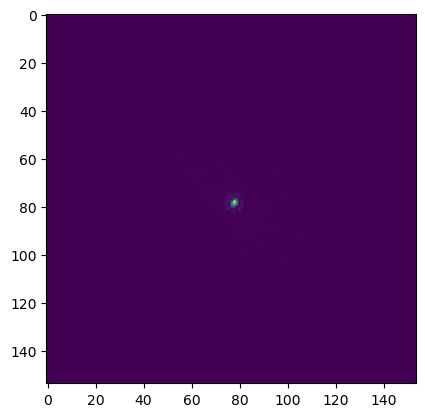

In [160]:
plt.imshow(psf[0,2,1].cpu().detach().numpy())

In [125]:
cent = psf.shape[3]//2

In [126]:
blockA = nn.Sequential(
          nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
        nn.MaxPool2d(2),
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU()
        ) 

In [179]:
# ---------------------
# Inception-ResNet Block
# ---------------------
class InceptionResNetBlockA(nn.Module):
    def __init__(self):
        super().__init__()

        # Branch 1: 1x1 convolution
        self.branch1 = nn.Sequential(nn.Conv2d(128, 32, kernel_size=1),
        nn.BatchNorm2d(32),
    nn.ReLU())

        # Branch 2: 1x1 + 3x3 convolution
        self.branch2 = nn.Sequential(
            nn.Conv2d(128, 32, kernel_size=1),
            nn.BatchNorm2d(32),
    nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
    nn.ReLU()
        )

        # Branch 3: 
        self.branch3 = nn.Sequential(
            nn.Conv2d(128, 32, kernel_size=1),
            nn.BatchNorm2d(32),
    nn.ReLU(),
            nn.Conv2d(32, 48, kernel_size=3, padding=1),
            nn.BatchNorm2d(48),
    nn.ReLU(),
            nn.Conv2d(48, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
    nn.ReLU()
        )

        # Combine branches
        self.conv_linear = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(64)

        self.shortcut = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=1),
            nn.BatchNorm2d(64)
        )

    def forward(self, x):
        residual = self.shortcut(x)
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out = torch.cat([out1, out2, out3], dim=1)
        out = self.conv_linear(out)
        out = self.bn(out)
        out += residual  # Residual connection
        return F.relu(out)


In [293]:
resnetA = InceptionResNetBlockA()
backbone = nn.Sequential(blockA,
                      resnetA,
                      nn.MaxPool2d(2),
                      nn.Flatten(),
                      nn.Linear(1600, 256),
                      nn.BatchNorm1d(256),
    nn.ReLU(),
                      nn.Dropout(p=0.3),
                    nn.Linear(256, 256),
                      nn.ReLU(),
                      nn.BatchNorm1d(256),
                      nn.Linear(256, 64),
                      nn.BatchNorm1d(64),
    nn.ReLU(),
                     )

In [294]:
model2d = nn.Sequential(backbone,
                      nn.Linear(64, 2),
                       nn.BatchNorm1d(2),
                      nn.Tanh())

In [351]:
backbone2 = copy.deepcopy(backbone)

In [352]:
model3d = nn.Sequential(backbone2,
                      nn.Linear(64, 3),
                       nn.BatchNorm1d(3),
                      nn.Tanh())

In [373]:
backbone3 = copy.deepcopy(backbone2)

In [421]:
model5d = nn.Sequential(backbone3,
                      nn.Linear(64, 5),
                       nn.BatchNorm1d(5),
                      nn.Tanh())

In [422]:
optimizer = Adam(model5d.parameters(), lr=1e-4)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {num_params}")

Total trainable parameters: 1082633


In [423]:
def mse(a,b):
    return torch.mean((a-b)**2)

In [424]:
loss_record = []
def train(model, n_batch):
    model.train()
    for batch in tqdm(range(n_batch)):
        xp = torch.tensor(0.2*(np.random.rand(NPSF)-0.5)*2, device=device)
        yp = torch.tensor(0.2*(np.random.rand(NPSF)-0.5)*2, device=device)
        z = torch.tensor(2.5*0.8+(np.random.rand(NPSF)-0.5)*1.5, device=device)
        rho = torch.tensor(180*np.random.rand(NPSF), device=device)
        eta = torch.tensor(180*np.random.rand(NPSF), device=device)
        delta = torch.tensor(180*np.random.rand(NPSF), device=device)
        u, v, M = compute_M(xp=xp, yp=yp, zp=z, d=d_, x=x, y=y, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2,
                        Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k, f_o=f_o,
                        phase_maskx=phase_mask, phase_masky=phase_mask, zernike_base=zernike_base, zernike_coefs_x=zernike_coefs_x, zernike_coefs_y=zernike_coefs_x,
                        second_plane=second_plane, polar_projections=polar_projections, N=N,
                        l_pixel=l_pixel, NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG,
                       polar_offset=20., polar_offset2=20.)
        psf = (noise(PSF(rho=rho, eta=eta, delta=delta, M=M, N_photons=N_photons), QE=1, EM=1, b=0., sigma_b=0.001, sigma_r=0., bias=0.001).to(dtype=torch.float32)[:,:,:,cent-10:cent+10,cent-10:cent+10]).reshape((NPSF,6,20,20))
        #plt.imshow(psf[0,0].cpu().detach().numpy())
        #plt.show()
        pred = model(psf)
        plt.rcParams['figure.figsize'] = [25, 5]
        fig, ax = plt.subplots(1,5)
        ax[0].scatter(xp.detach().numpy(), (0.2*pred[:,0]).detach().numpy())
        ax[0].plot(xp.detach().numpy(), xp.detach().numpy(), c='r')
        ax[1].scatter(z.detach().numpy(), 2.5*0.8+(0.75*pred[:,2]).detach().numpy())
        ax[1].plot(z.detach().numpy(), z.detach().numpy(), c='r')
        ax[2].scatter(rho.detach().numpy(),  90+(90*pred[:,3]).detach().numpy())
        ax[2].plot(rho.detach().numpy(), rho.detach().numpy(), c='r')
        #ax[3].scatter(eta.detach().numpy(),  90+(90*pred[:,4]).detach().numpy())
        #ax[3].plot(eta.detach().numpy(), eta.detach().numpy(), c='r')
        ax[4].scatter(delta.detach().numpy(), 90+(90*pred[:,4]).detach().numpy())
        ax[4].plot(delta.detach().numpy(), delta.detach().numpy(), c='r')
        plt.show()
        del(fig, ax)
        #loss = mse(pred[:,:2], torch.stack([xp/0.2, yp/0.2]).permute(1, 0))
        #loss = mse(pred[:,:3], torch.stack([xp/0.2, yp/0.2, (z - 2.5*0.8)/0.75]).permute(1, 0))
        loss = mse(pred, torch.stack([xp/0.2, yp/0.2, (z - 2.5*0.8)/0.75, (rho-90)/90, (delta-90)/90]).permute(1, 0))
        loss_record.append(loss.detach().cpu())
        print(loss, pred[0])
        loss.backward() # Compute gradients of the loss w.r.t parameters (backward pass)
        optimizer.step() # Do a gradient descent step and adjust parameters
        optimizer.zero_grad() # Reset the gradients of model parameters to zero (gradients by default add up)

  0%|          | 0/100 [00:00<?, ?it/s]

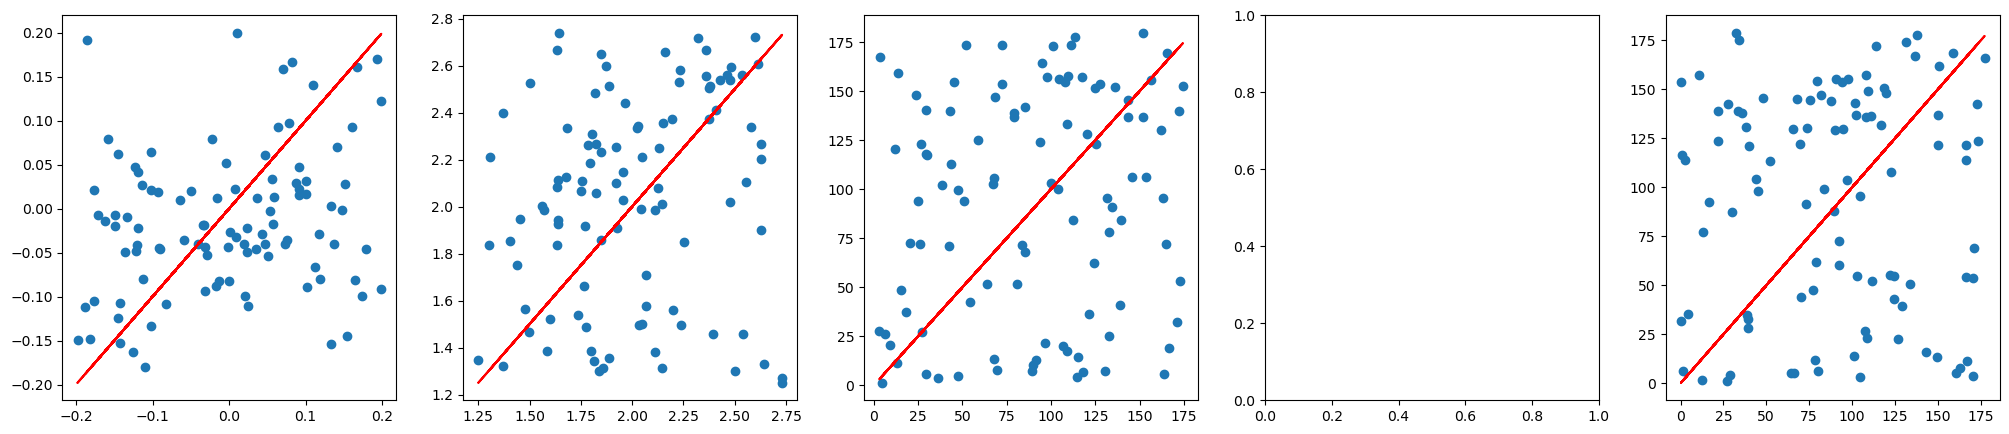

tensor(0.4990, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.2267, -0.7833, -0.8579,  0.5169,  0.7466],
       grad_fn=<SelectBackward0>)


  1%|          | 1/100 [00:12<21:04, 12.77s/it]

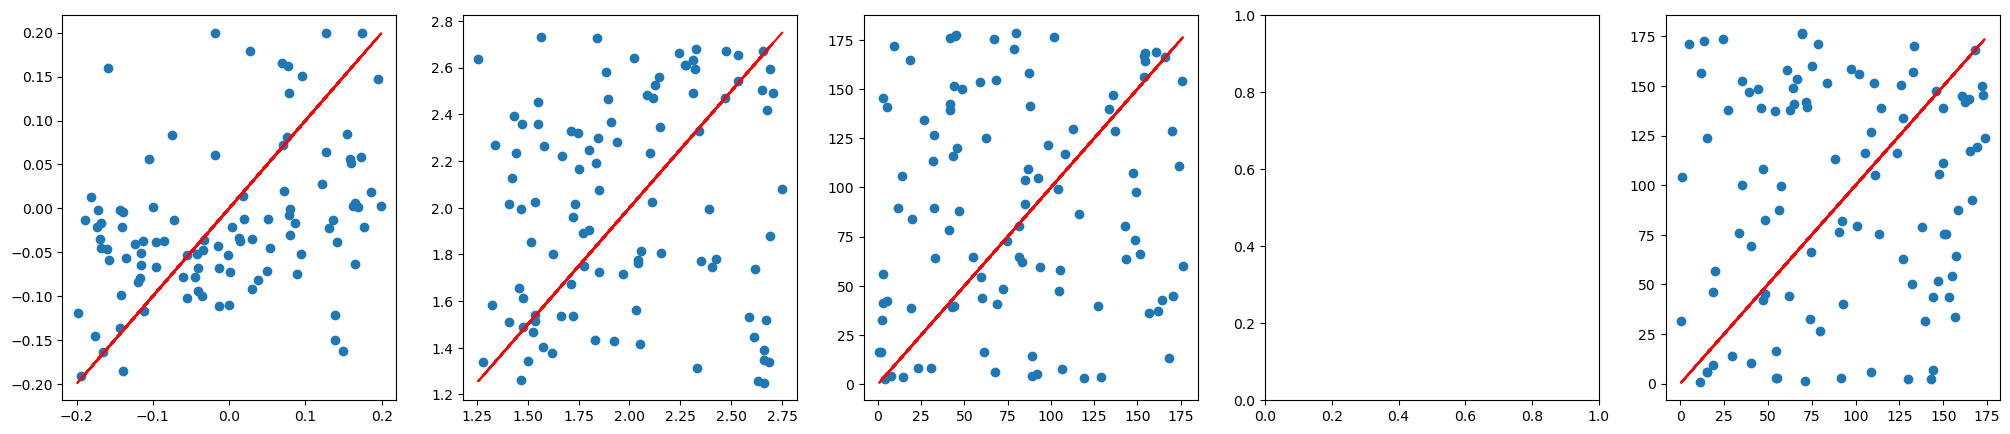

tensor(0.5157, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.1897,  0.4086,  0.1049,  0.1633,  0.3749],
       grad_fn=<SelectBackward0>)


  2%|▏         | 2/100 [00:24<19:52, 12.17s/it]

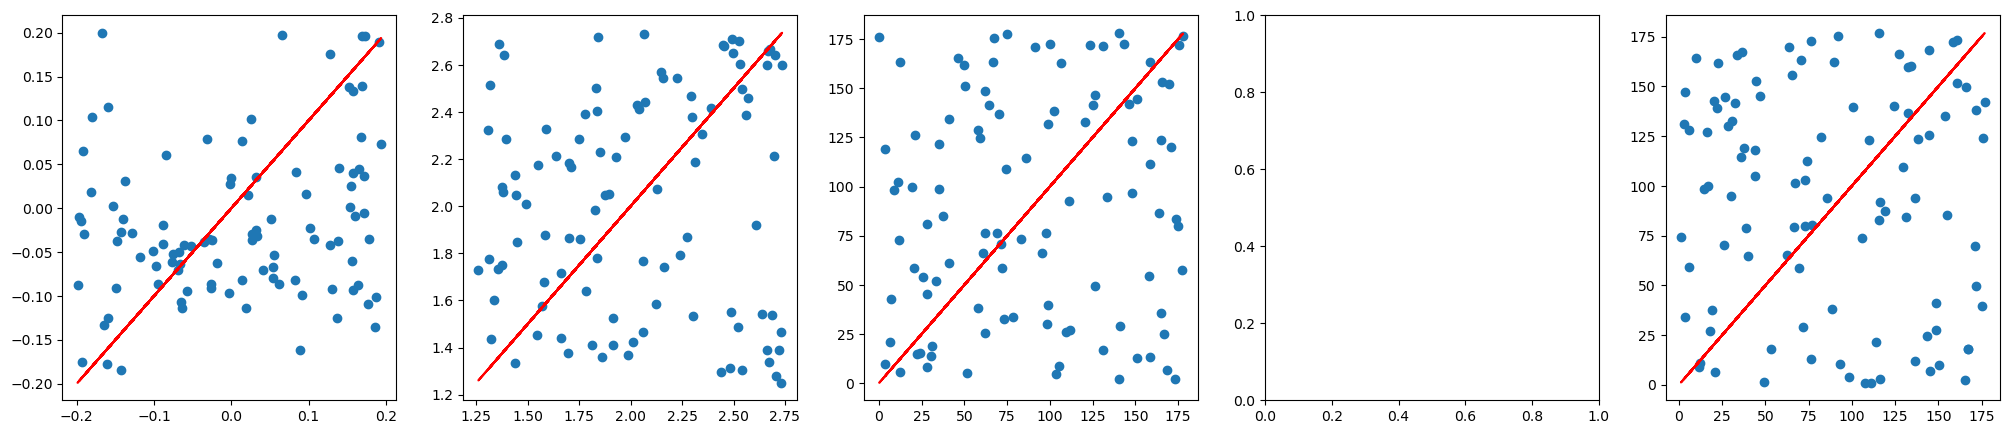

tensor(0.5993, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.2104, -0.2717, -0.7843, -0.1485,  0.0417],
       grad_fn=<SelectBackward0>)


  3%|▎         | 3/100 [00:37<19:55, 12.33s/it]

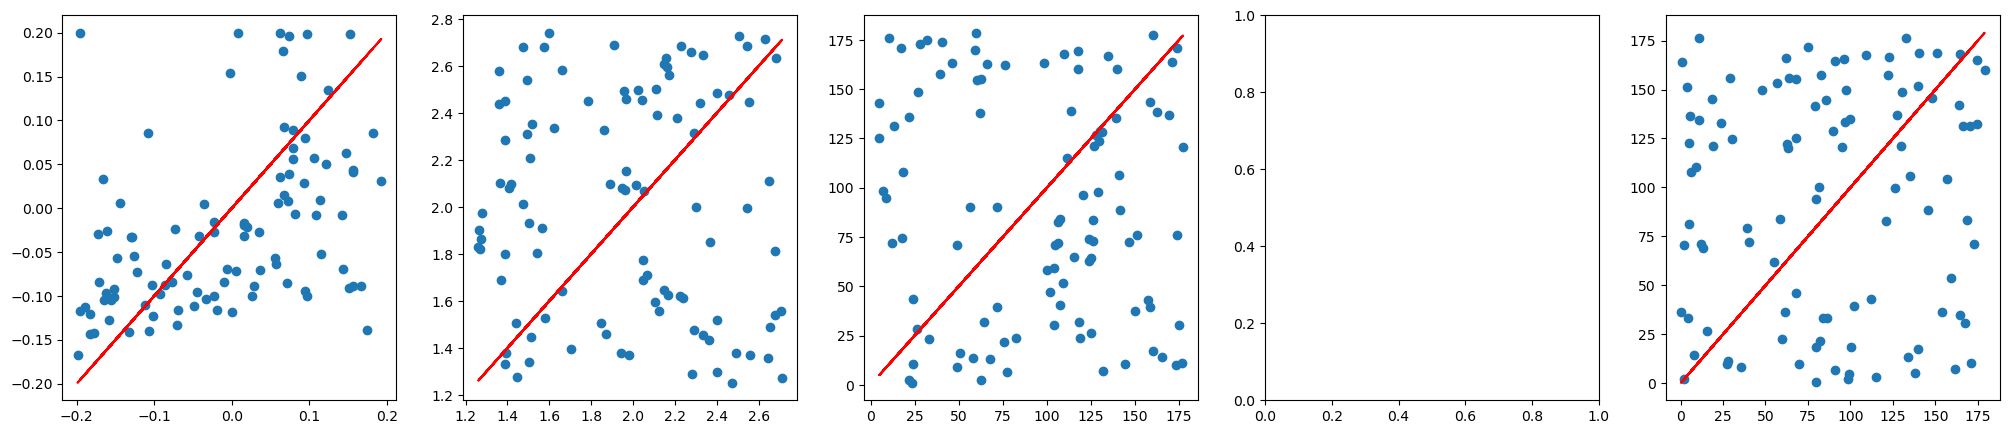

tensor(0.5854, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.7049,  0.8892,  0.7723, -0.1573,  0.1067],
       grad_fn=<SelectBackward0>)


  4%|▍         | 4/100 [00:48<19:10, 11.99s/it]

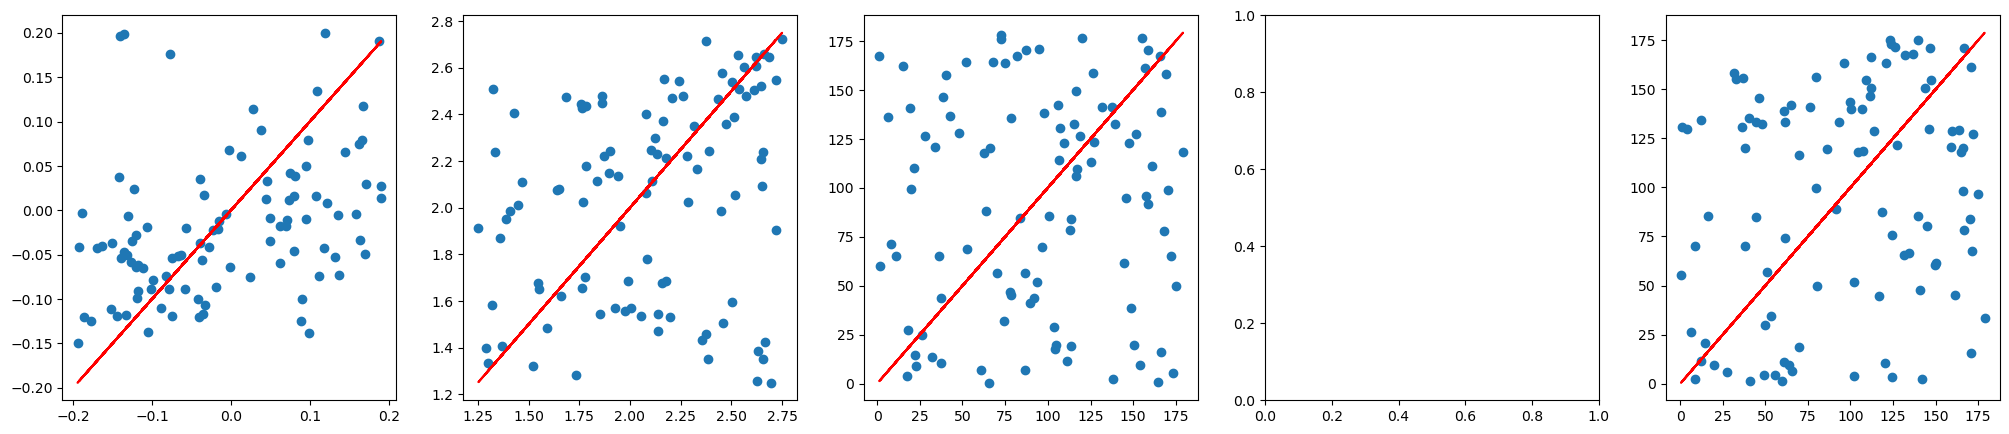

tensor(0.4766, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.5522, -0.5102, -0.5922, -0.4990, -0.4239],
       grad_fn=<SelectBackward0>)


  5%|▌         | 5/100 [01:00<18:46, 11.86s/it]

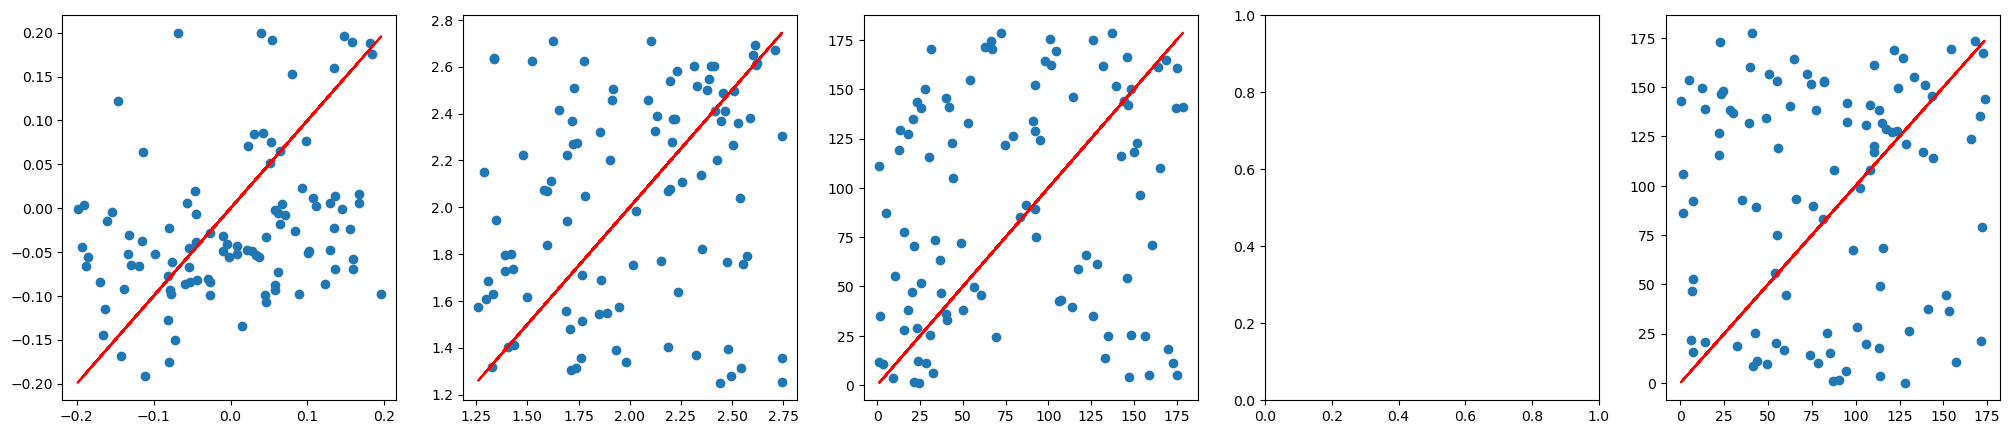

tensor(0.5096, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.4078,  0.3908,  0.5045,  0.5951,  0.5044],
       grad_fn=<SelectBackward0>)


  6%|▌         | 6/100 [01:13<19:22, 12.36s/it]

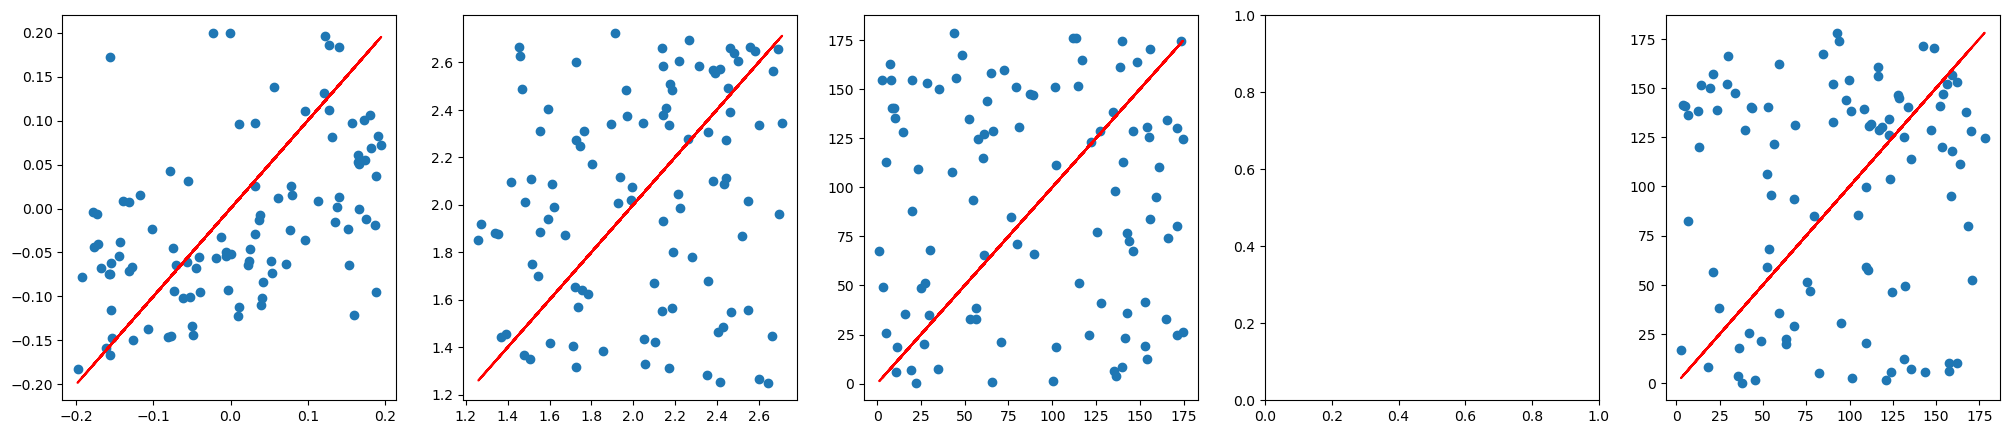

tensor(0.5096, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.8607, -0.7992, -0.9965, -0.9955, -0.5740],
       grad_fn=<SelectBackward0>)


  7%|▋         | 7/100 [01:25<19:05, 12.32s/it]

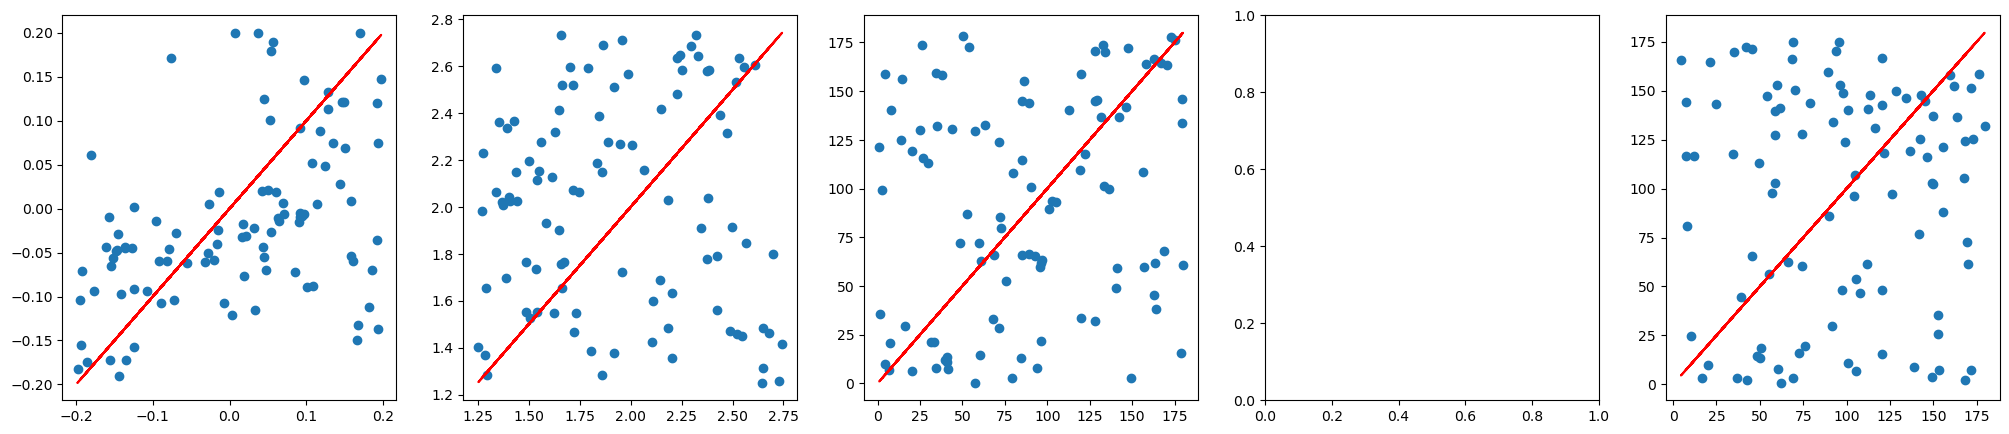

tensor(0.5369, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.4382, -0.1594,  0.3094,  0.7246,  0.6919],
       grad_fn=<SelectBackward0>)


  8%|▊         | 8/100 [01:37<18:45, 12.23s/it]

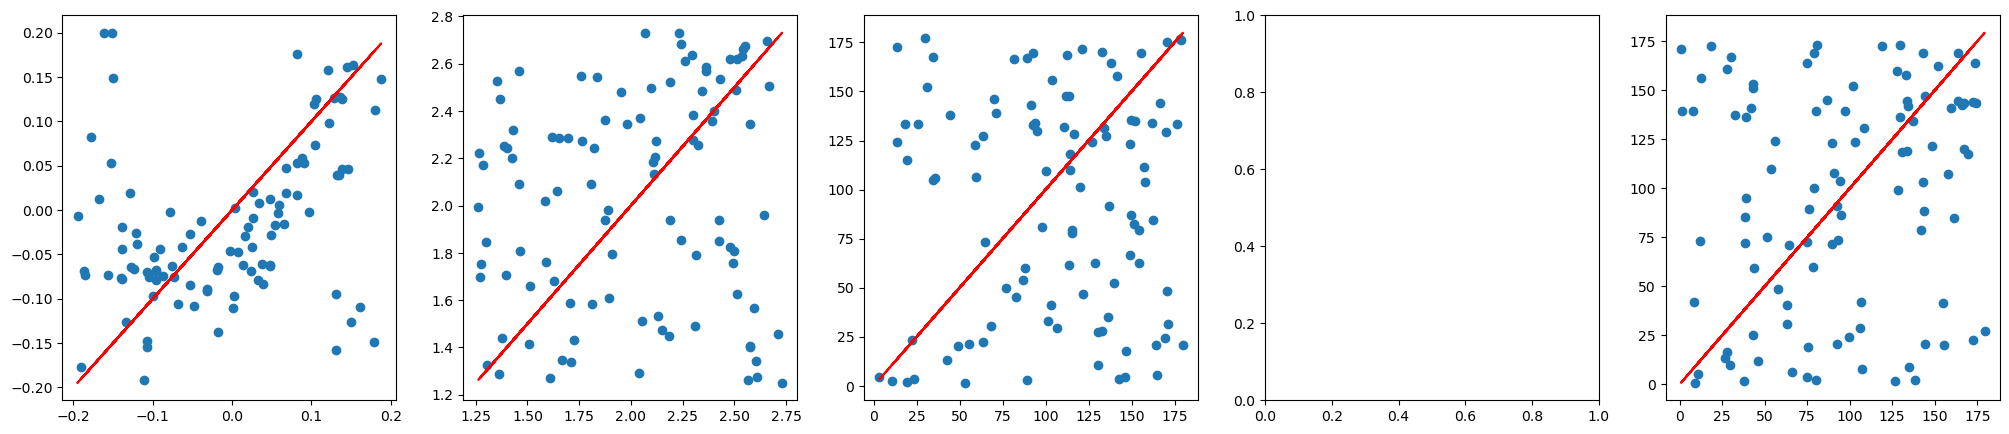

tensor(0.5108, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.7875, -0.5604, -0.2080,  0.5448,  0.7383],
       grad_fn=<SelectBackward0>)


  9%|▉         | 9/100 [01:49<18:19, 12.09s/it]

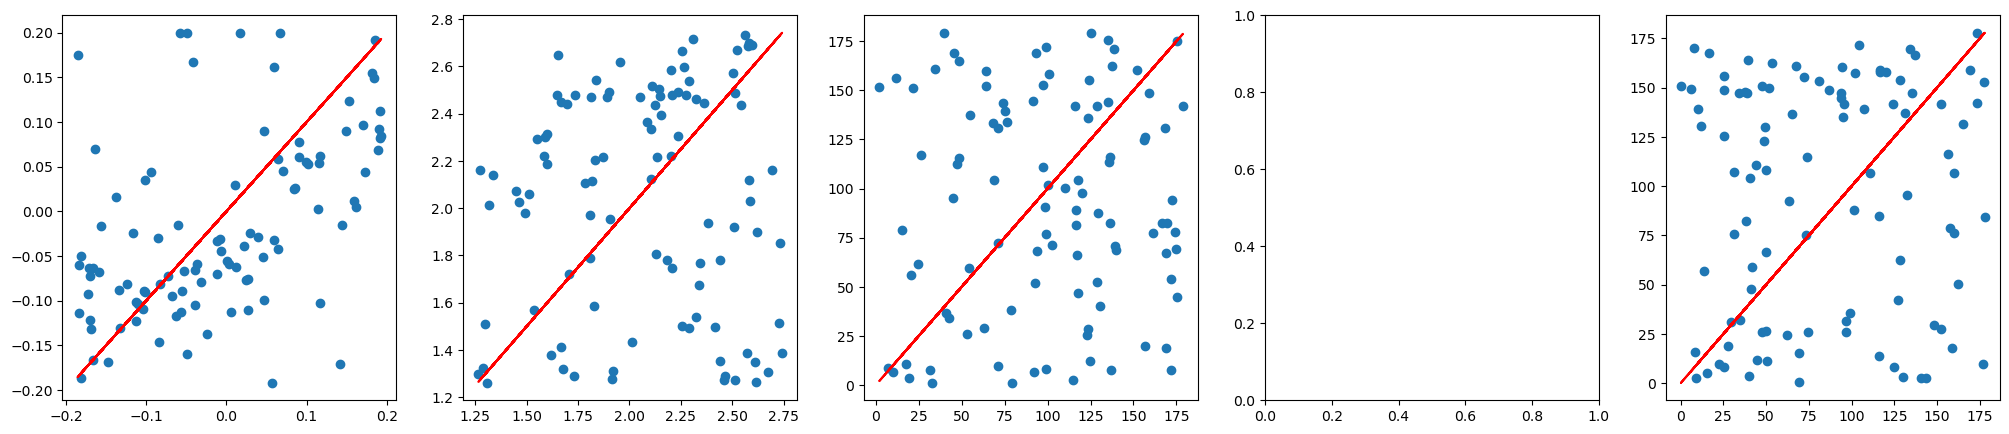

tensor(0.5285, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.2121, -0.0082,  0.3932,  0.6534,  0.7073],
       grad_fn=<SelectBackward0>)


 10%|█         | 10/100 [02:01<18:01, 12.01s/it]

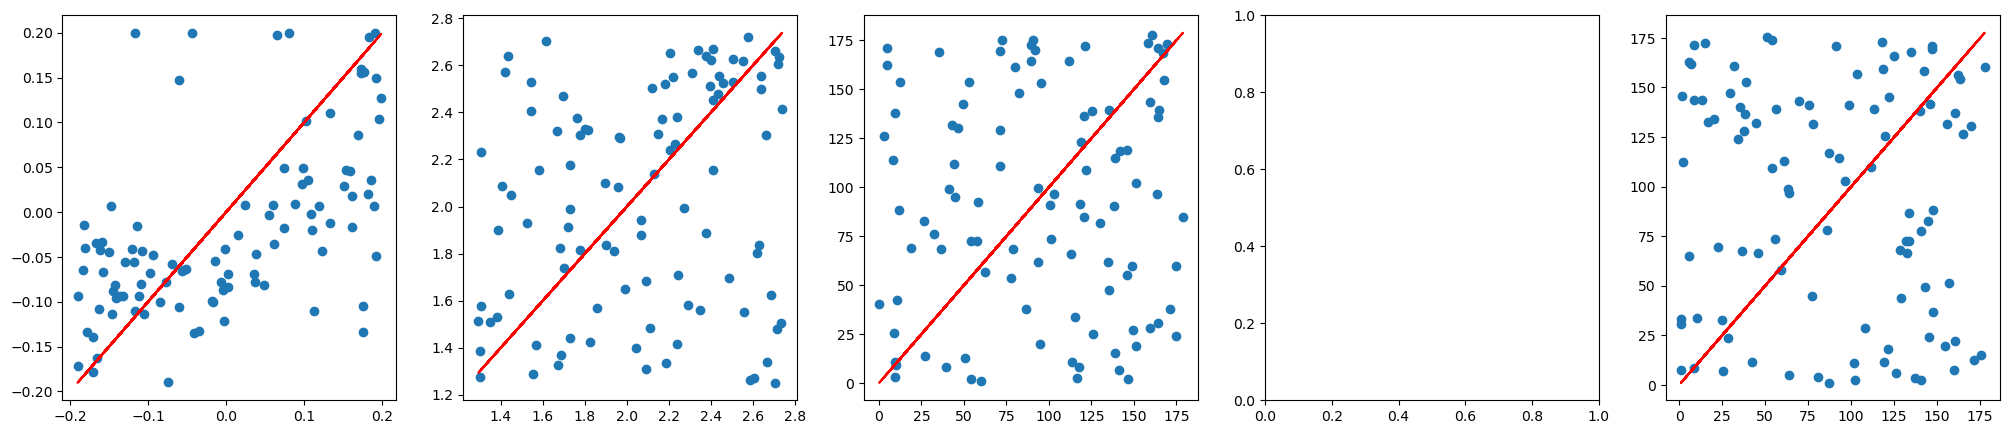

tensor(0.5408, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.9963,  0.9563, -0.9703,  0.3181, -0.2589],
       grad_fn=<SelectBackward0>)


 11%|█         | 11/100 [02:14<18:06, 12.21s/it]

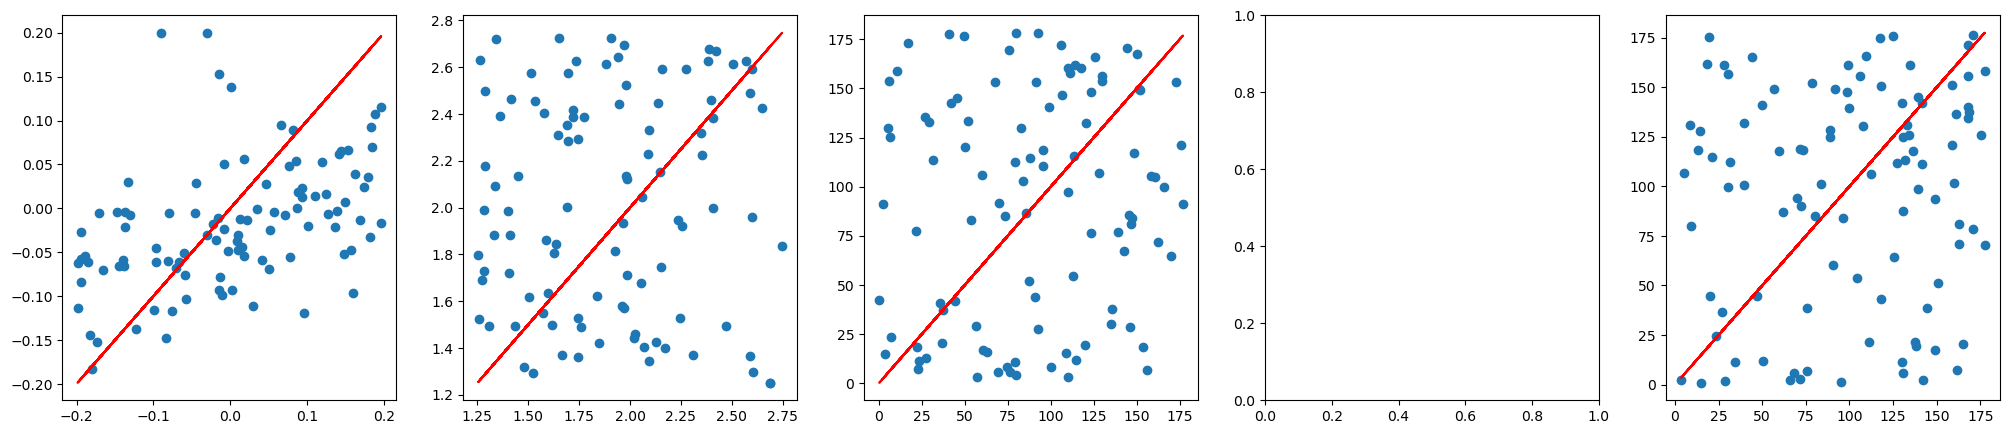

tensor(0.4967, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.0352, -0.8604, -0.9073, -0.5348,  0.2427],
       grad_fn=<SelectBackward0>)


 12%|█▏        | 12/100 [02:26<17:50, 12.16s/it]

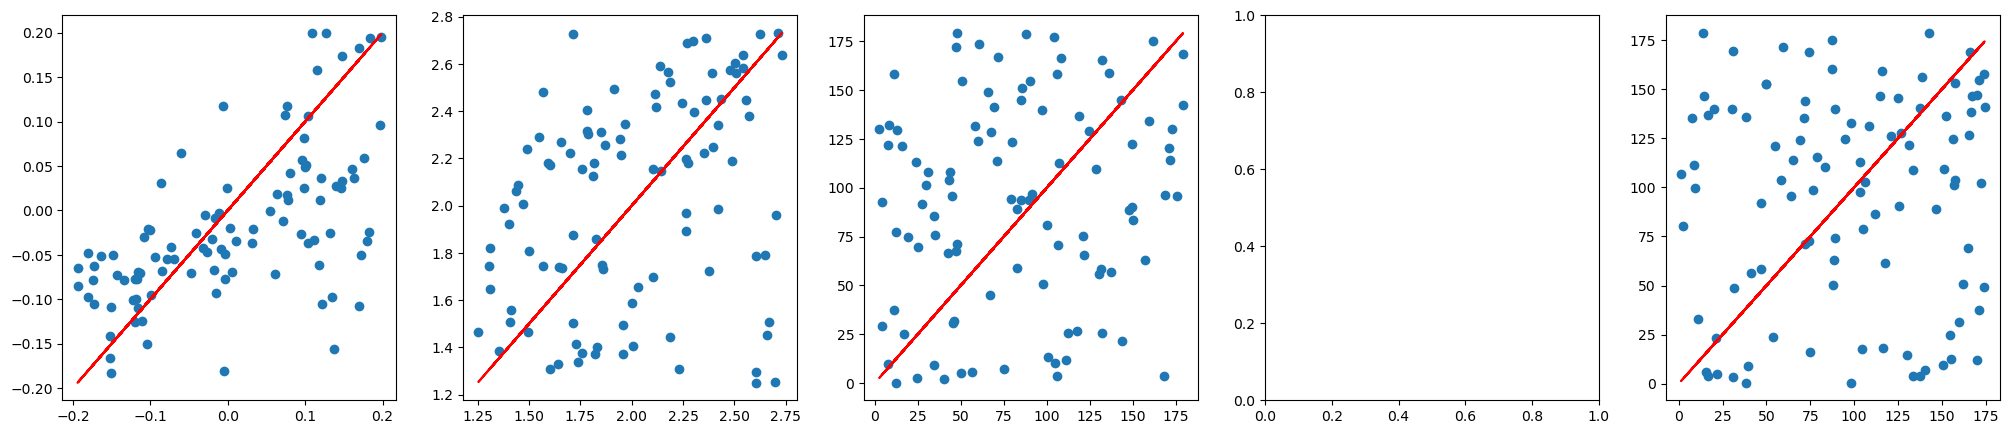

tensor(0.4493, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.1273, -0.1711,  0.2297,  0.6805,  0.6945],
       grad_fn=<SelectBackward0>)


 13%|█▎        | 13/100 [02:37<17:23, 12.00s/it]

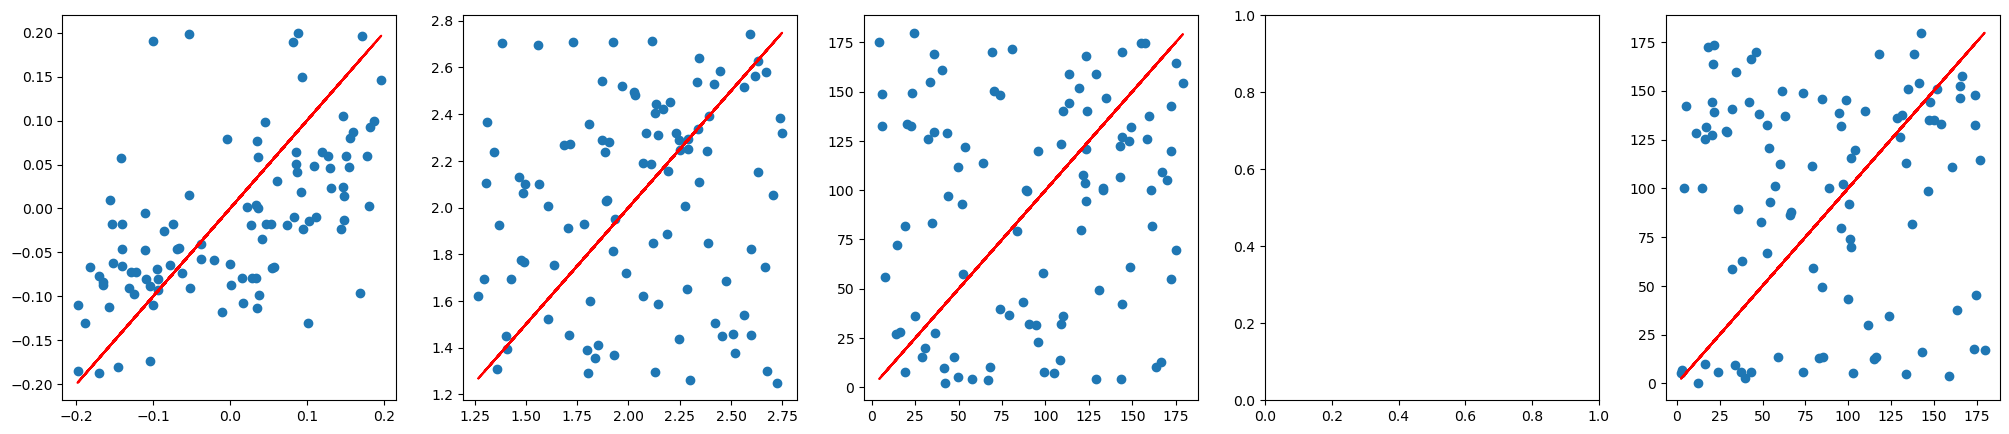

tensor(0.4835, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.2325, -0.6186, -0.8061, -0.9510, -0.9379],
       grad_fn=<SelectBackward0>)


 14%|█▍        | 14/100 [02:49<17:06, 11.94s/it]

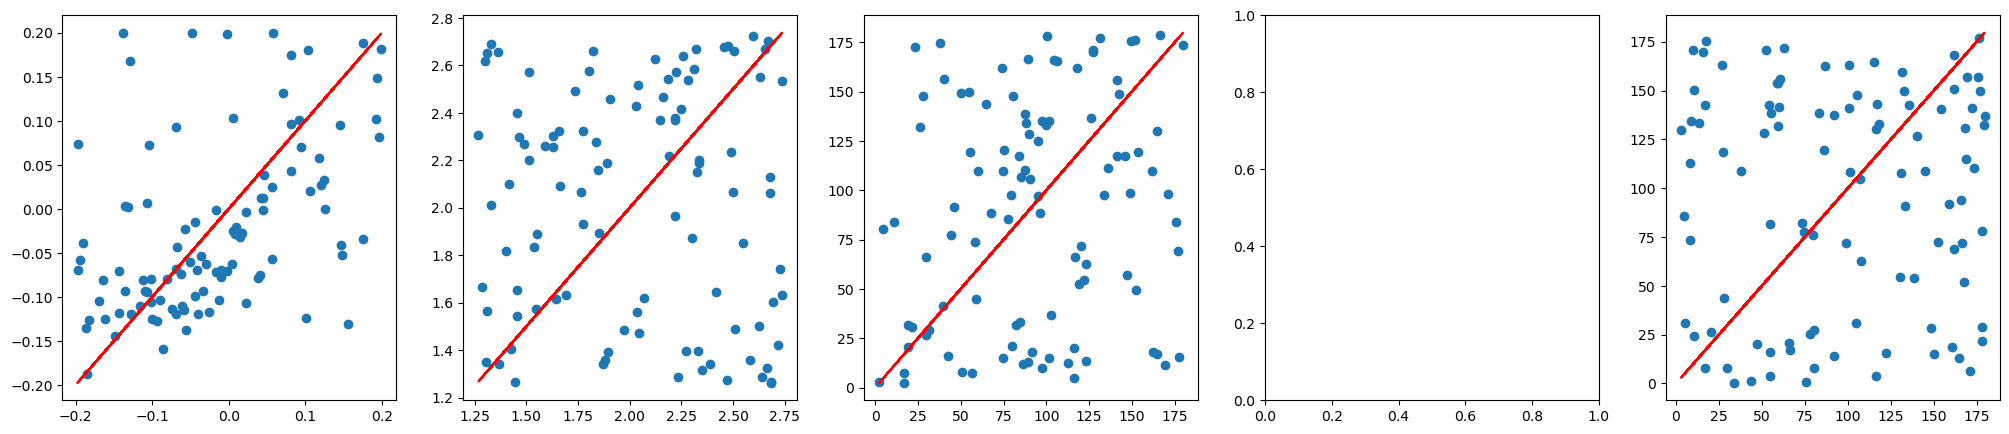

tensor(0.5343, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.1378, -0.9495, -0.8782, -0.0163,  0.5851],
       grad_fn=<SelectBackward0>)


 15%|█▌        | 15/100 [03:01<16:59, 11.99s/it]

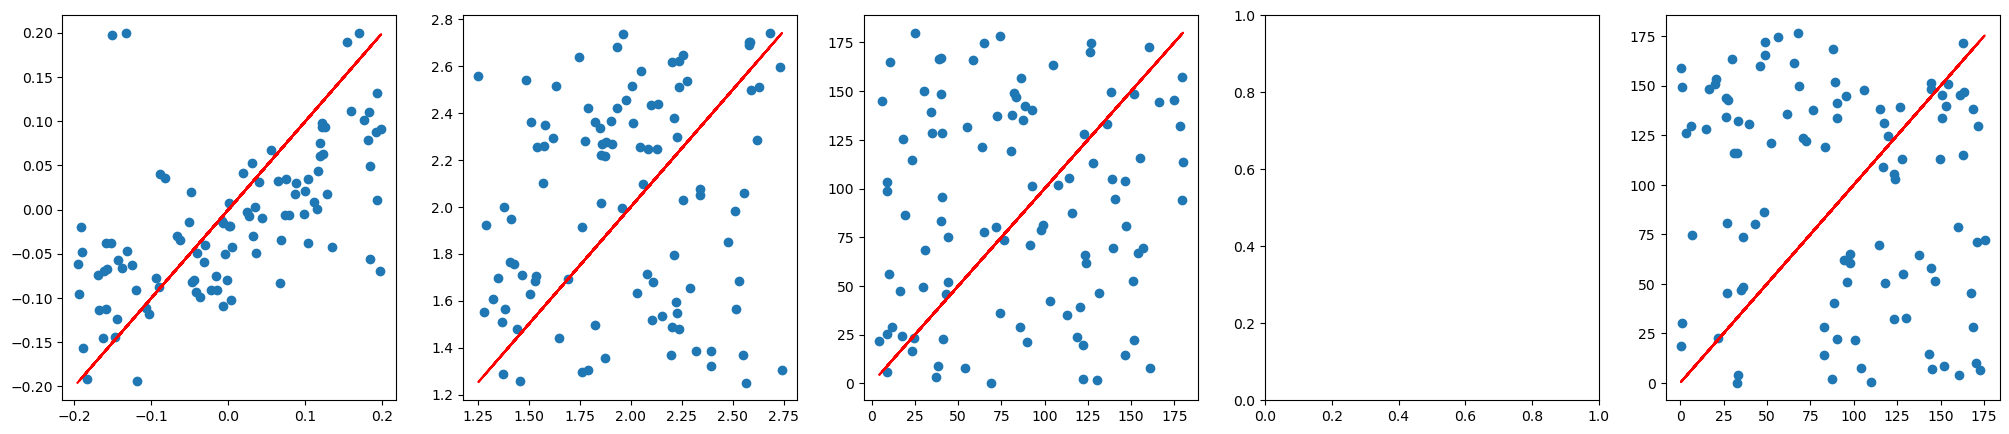

tensor(0.5085, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.3078, -0.6483, -0.9041, -0.9660, -0.9250],
       grad_fn=<SelectBackward0>)


 16%|█▌        | 16/100 [03:14<17:01, 12.16s/it]

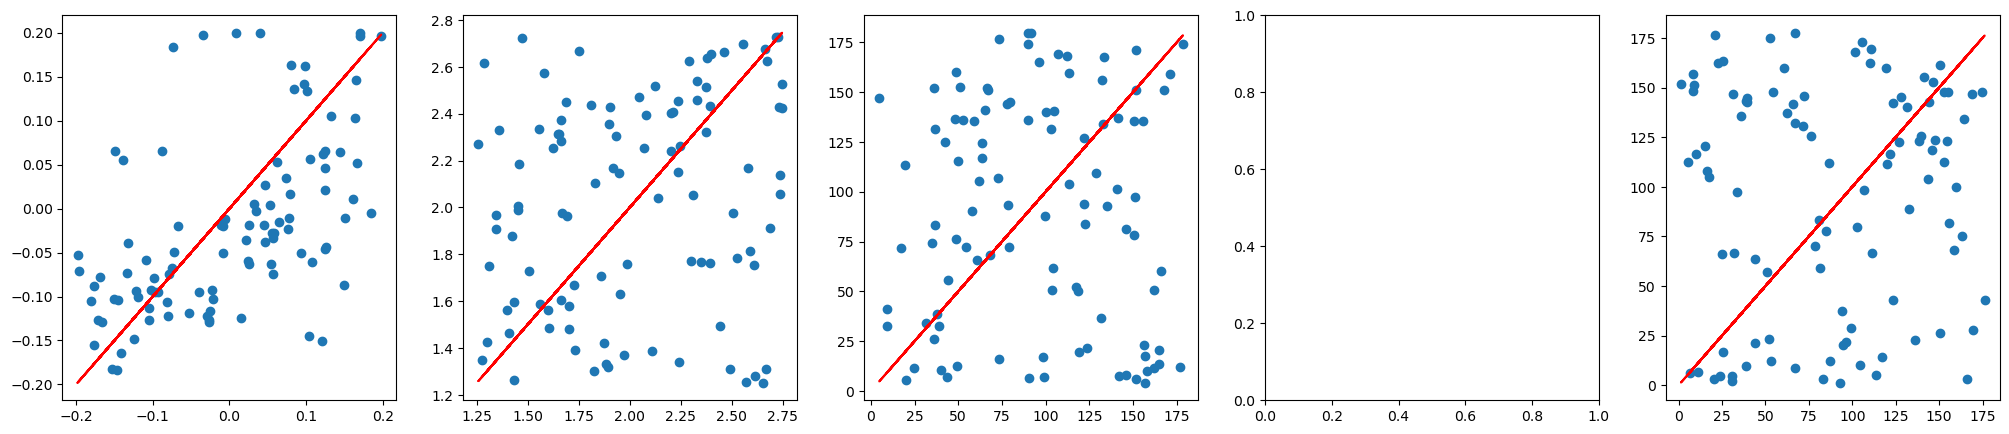

tensor(0.5048, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.5671, -0.4775, -0.3052, -0.3807, -0.2401],
       grad_fn=<SelectBackward0>)


 17%|█▋        | 17/100 [03:25<16:34, 11.99s/it]

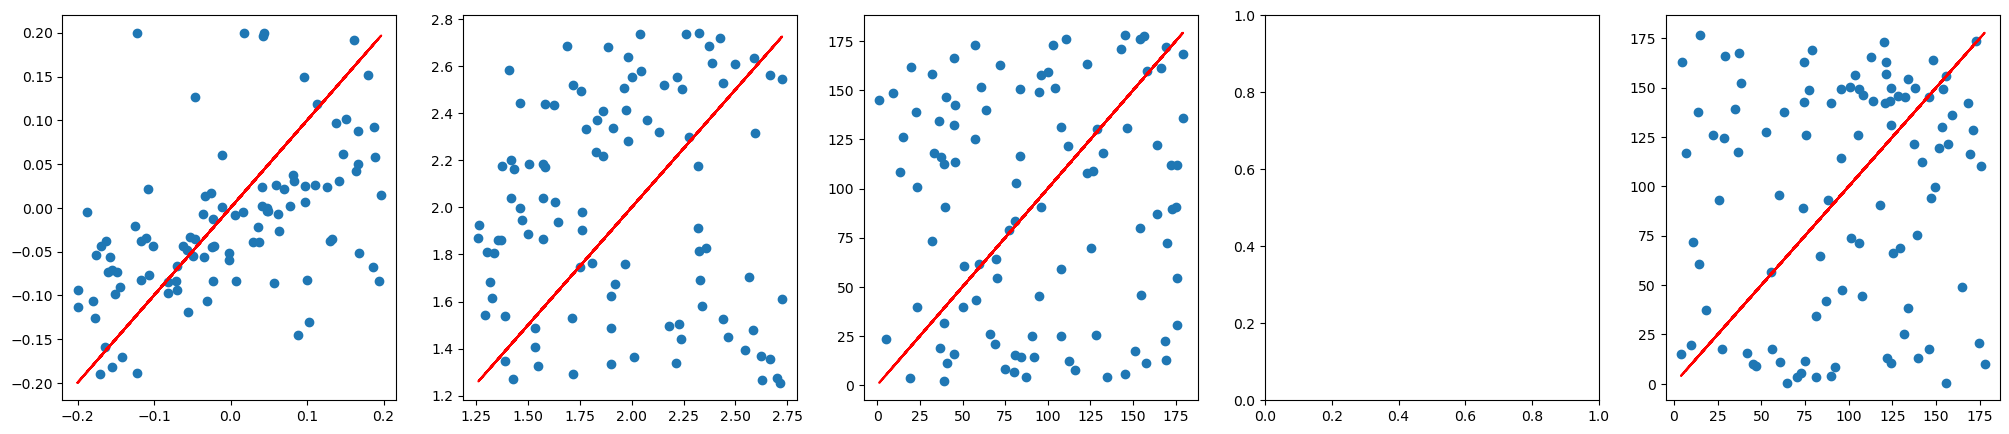

tensor(0.5237, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.4132, -0.0543, -0.4238,  0.3127,  0.5817],
       grad_fn=<SelectBackward0>)


 18%|█▊        | 18/100 [03:37<16:21, 11.97s/it]

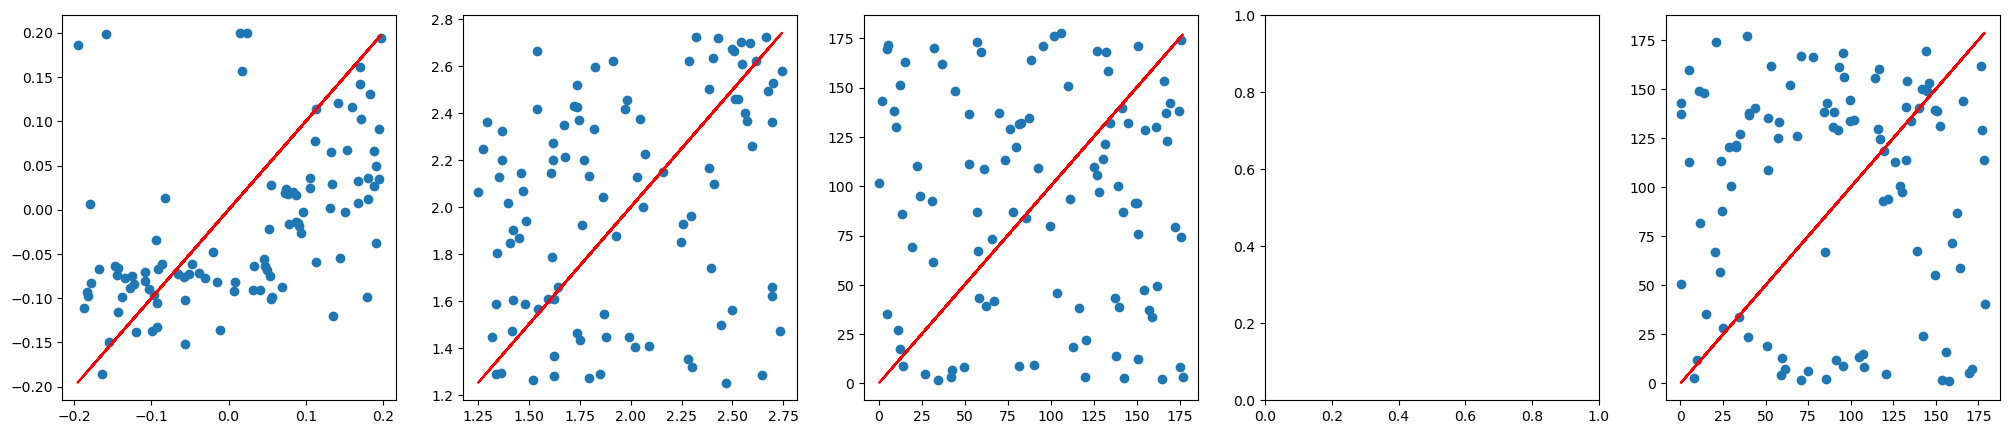

tensor(0.5448, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.4536, -0.7498, -0.9466, -0.2552,  0.5566],
       grad_fn=<SelectBackward0>)


 19%|█▉        | 19/100 [03:49<16:08, 11.96s/it]

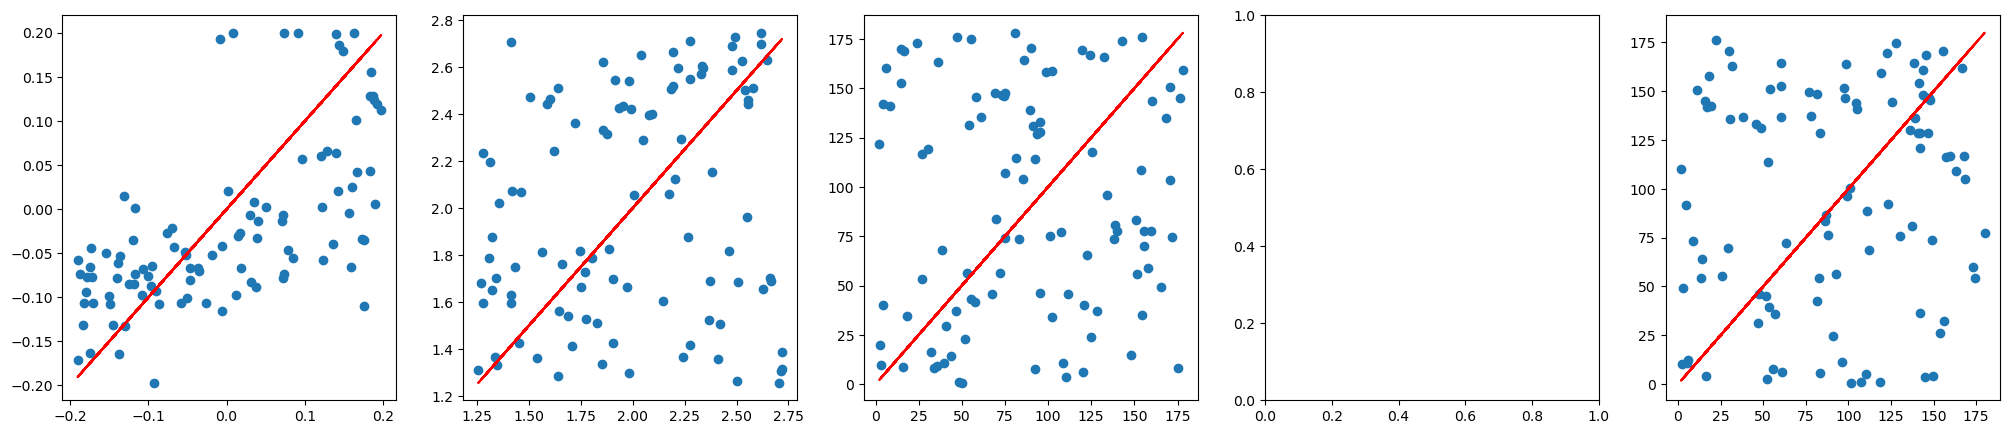

tensor(0.4740, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.3928,  0.0473, -0.4029, -0.0731, -0.3757],
       grad_fn=<SelectBackward0>)


 20%|██        | 20/100 [04:02<16:10, 12.13s/it]

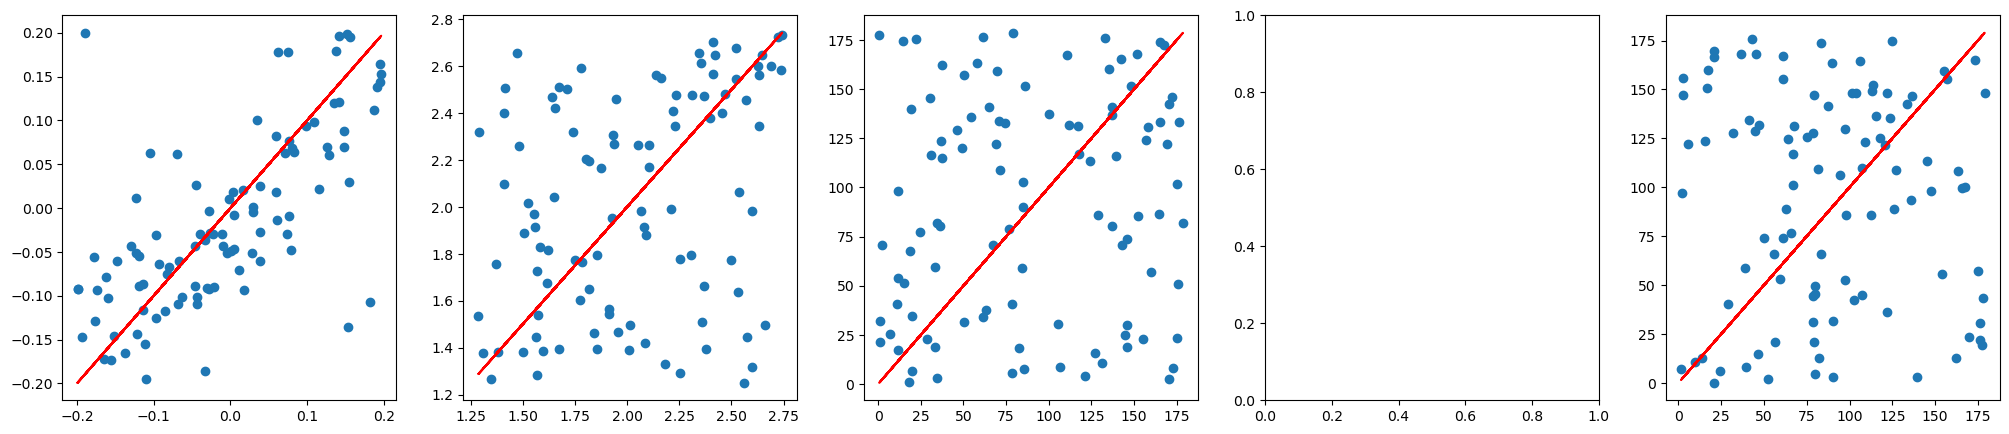

tensor(0.4480, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.3908, -0.5412, -0.7720, -0.7904, -0.7866],
       grad_fn=<SelectBackward0>)


 21%|██        | 21/100 [04:15<16:25, 12.48s/it]

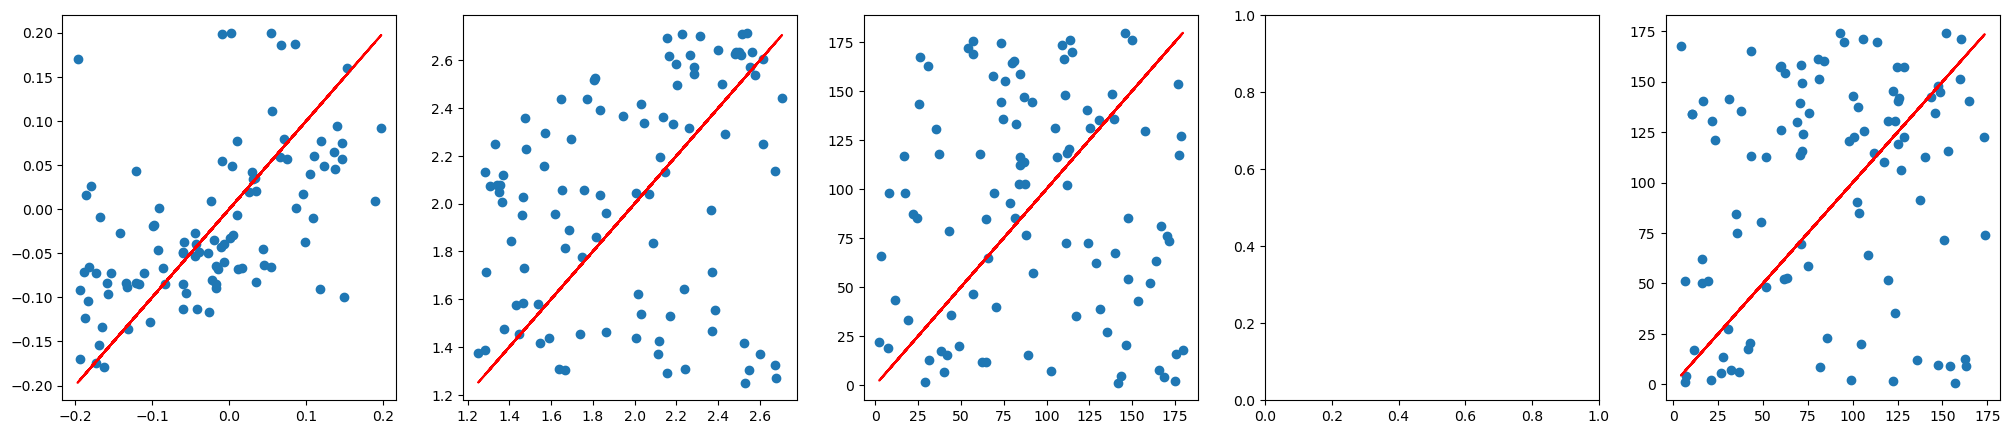

tensor(0.4685, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.7997, -0.1043,  0.8448,  0.9247,  0.9006],
       grad_fn=<SelectBackward0>)


 22%|██▏       | 22/100 [04:28<16:22, 12.60s/it]

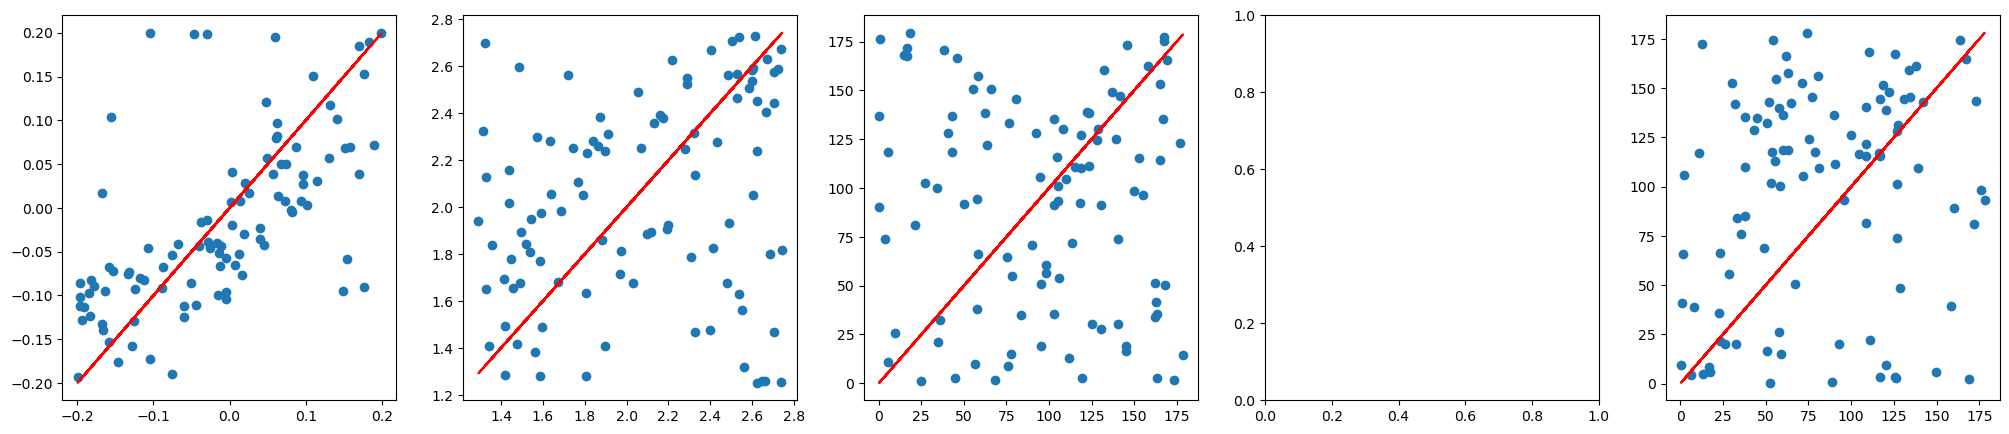

tensor(0.4667, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.5597,  0.5802,  0.6978,  0.4796,  0.5125],
       grad_fn=<SelectBackward0>)


 23%|██▎       | 23/100 [04:40<15:56, 12.42s/it]

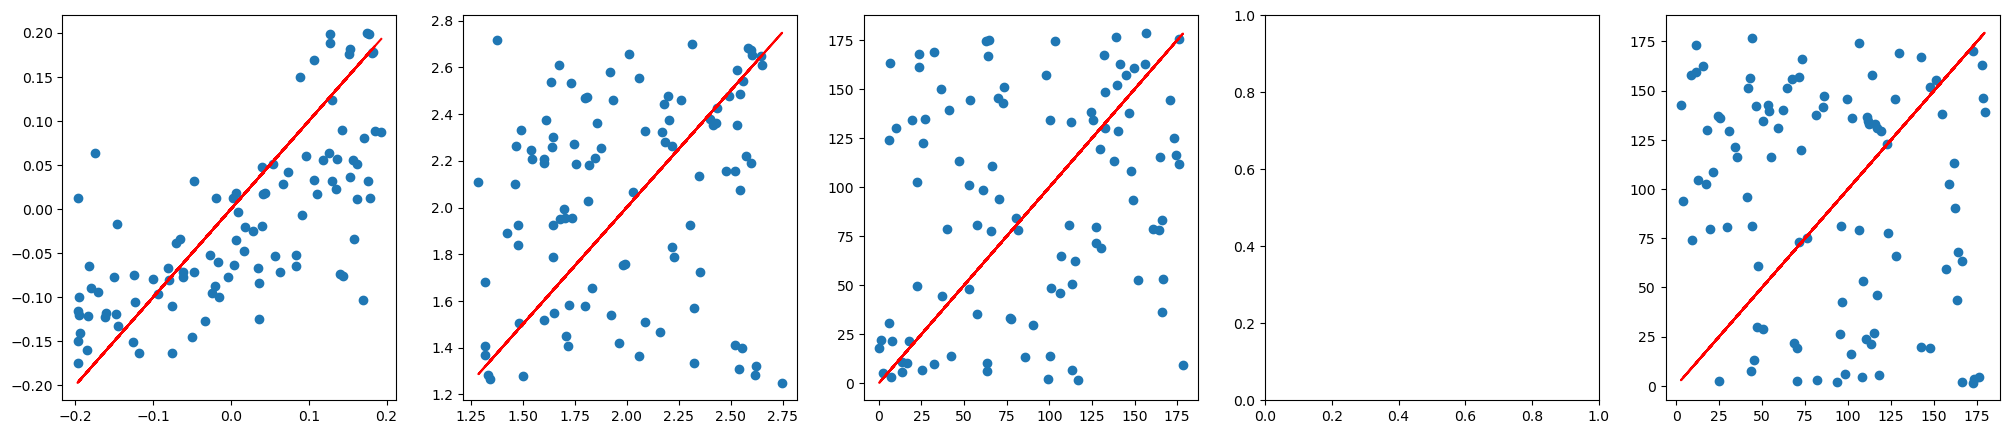

tensor(0.4774, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([0.8800, 0.3486, 0.8728, 0.9533, 0.8894], grad_fn=<SelectBackward0>)


 24%|██▍       | 24/100 [04:52<15:34, 12.30s/it]

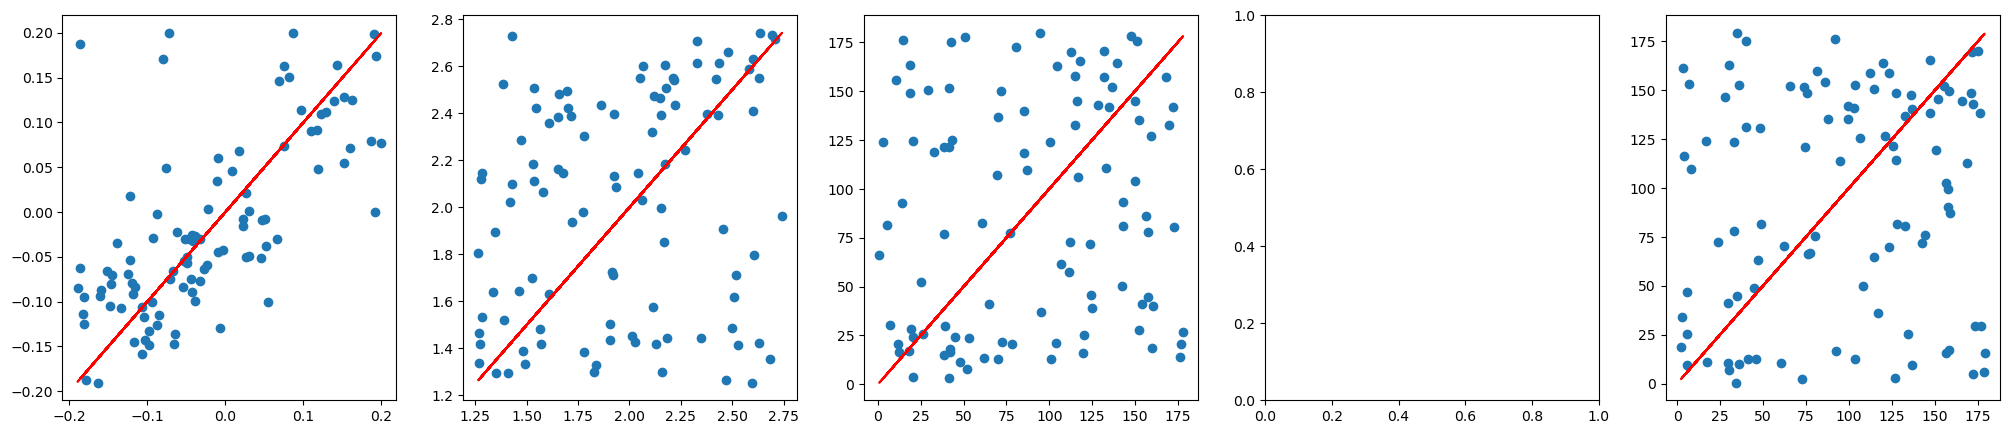

tensor(0.4704, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.2150, -0.9225, -0.9393, -0.7390, -0.2790],
       grad_fn=<SelectBackward0>)


 25%|██▌       | 25/100 [05:04<15:20, 12.27s/it]

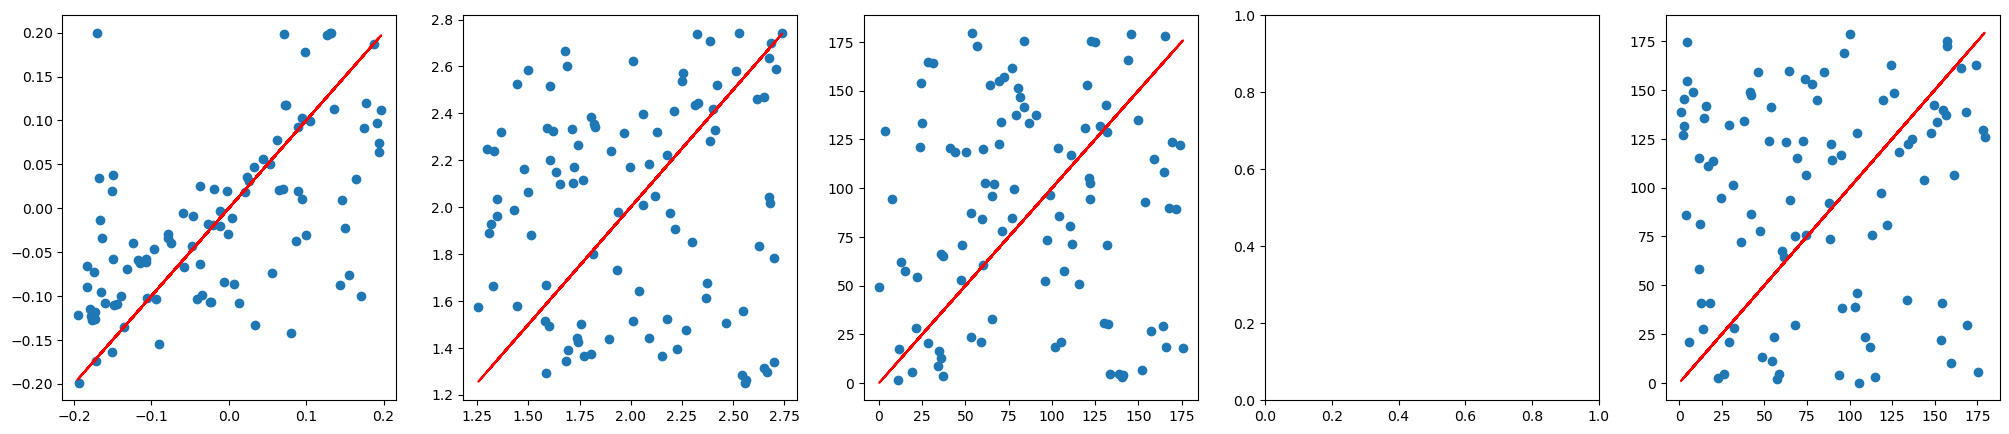

tensor(0.4856, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.1996,  0.1634,  0.1535,  0.3151,  0.3896],
       grad_fn=<SelectBackward0>)


 26%|██▌       | 26/100 [05:16<15:04, 12.22s/it]

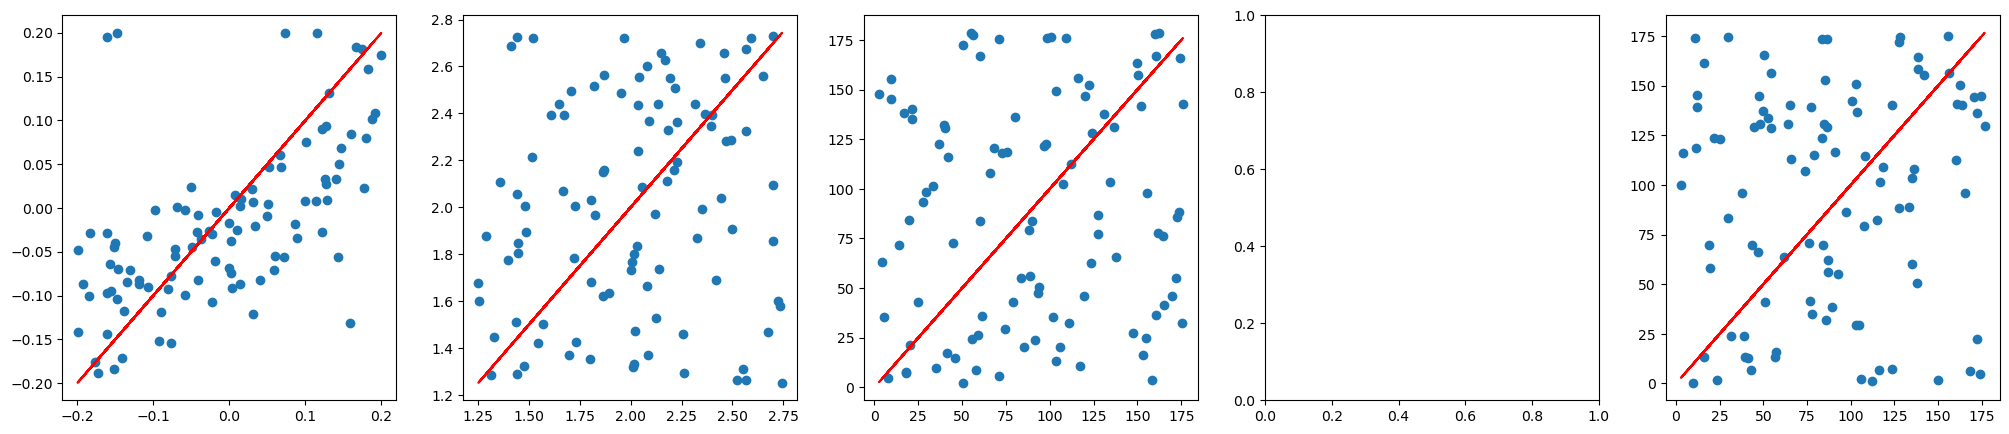

tensor(0.4781, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.4562, -0.6321, -0.2671, -0.3749,  0.0655],
       grad_fn=<SelectBackward0>)


 27%|██▋       | 27/100 [05:28<14:42, 12.09s/it]

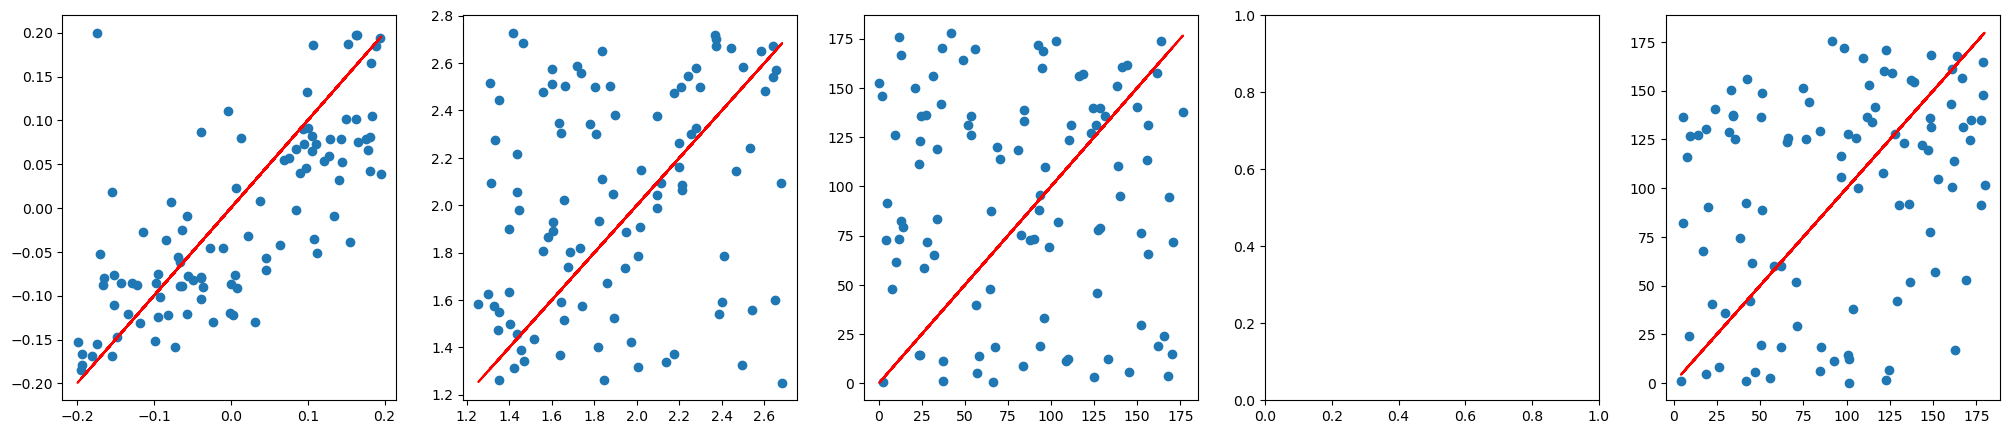

tensor(0.4465, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.2603, -0.0970,  0.1276,  0.4775,  0.3746],
       grad_fn=<SelectBackward0>)


 28%|██▊       | 28/100 [05:41<14:45, 12.29s/it]

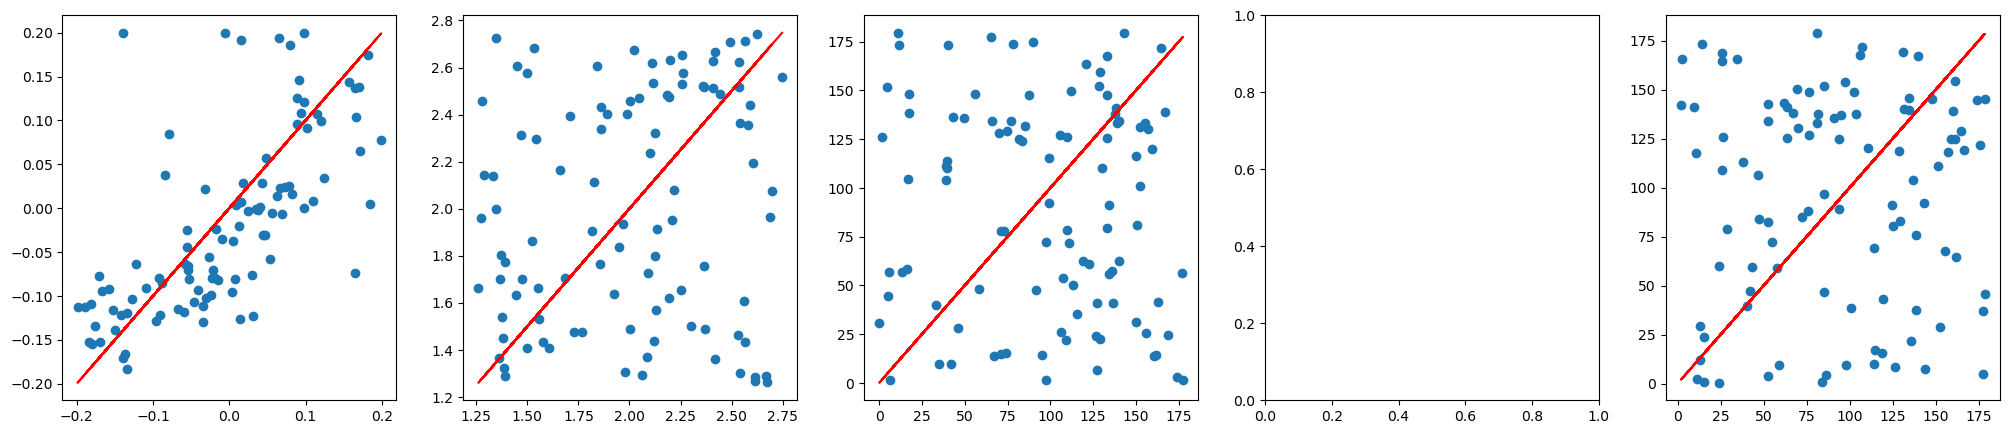

tensor(0.4951, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.1252,  0.4973,  0.7471,  0.4631,  0.4315],
       grad_fn=<SelectBackward0>)


 29%|██▉       | 29/100 [05:53<14:29, 12.24s/it]

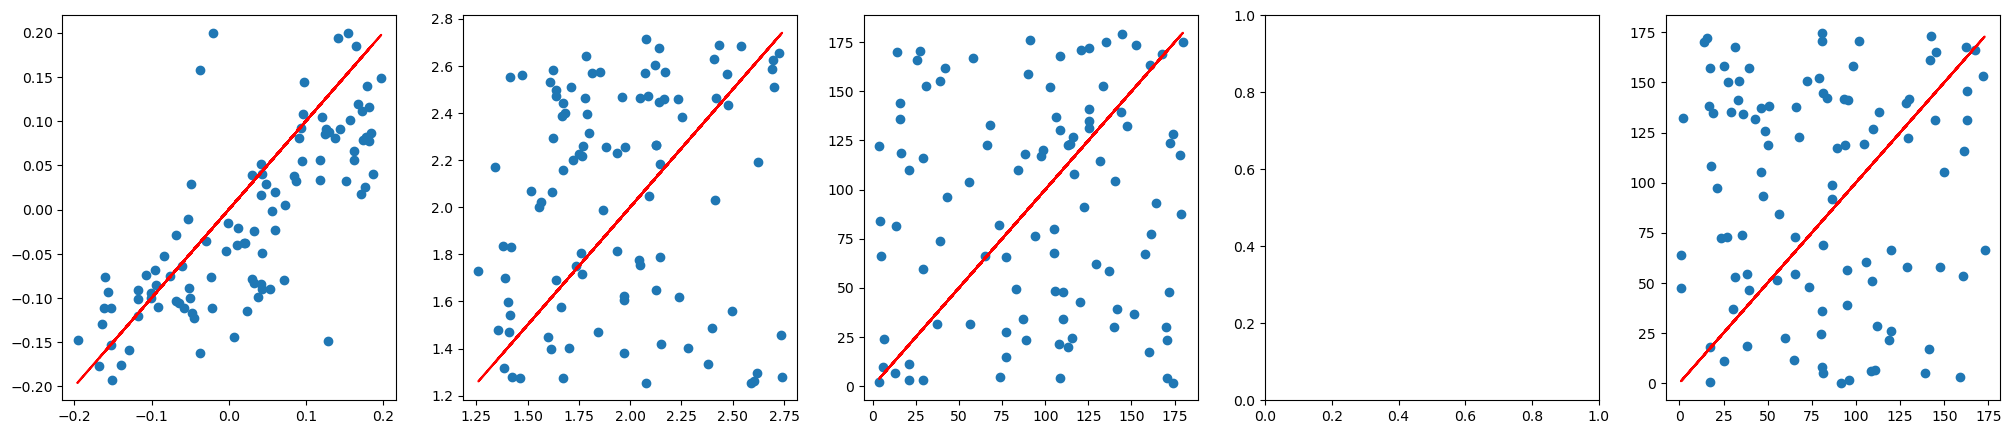

tensor(0.4623, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.5268, -0.2929, -0.3769, -0.2541, -0.1899],
       grad_fn=<SelectBackward0>)


 30%|███       | 30/100 [06:05<14:16, 12.24s/it]

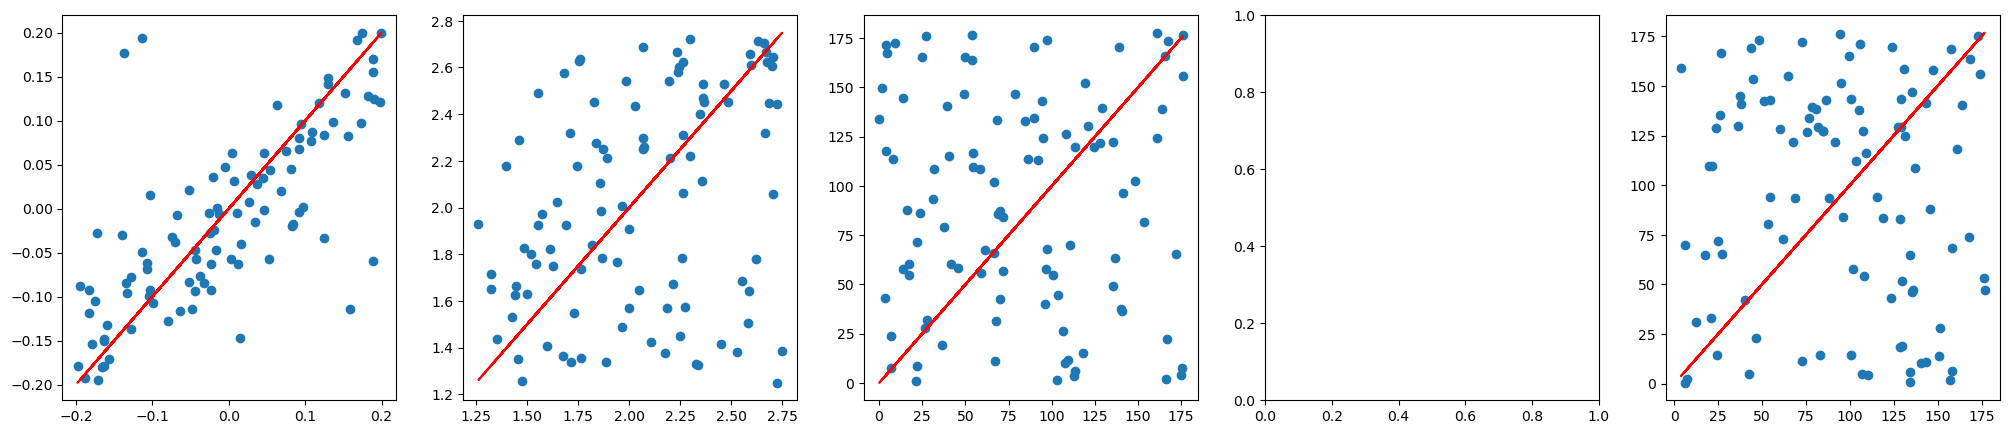

tensor(0.4484, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.7097, -0.1755,  0.7039,  0.5623,  0.4384],
       grad_fn=<SelectBackward0>)


 31%|███       | 31/100 [06:17<14:02, 12.21s/it]

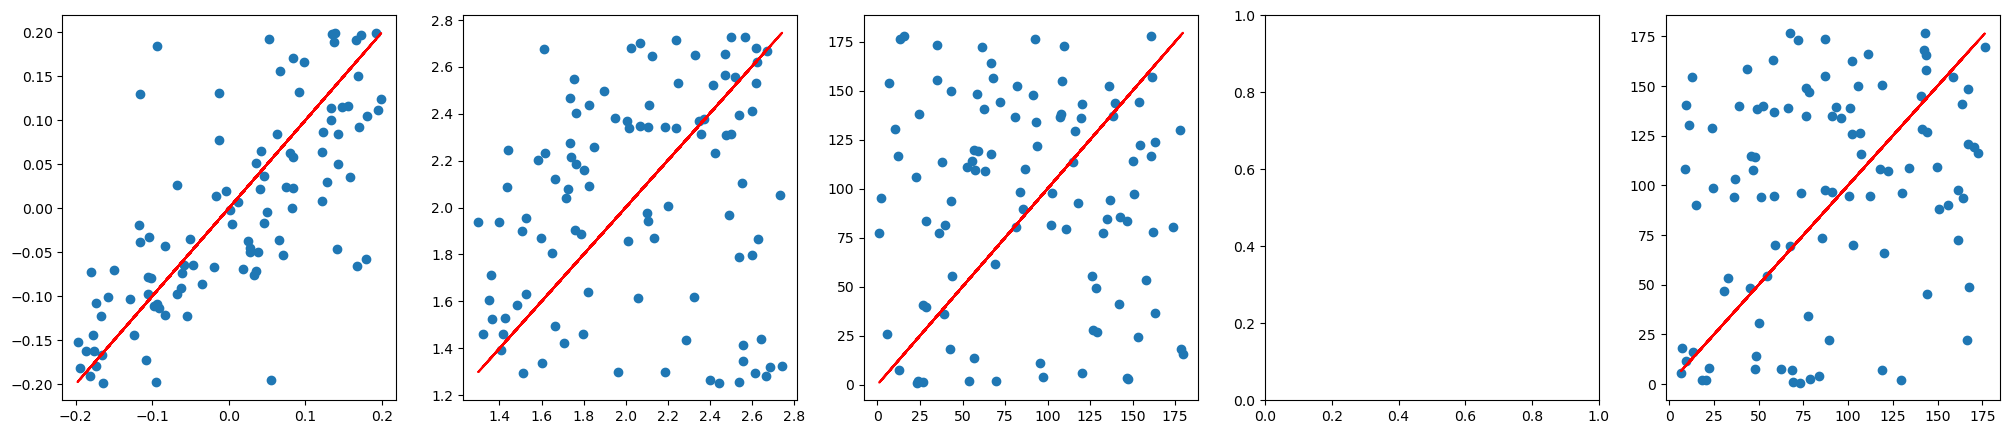

tensor(0.4217, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.7829, -0.3945,  0.7055,  0.3309,  0.3263],
       grad_fn=<SelectBackward0>)


 32%|███▏      | 32/100 [06:29<13:47, 12.16s/it]

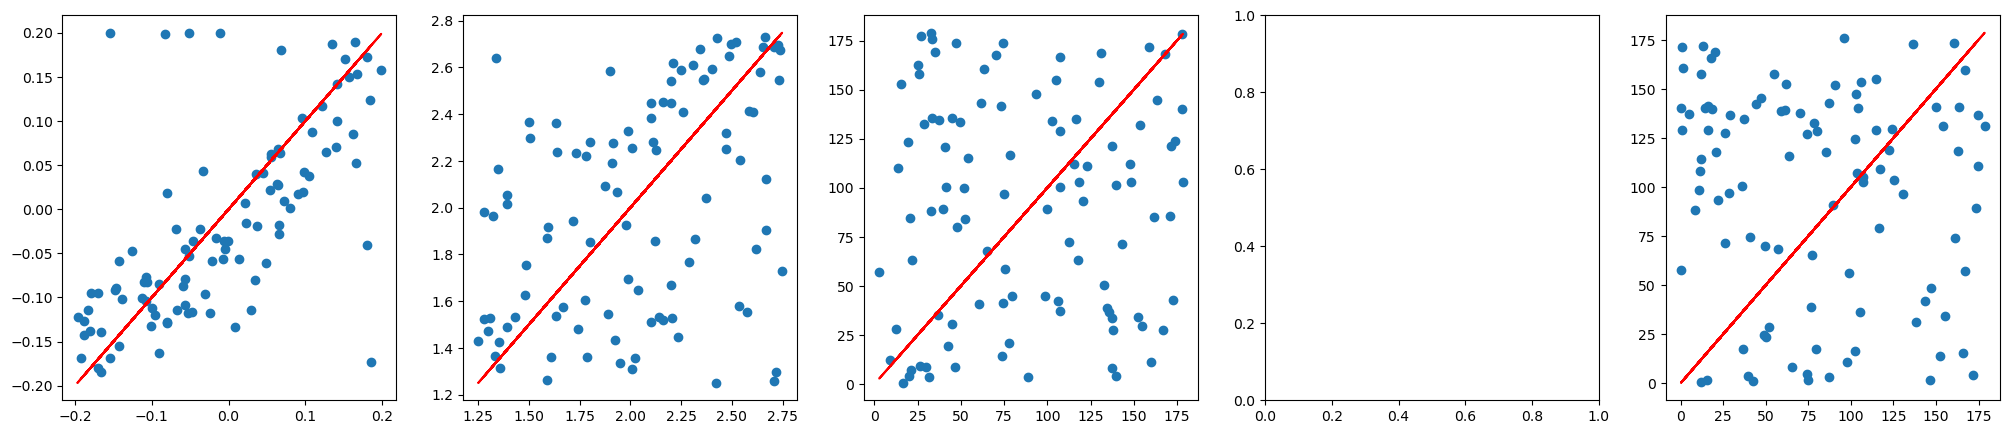

tensor(0.4698, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.2943, -0.4824,  0.4351,  0.2787,  0.5591],
       grad_fn=<SelectBackward0>)


 33%|███▎      | 33/100 [06:41<13:29, 12.08s/it]

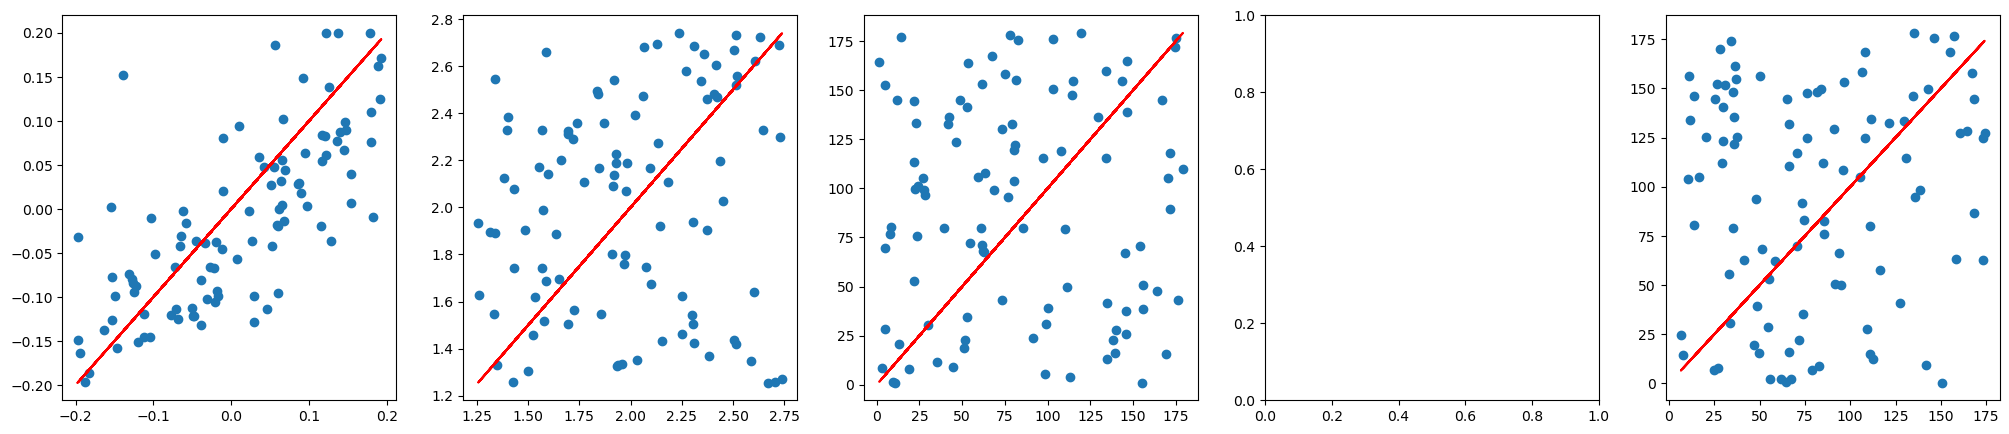

tensor(0.4575, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.6103, -0.5796, -0.6023, -0.5712, -0.4087],
       grad_fn=<SelectBackward0>)


 34%|███▍      | 34/100 [06:53<13:18, 12.10s/it]

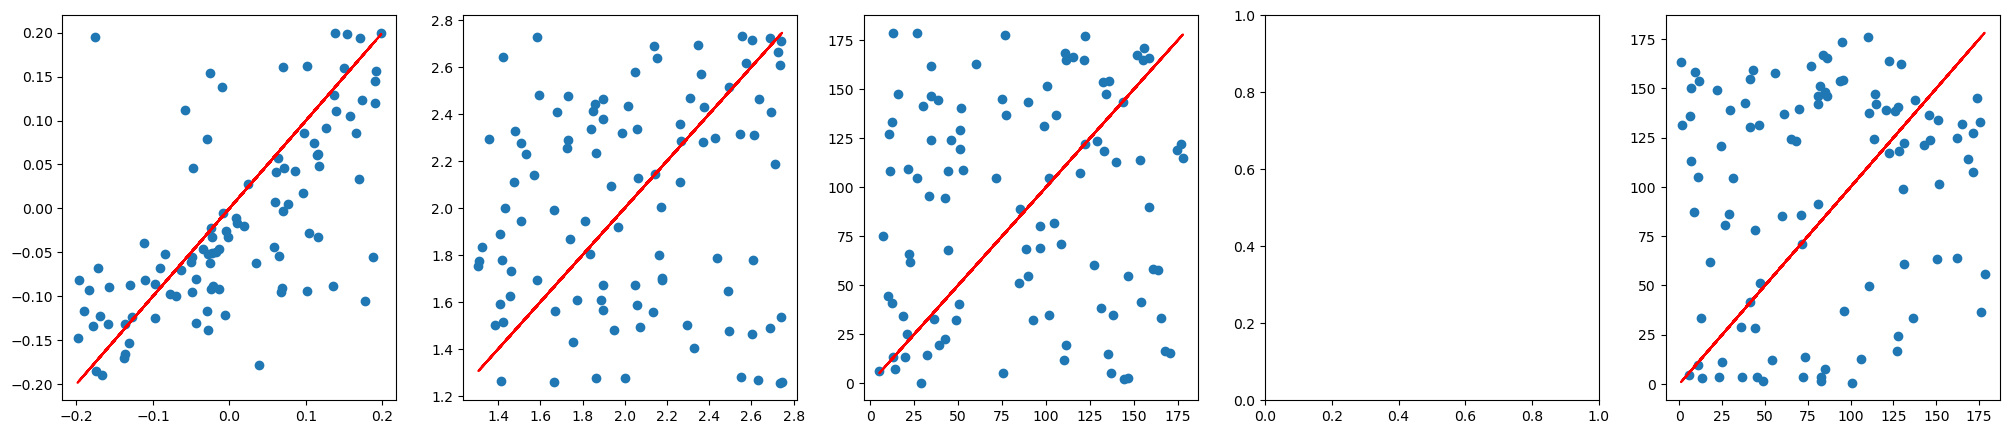

tensor(0.4800, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.7659, -0.9565, -0.9626, -0.9741, -0.9484],
       grad_fn=<SelectBackward0>)


 35%|███▌      | 35/100 [07:06<13:12, 12.18s/it]

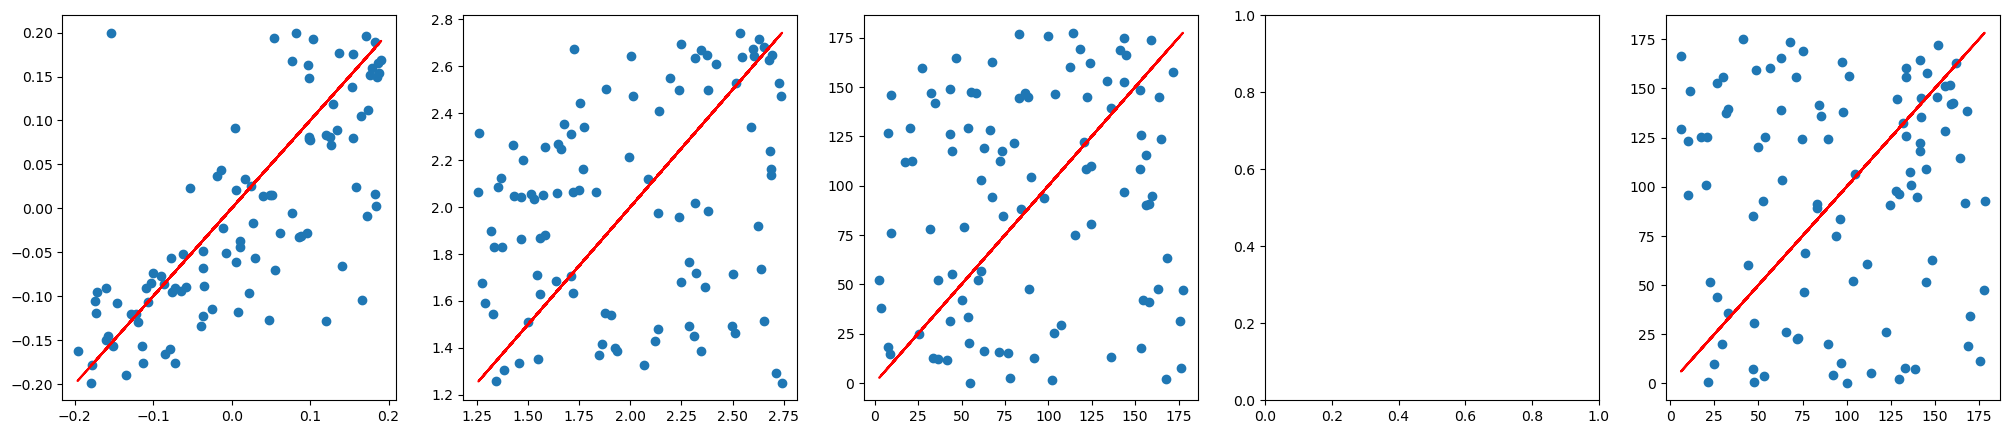

tensor(0.4402, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.4013, -0.0741,  0.4125,  0.6129,  0.5497],
       grad_fn=<SelectBackward0>)


 36%|███▌      | 36/100 [07:18<12:56, 12.13s/it]

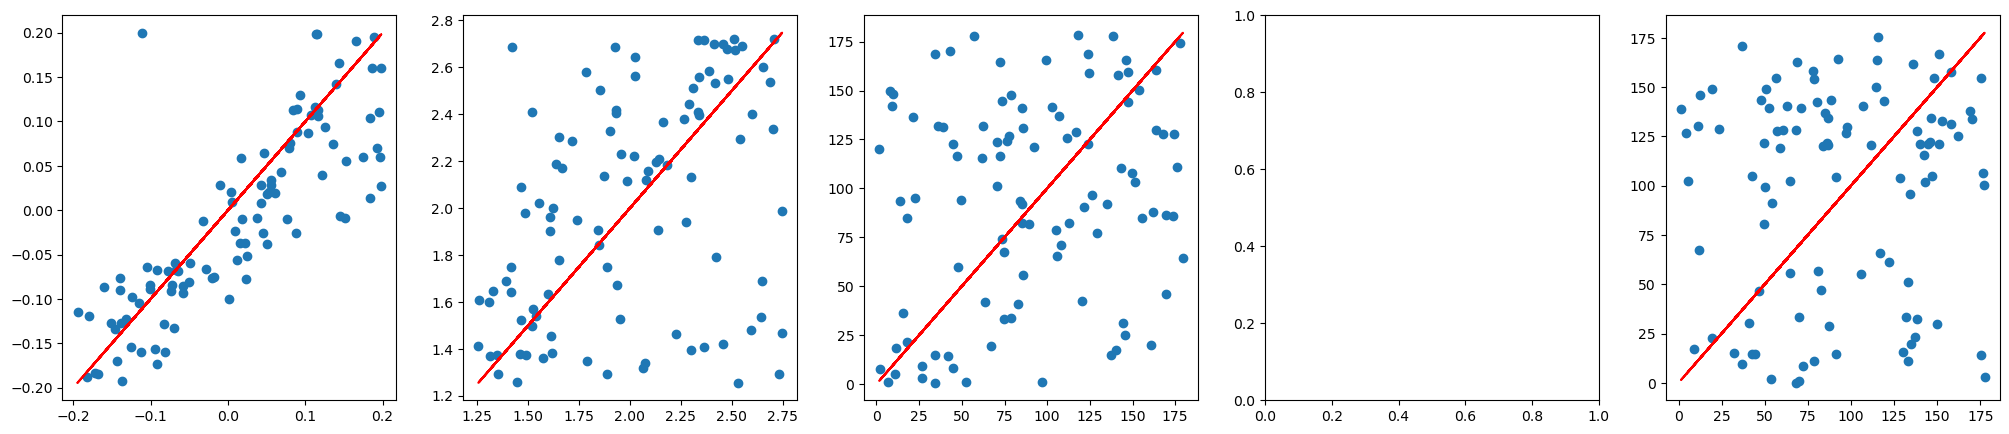

tensor(0.3793, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.3000,  0.4217,  0.3082,  0.4529,  0.5466],
       grad_fn=<SelectBackward0>)


 37%|███▋      | 37/100 [07:31<13:00, 12.40s/it]

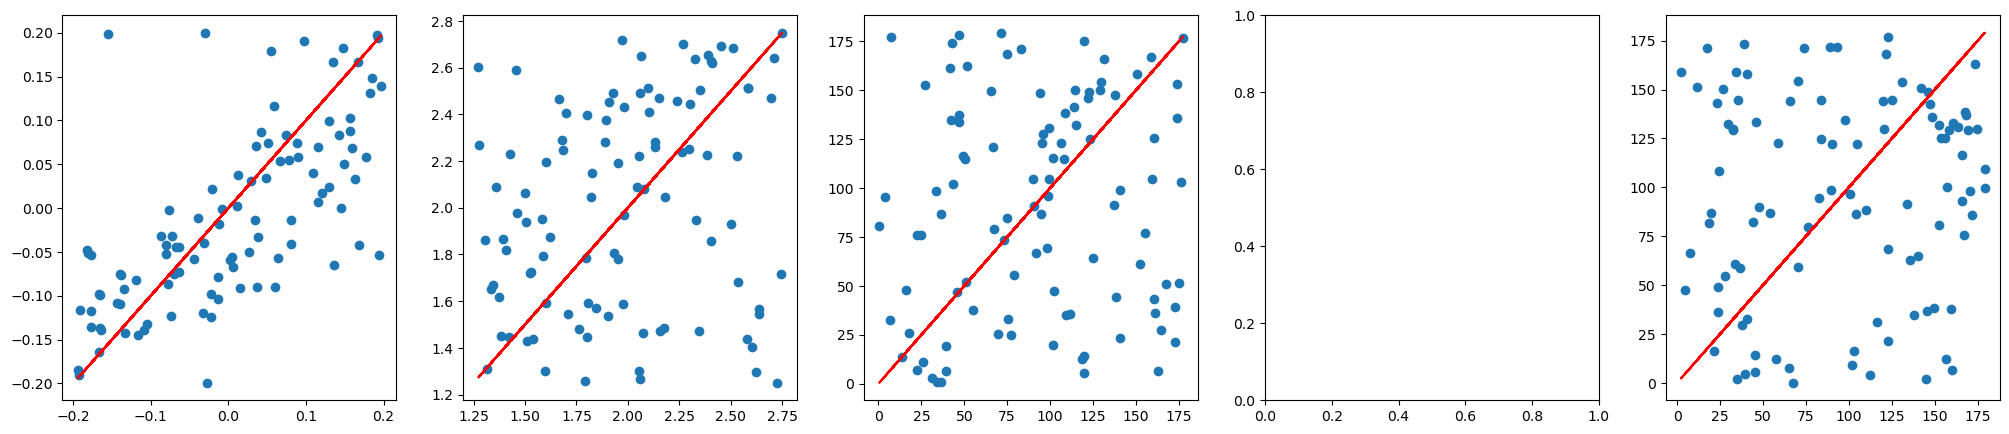

tensor(0.4398, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.5989, -0.7424, -0.7509, -0.9303, -0.9379],
       grad_fn=<SelectBackward0>)


 38%|███▊      | 38/100 [07:43<12:41, 12.29s/it]

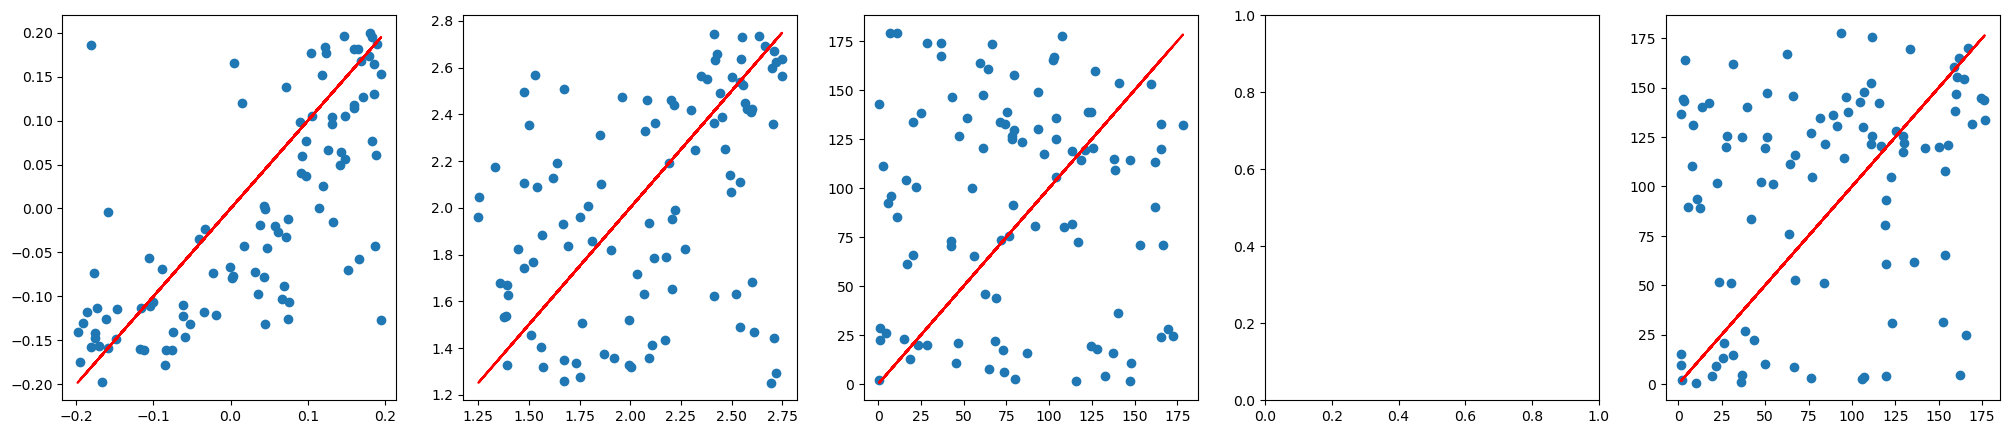

tensor(0.4379, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.6004, -0.7125, -0.4241, -0.7490, -0.0030],
       grad_fn=<SelectBackward0>)


 39%|███▉      | 39/100 [07:56<12:42, 12.50s/it]

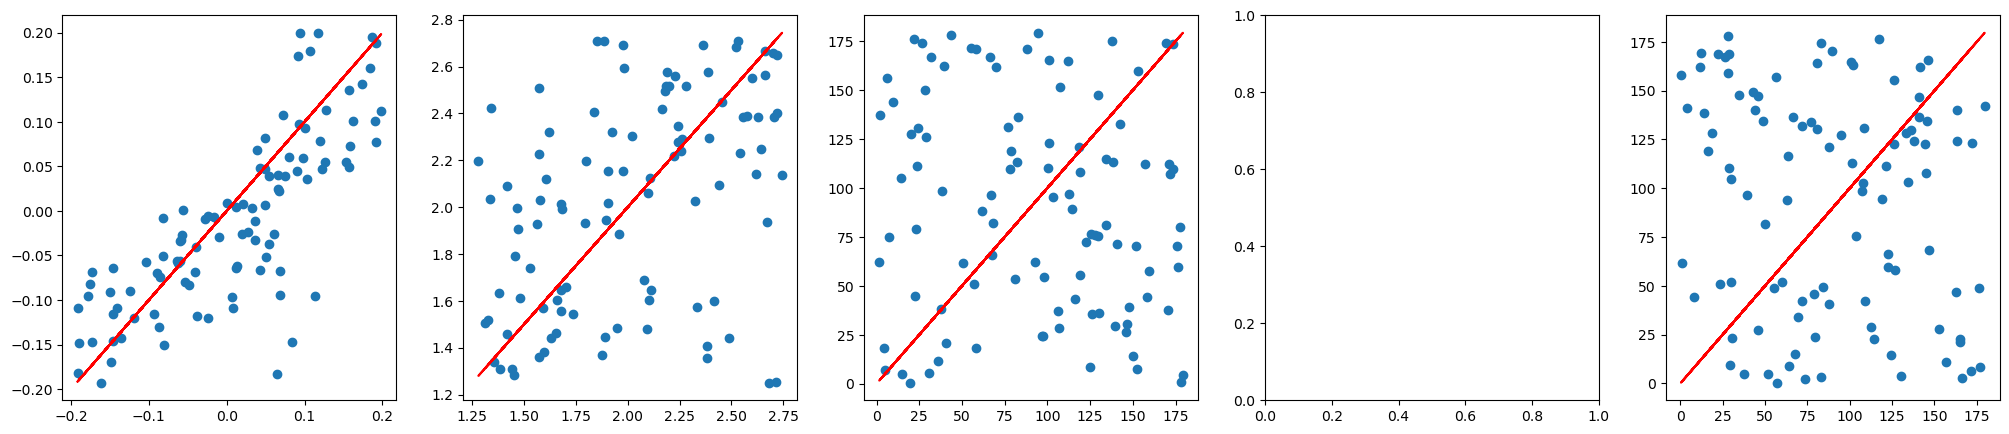

tensor(0.4793, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.1856, -0.4322, -0.7212, -0.3352, -0.1583],
       grad_fn=<SelectBackward0>)


 40%|████      | 40/100 [08:09<12:50, 12.84s/it]

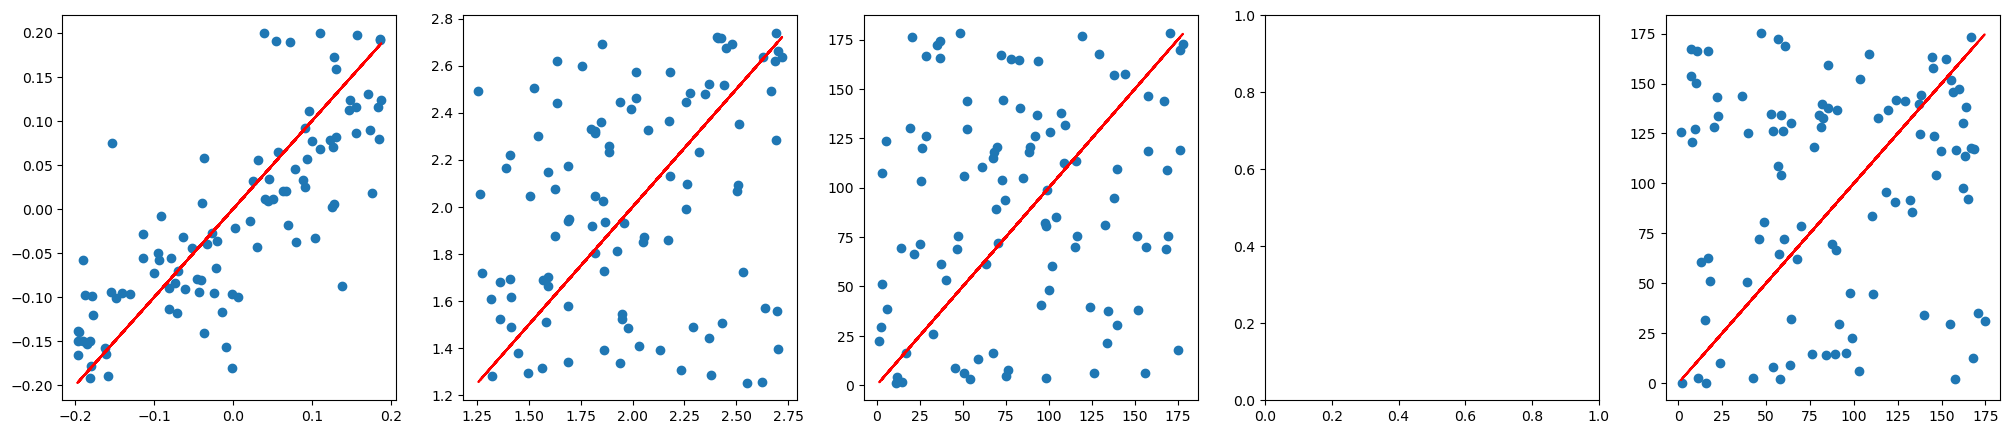

tensor(0.4212, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.4772,  0.6634,  0.1321, -0.0078, -0.1995],
       grad_fn=<SelectBackward0>)


 41%|████      | 41/100 [08:22<12:38, 12.86s/it]

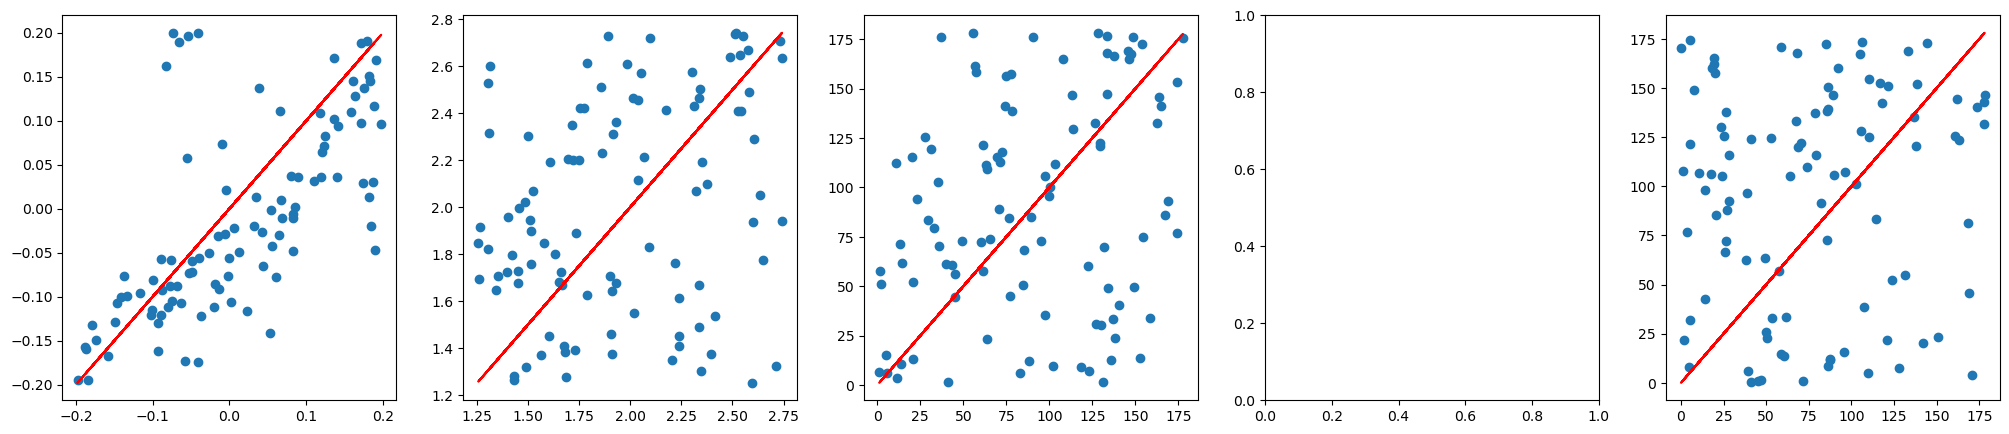

tensor(0.4331, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.1572, -0.9777, -0.9554, -0.1879,  0.3851],
       grad_fn=<SelectBackward0>)


 42%|████▏     | 42/100 [08:35<12:26, 12.87s/it]

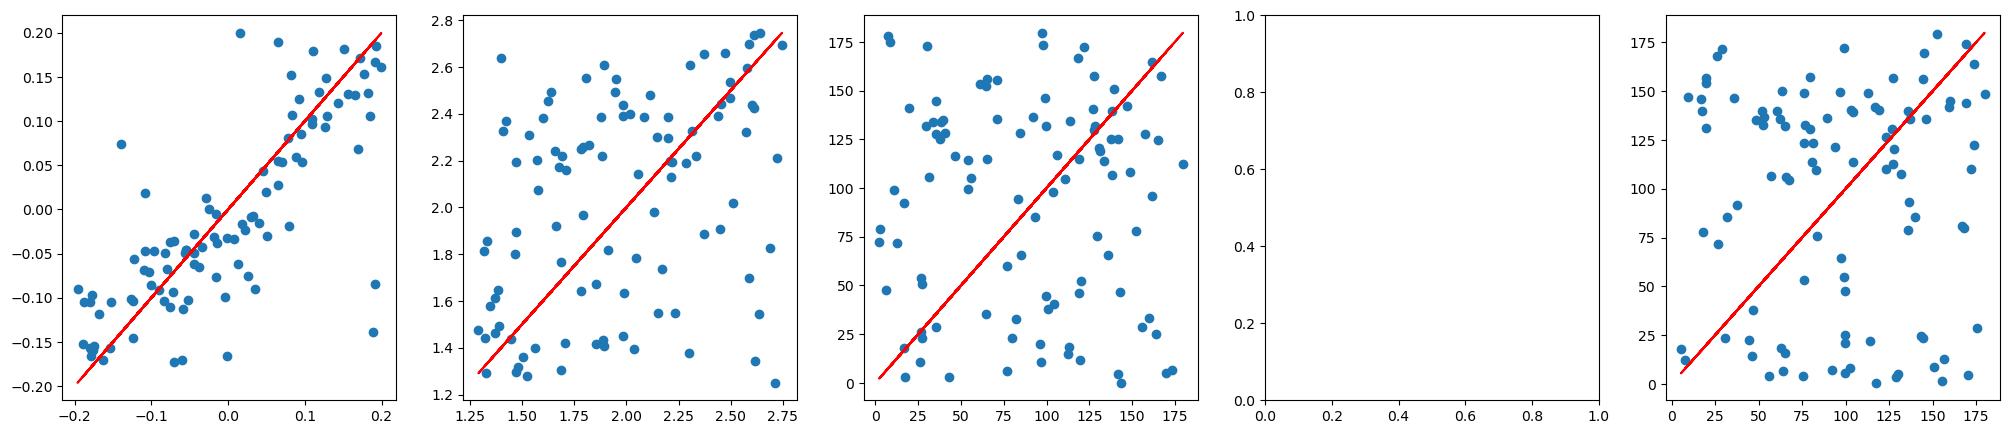

tensor(0.4310, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.2742, -0.3464,  0.3454,  0.4197,  0.5536],
       grad_fn=<SelectBackward0>)


 43%|████▎     | 43/100 [08:48<12:14, 12.89s/it]

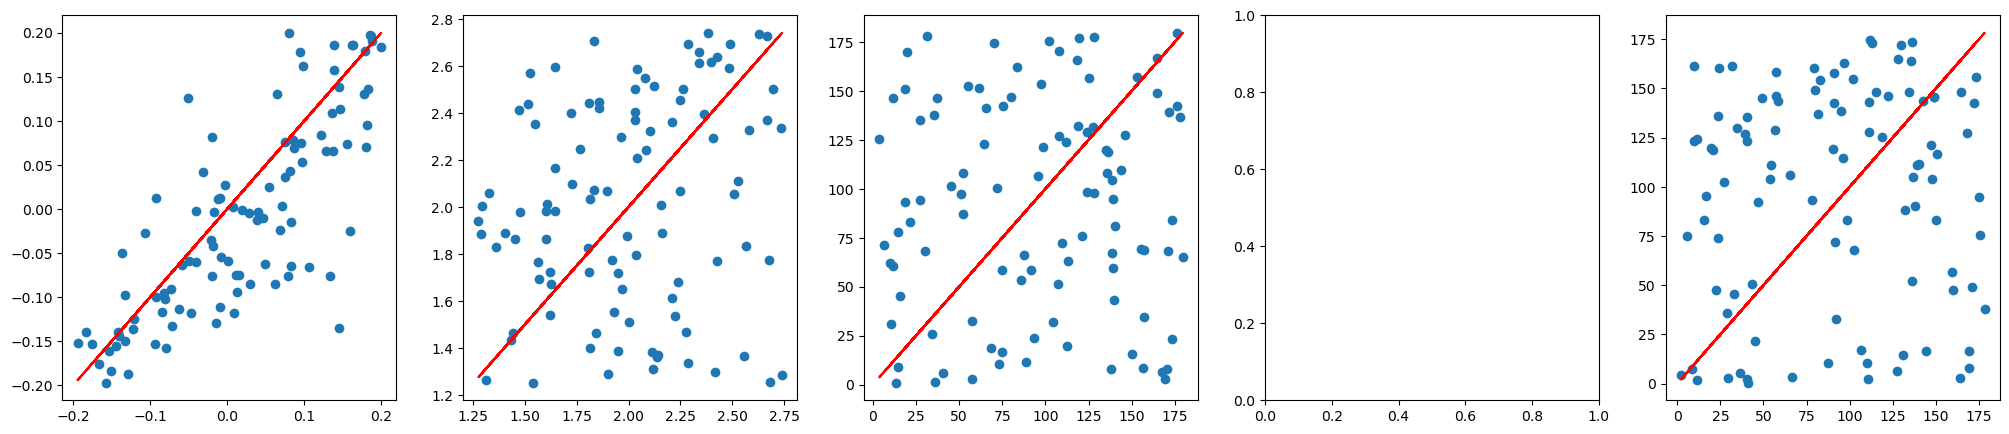

tensor(0.4422, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.2137, -0.4803, -0.1469, -0.0993,  0.0348],
       grad_fn=<SelectBackward0>)


 44%|████▍     | 44/100 [09:01<12:00, 12.86s/it]

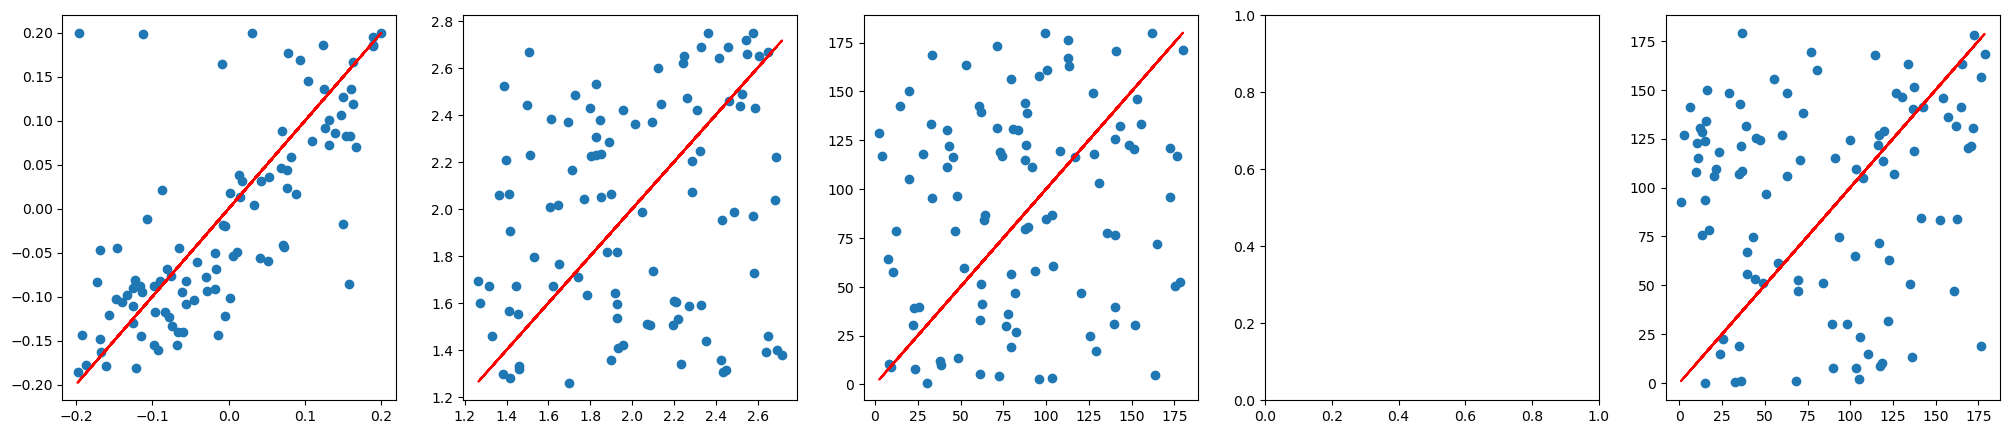

tensor(0.4279, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.7767,  0.8925,  0.6967, -0.3605, -0.4790],
       grad_fn=<SelectBackward0>)


 45%|████▌     | 45/100 [09:14<11:57, 13.05s/it]

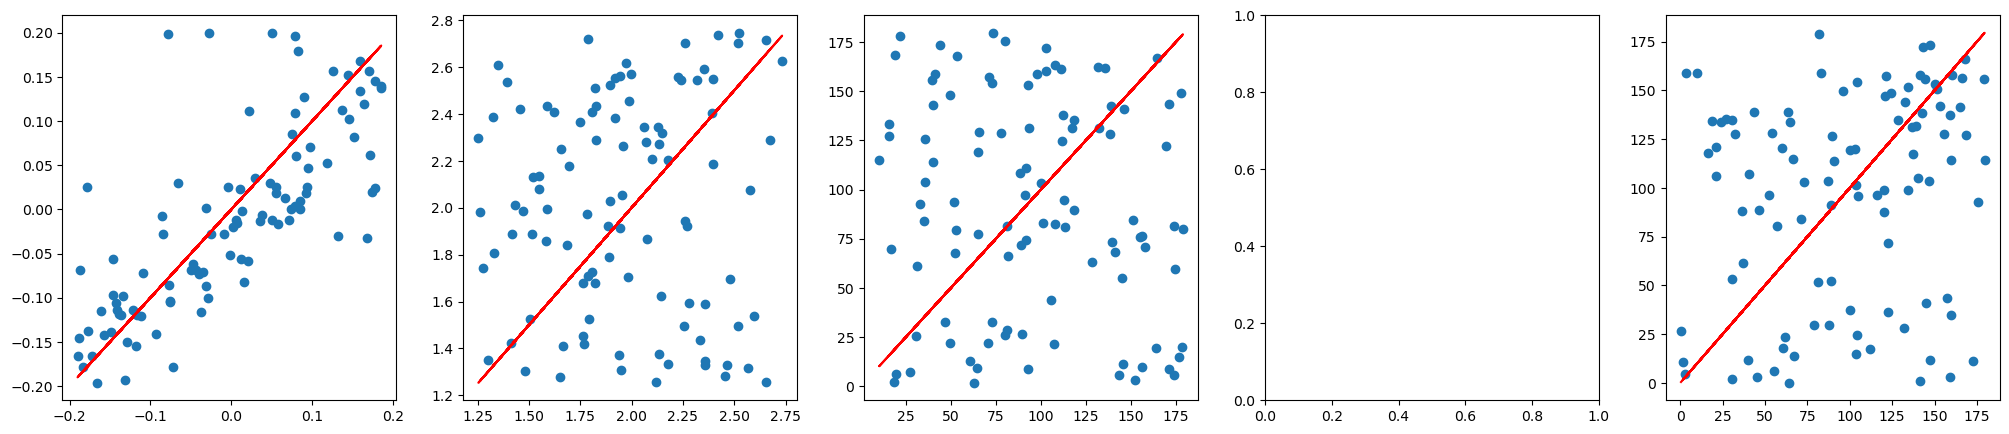

tensor(0.4462, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.1387, -0.1822, -0.6162, -0.5123, -0.7018],
       grad_fn=<SelectBackward0>)


 46%|████▌     | 46/100 [09:27<11:33, 12.85s/it]

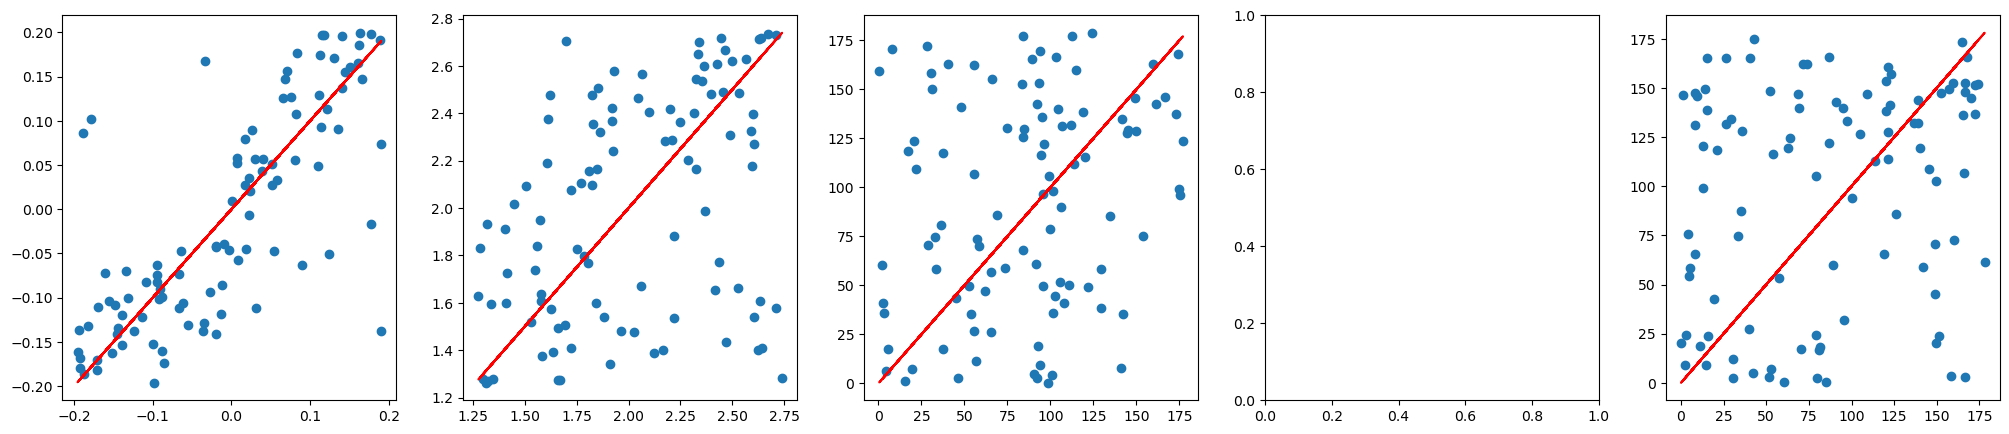

tensor(0.3836, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([0.0455, 0.1372, 0.8693, 0.8068, 0.8439], grad_fn=<SelectBackward0>)


 47%|████▋     | 47/100 [09:39<11:14, 12.73s/it]

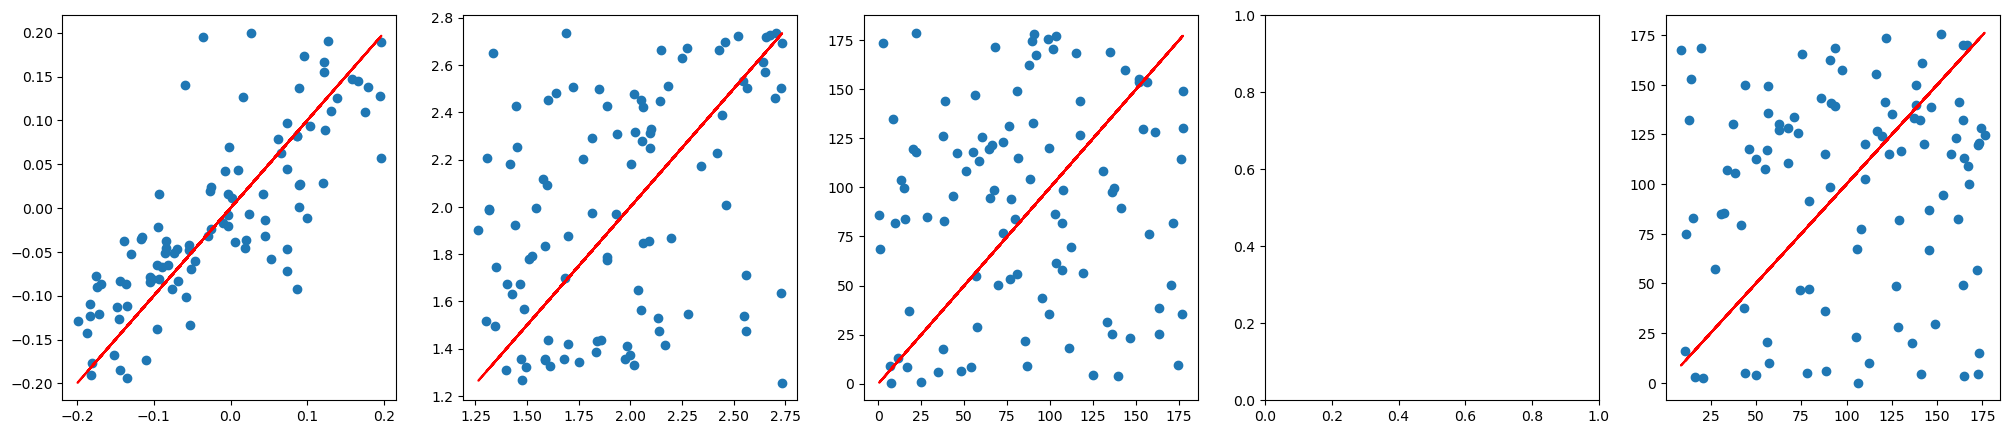

tensor(0.3968, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.9486, -0.1946,  0.9321,  0.9269,  0.9259],
       grad_fn=<SelectBackward0>)


 48%|████▊     | 48/100 [09:51<10:45, 12.42s/it]

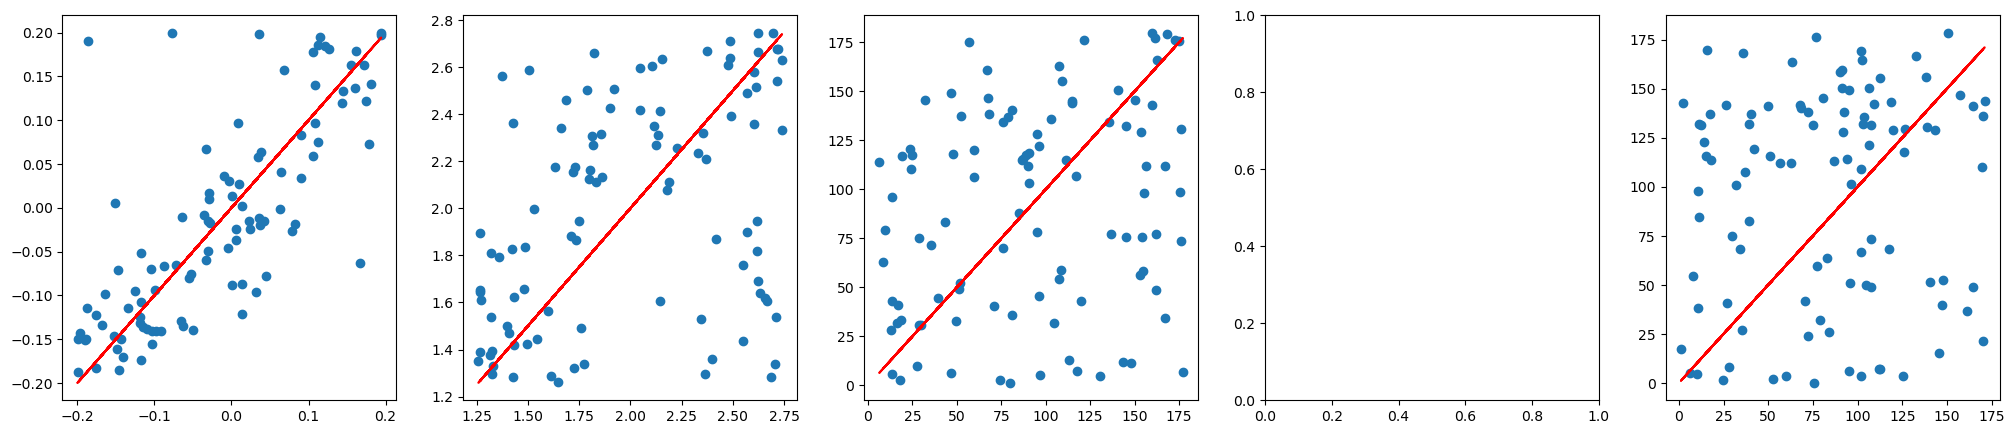

tensor(0.4037, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.3540, -0.1310, -0.5073, -0.6470, -0.7318],
       grad_fn=<SelectBackward0>)


 49%|████▉     | 49/100 [10:03<10:24, 12.24s/it]

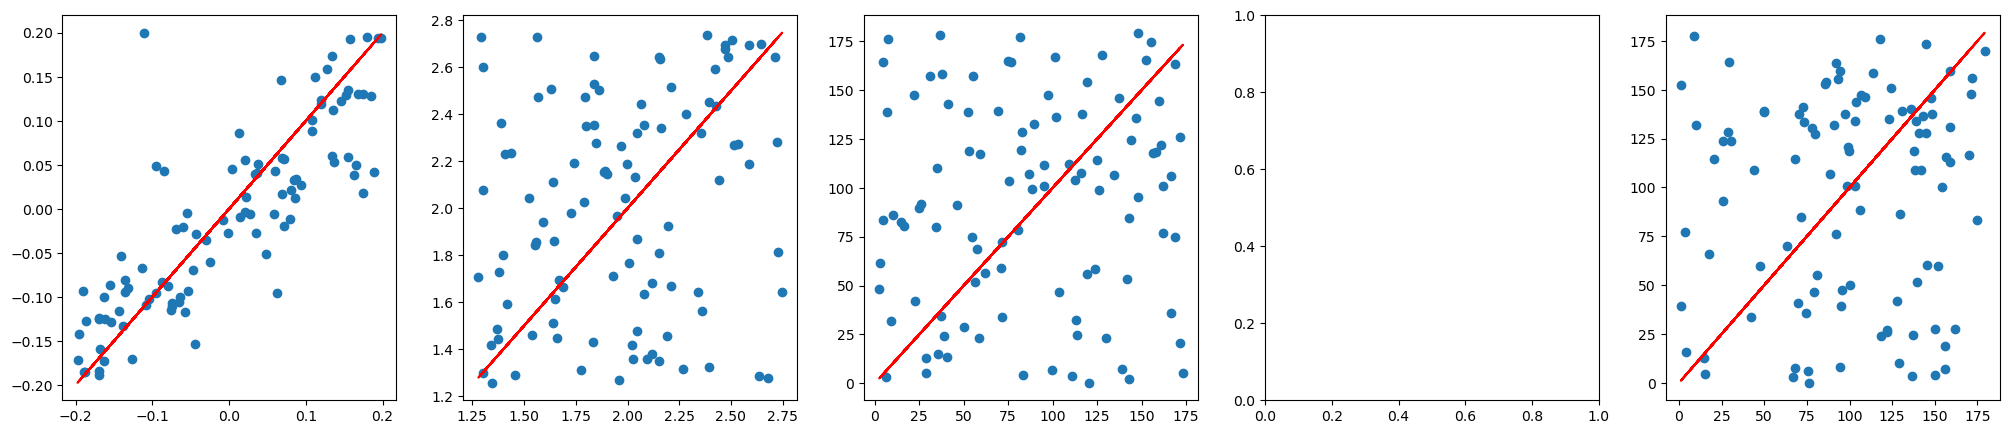

tensor(0.4123, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.6446, -0.9190, -0.9525, -0.9759, -0.8572],
       grad_fn=<SelectBackward0>)


 50%|█████     | 50/100 [10:15<10:15, 12.30s/it]

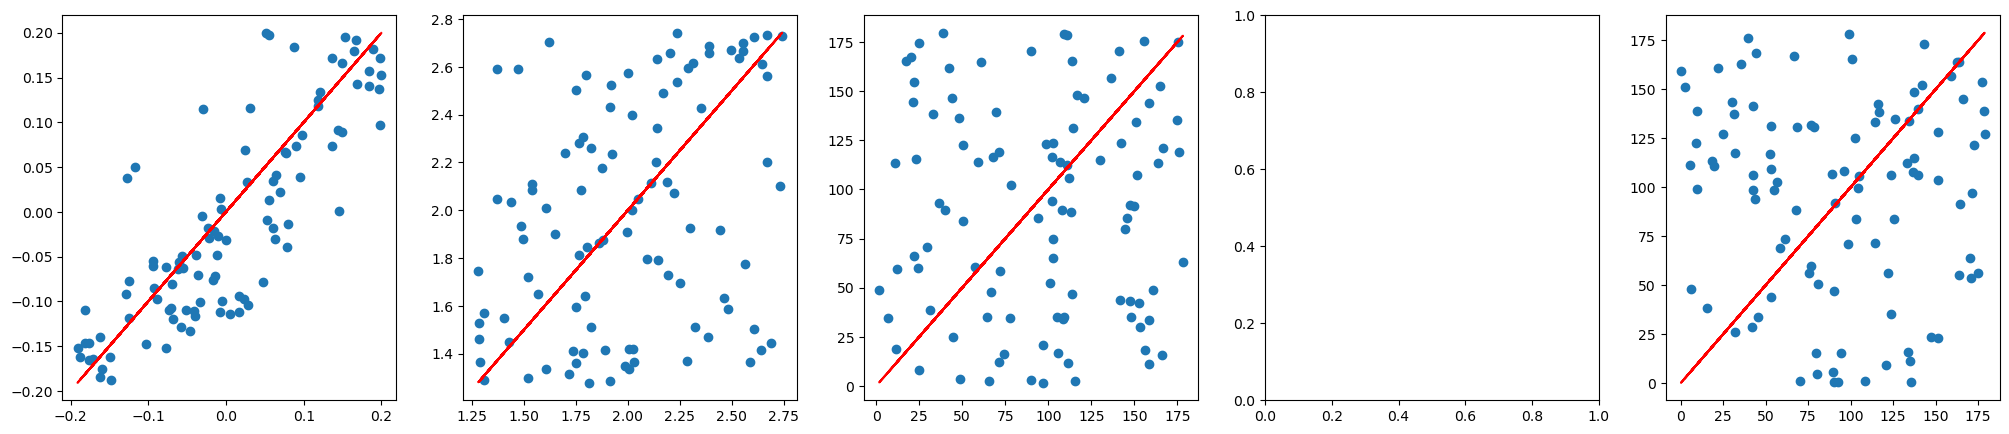

tensor(0.4279, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([0.7653, 0.5067, 0.8915, 0.9875, 0.9576], grad_fn=<SelectBackward0>)


 51%|█████     | 51/100 [10:27<09:58, 12.21s/it]

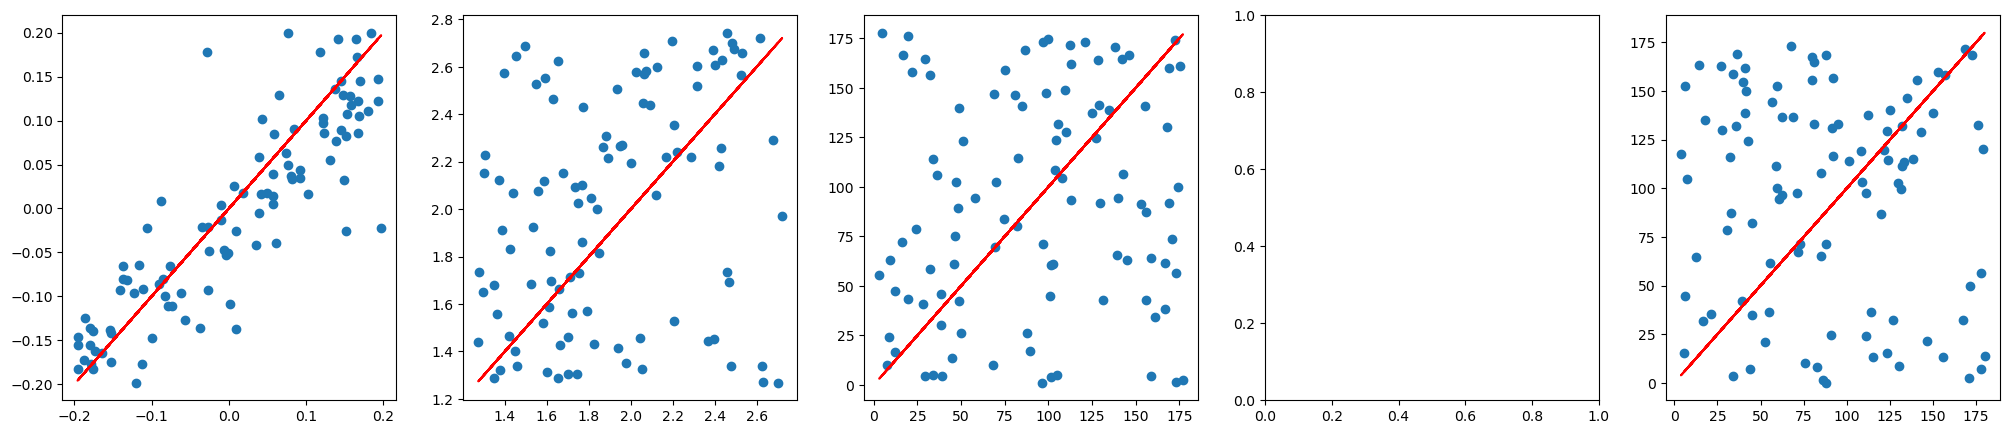

tensor(0.4250, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.2625, -0.6542,  0.0793,  0.0199,  0.4373],
       grad_fn=<SelectBackward0>)


 52%|█████▏    | 52/100 [10:39<09:38, 12.06s/it]

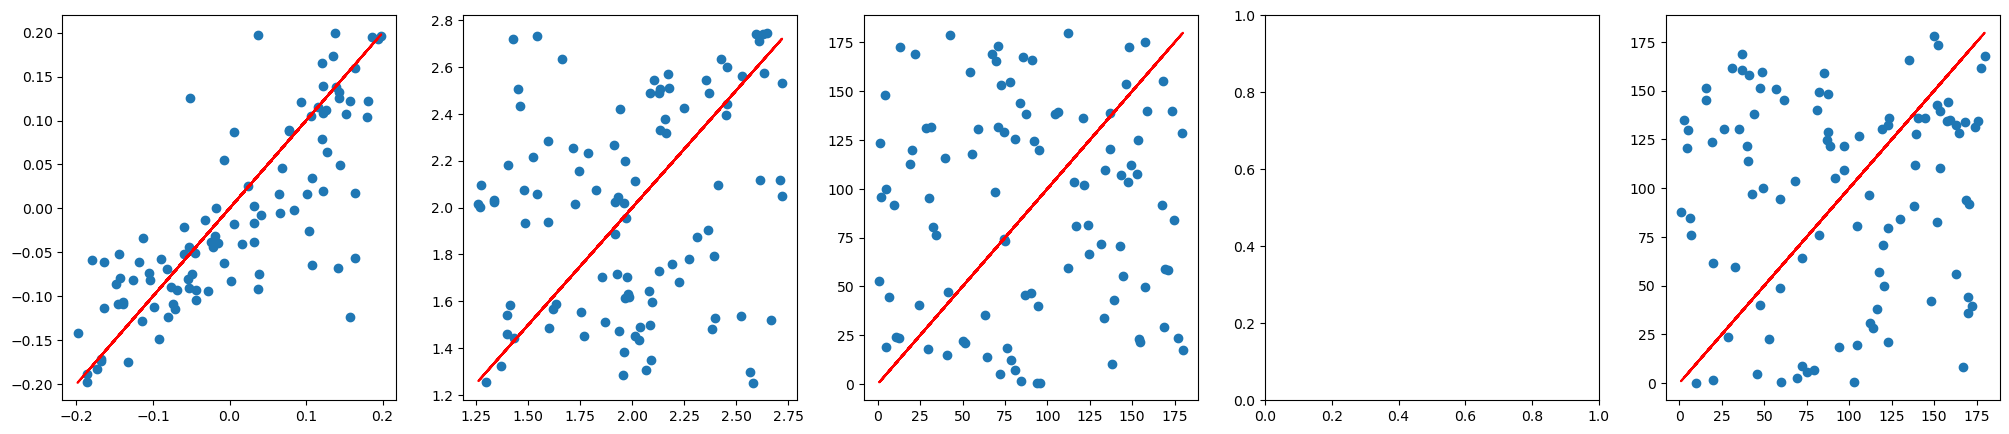

tensor(0.4326, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.5340, -0.6993, -0.7324, -0.8483, -0.7852],
       grad_fn=<SelectBackward0>)


 53%|█████▎    | 53/100 [10:51<09:23, 11.98s/it]

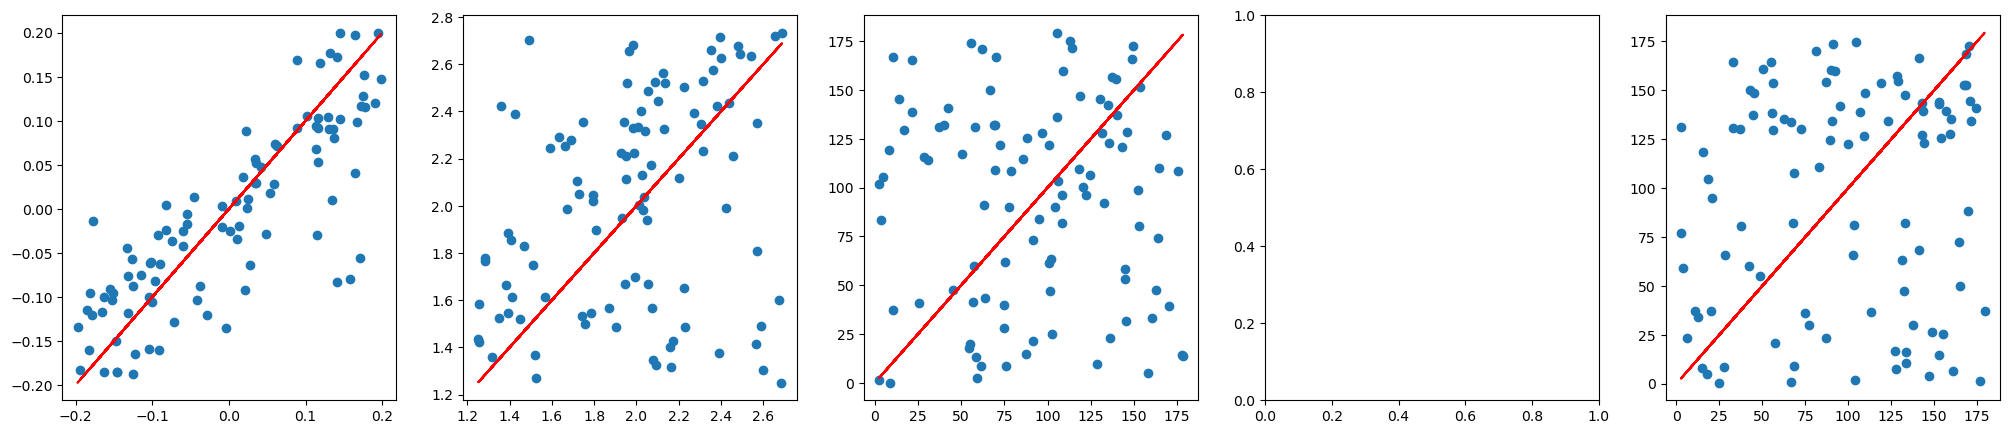

tensor(0.4038, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.2239, -0.5771, -0.6830, -0.7622, -0.6654],
       grad_fn=<SelectBackward0>)


 54%|█████▍    | 54/100 [11:03<09:14, 12.05s/it]

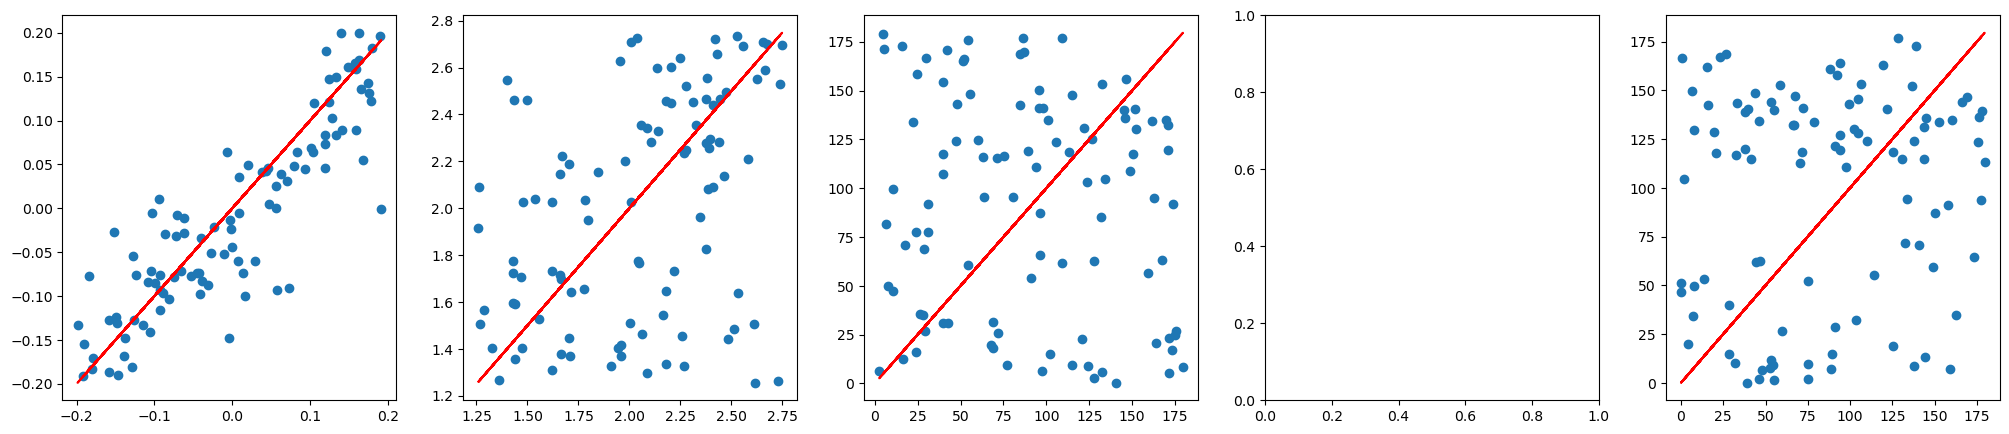

tensor(0.4287, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.0515, -0.6352, -0.4848, -0.6043, -0.3098],
       grad_fn=<SelectBackward0>)


 55%|█████▌    | 55/100 [11:15<09:05, 12.13s/it]

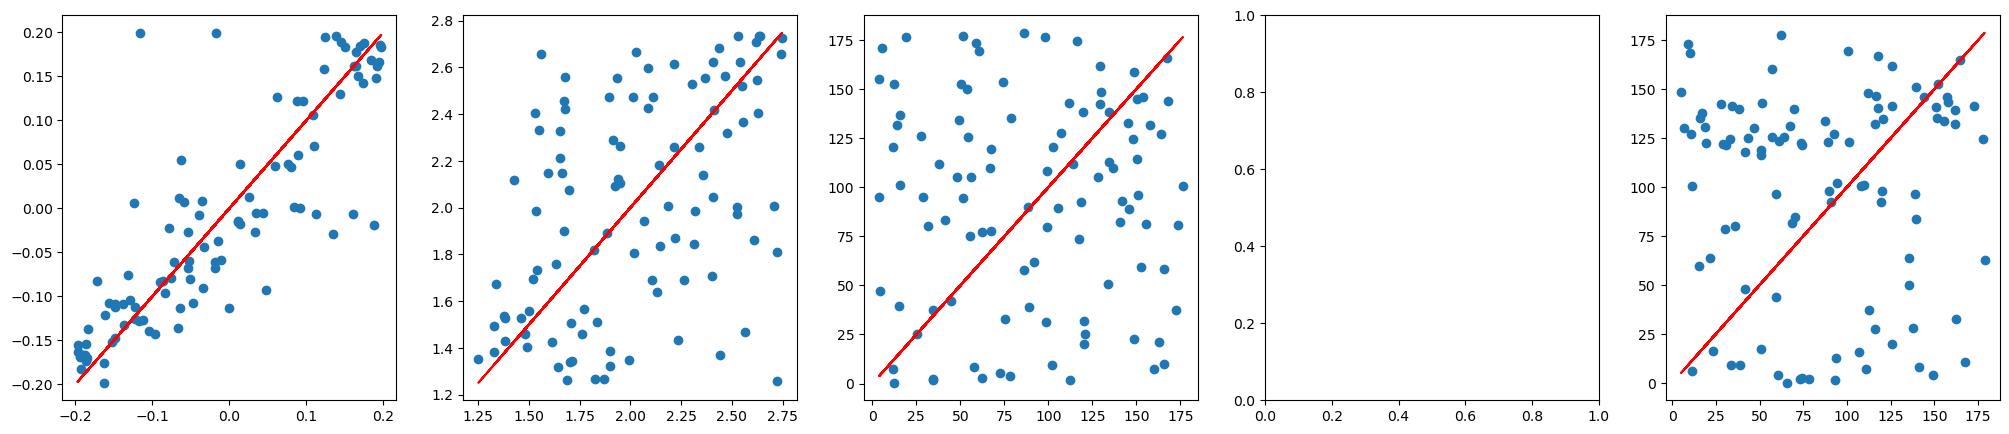

tensor(0.4016, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([0.8340, 0.1983, 0.6108, 0.8412, 0.6441], grad_fn=<SelectBackward0>)


 56%|█████▌    | 56/100 [11:27<08:48, 12.01s/it]

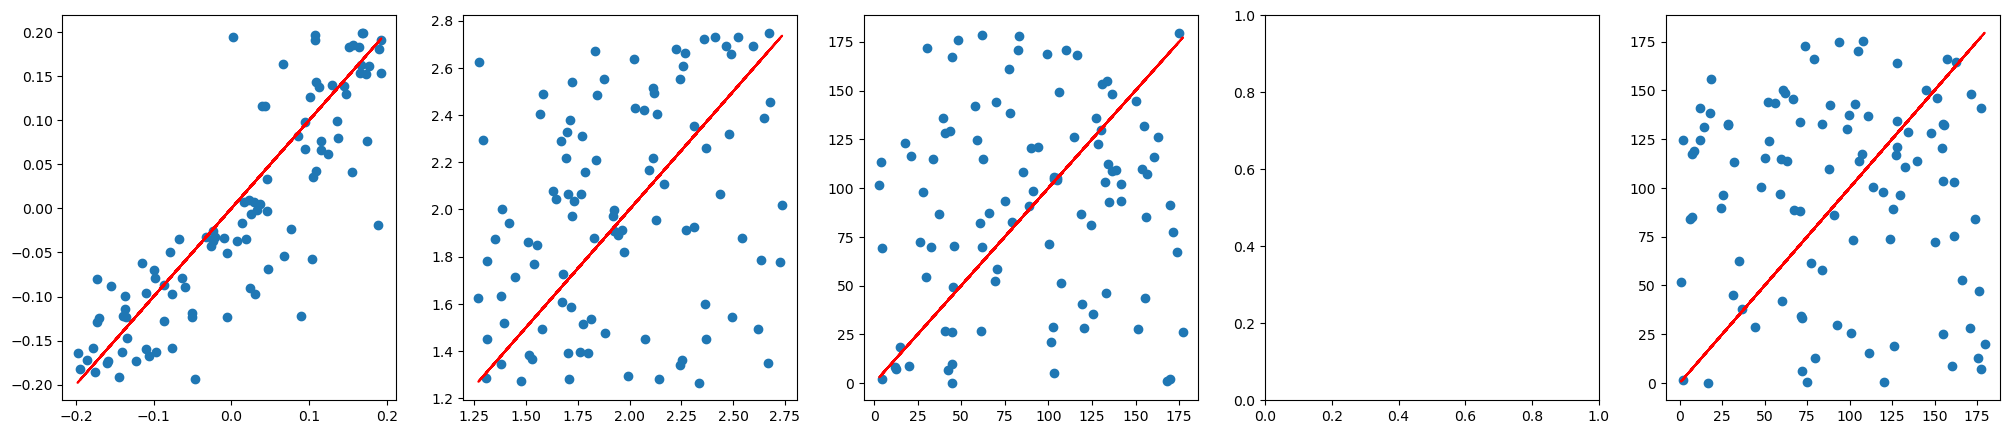

tensor(0.3963, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.6326, -0.2082, -0.1168,  0.1350,  0.0756],
       grad_fn=<SelectBackward0>)


 57%|█████▋    | 57/100 [11:39<08:33, 11.94s/it]

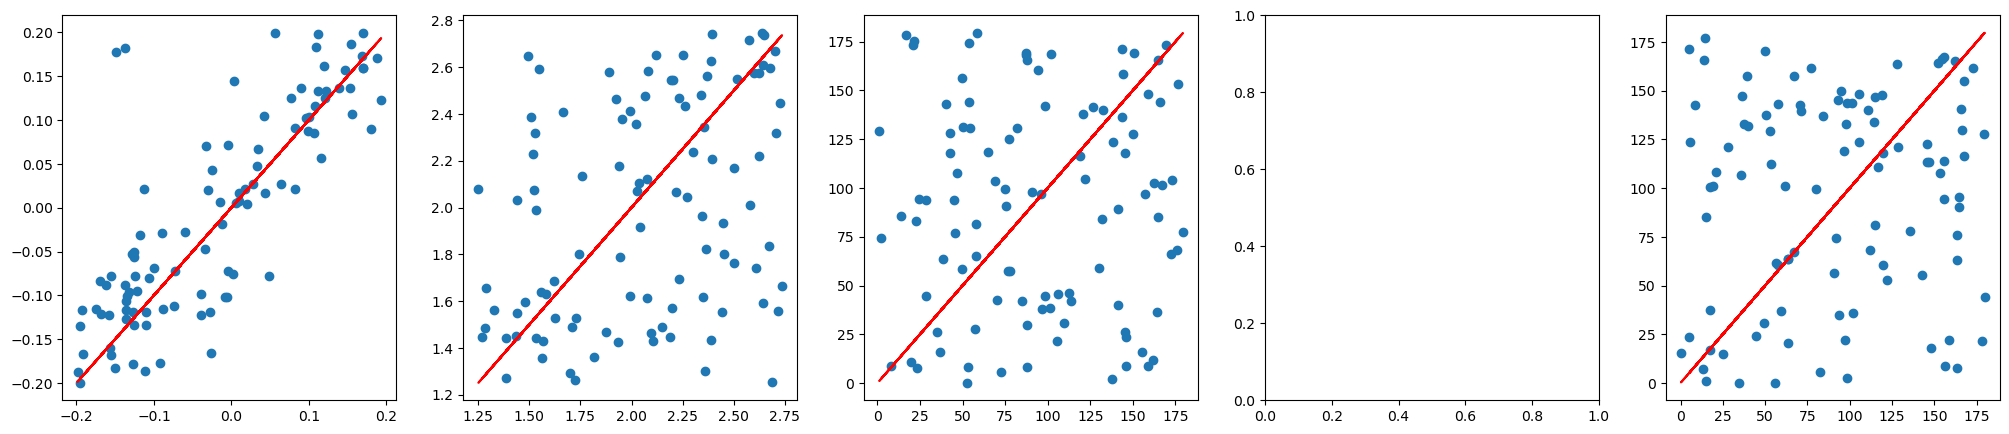

tensor(0.4049, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.8334,  0.9020,  0.6222, -0.0633, -0.6147],
       grad_fn=<SelectBackward0>)


 58%|█████▊    | 58/100 [11:51<08:23, 11.99s/it]

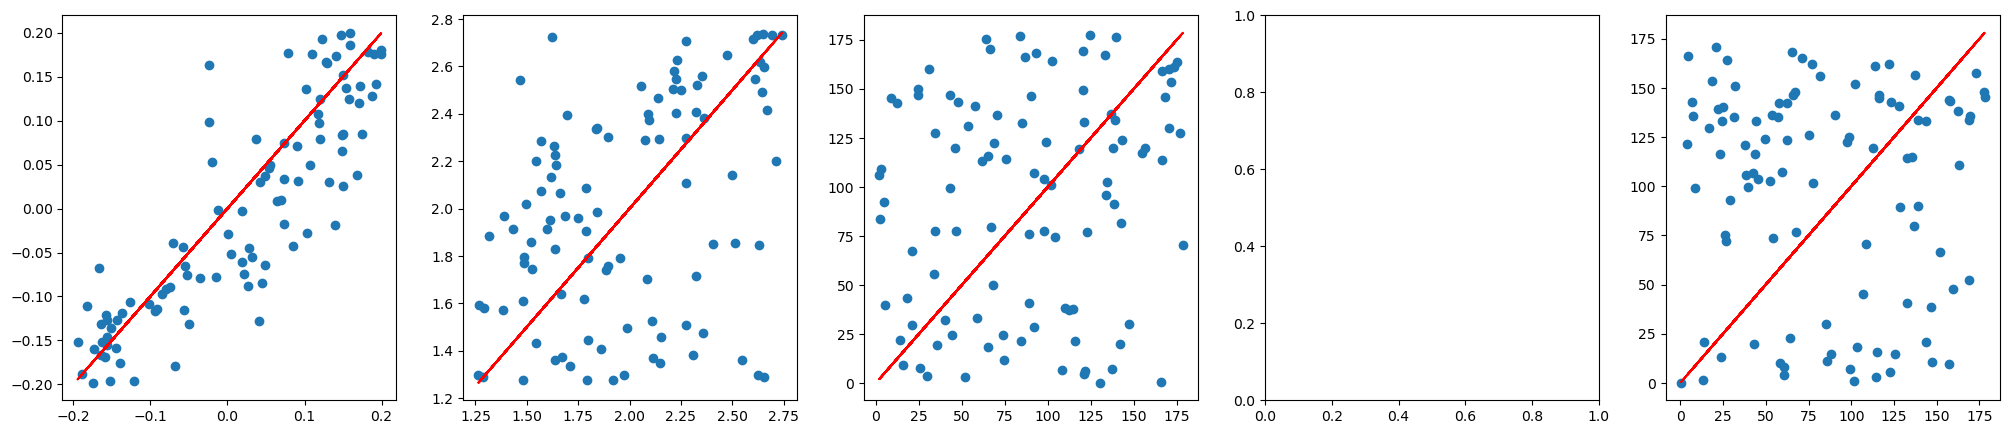

tensor(0.3997, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([0.4840, 0.3501, 0.8663, 0.8793, 0.8358], grad_fn=<SelectBackward0>)


 59%|█████▉    | 59/100 [12:03<08:14, 12.07s/it]

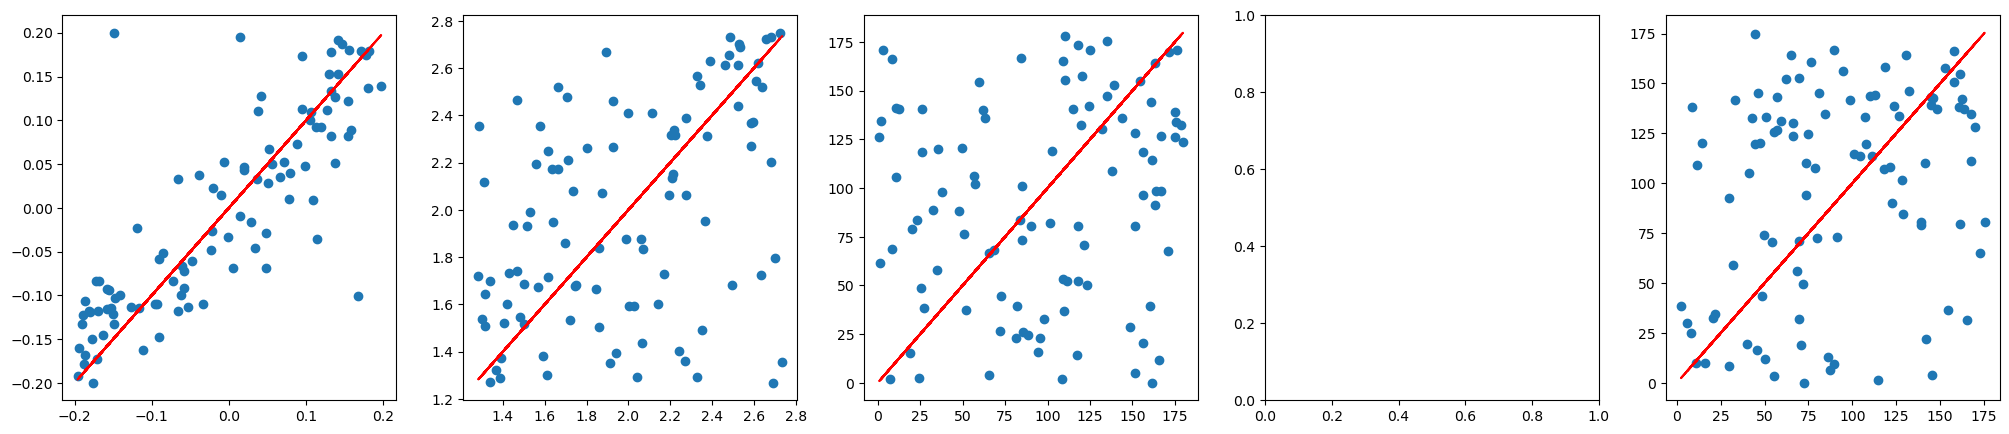

tensor(0.3507, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.5660, -0.6447, -0.5451, -0.5642, -0.2121],
       grad_fn=<SelectBackward0>)


 60%|██████    | 60/100 [12:15<08:07, 12.18s/it]

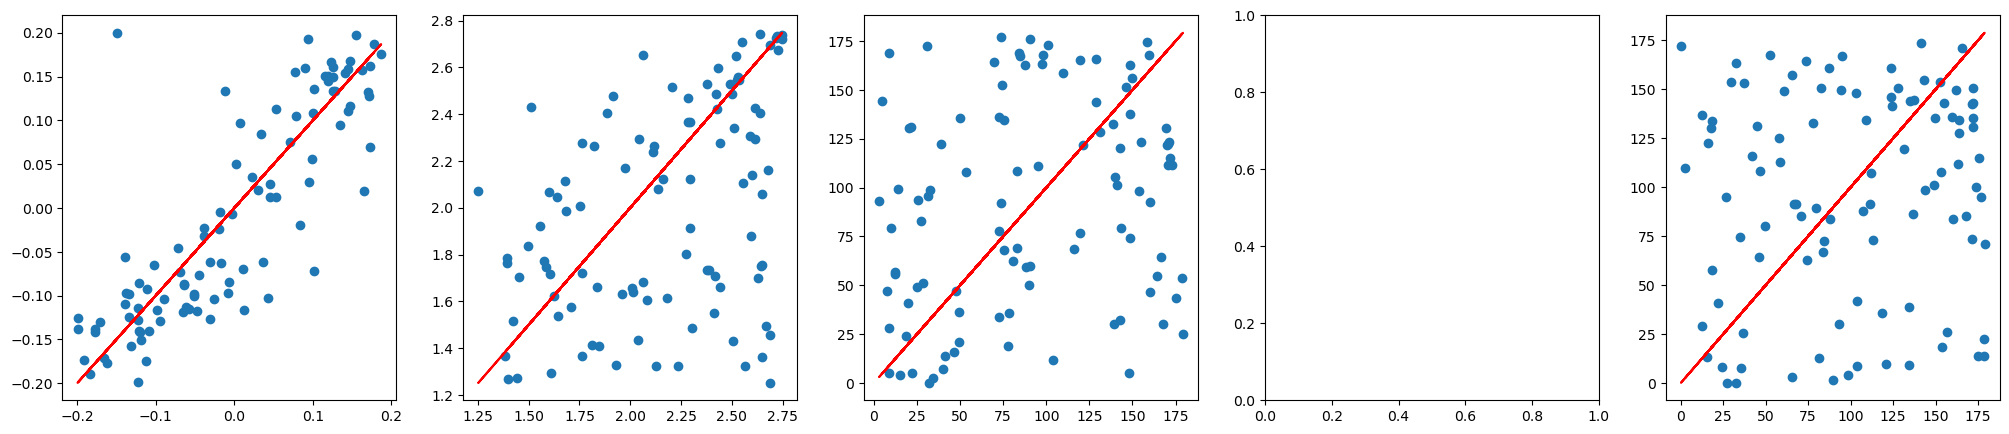

tensor(0.3856, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.2272,  0.7193,  0.3920,  0.3707,  0.4189],
       grad_fn=<SelectBackward0>)


 61%|██████    | 61/100 [12:28<07:53, 12.14s/it]

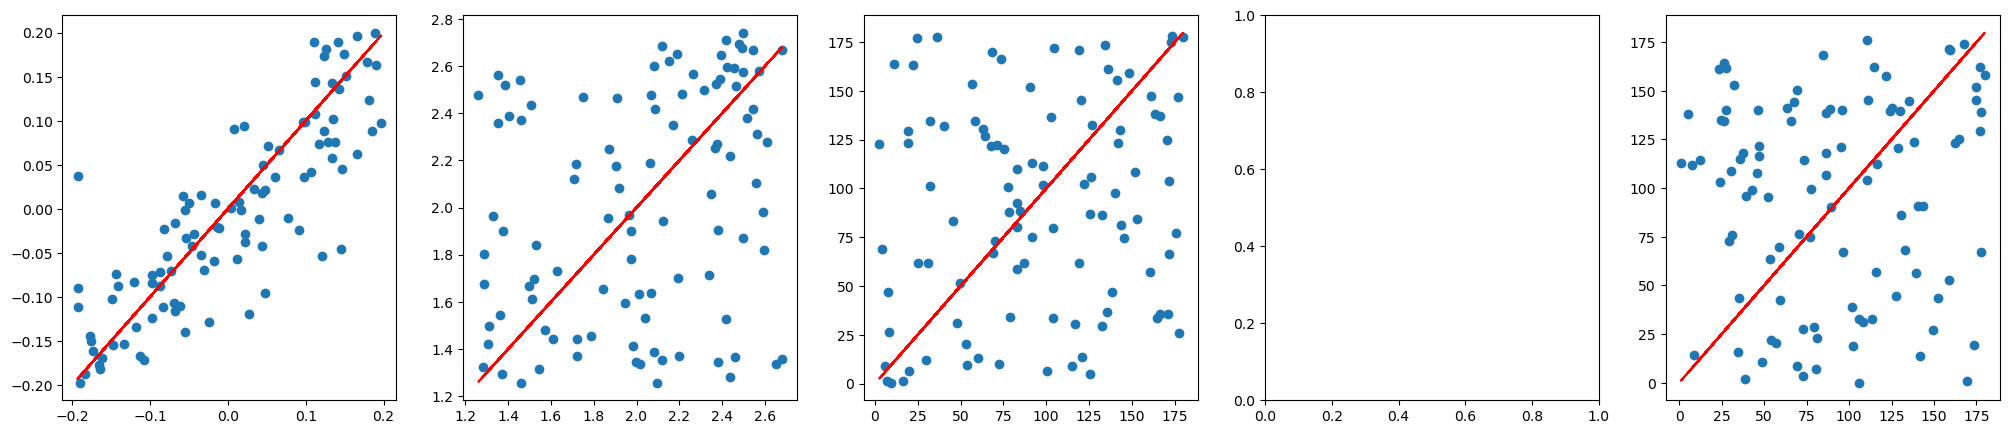

tensor(0.3965, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.1628, -0.0508,  0.7264,  0.4402,  0.5520],
       grad_fn=<SelectBackward0>)


 62%|██████▏   | 62/100 [12:40<07:40, 12.11s/it]

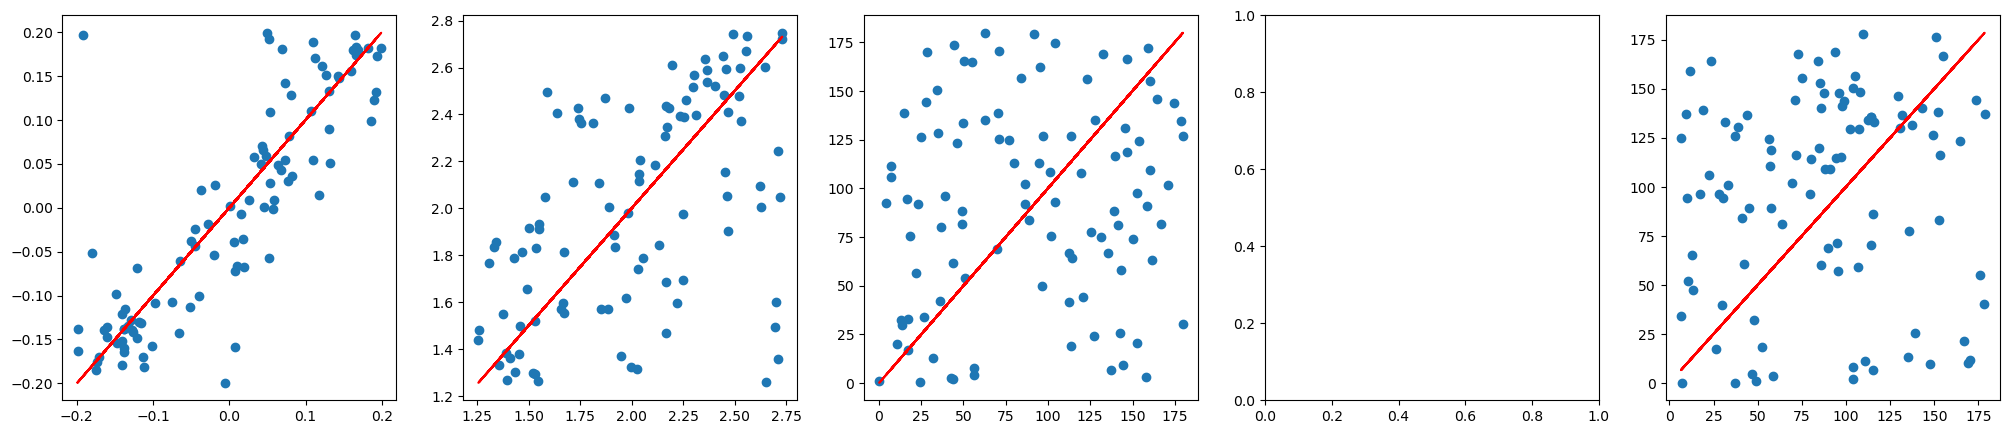

tensor(0.3573, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.6530, -0.3900, -0.4603, -0.7703, -0.8940],
       grad_fn=<SelectBackward0>)


 63%|██████▎   | 63/100 [12:51<07:25, 12.05s/it]

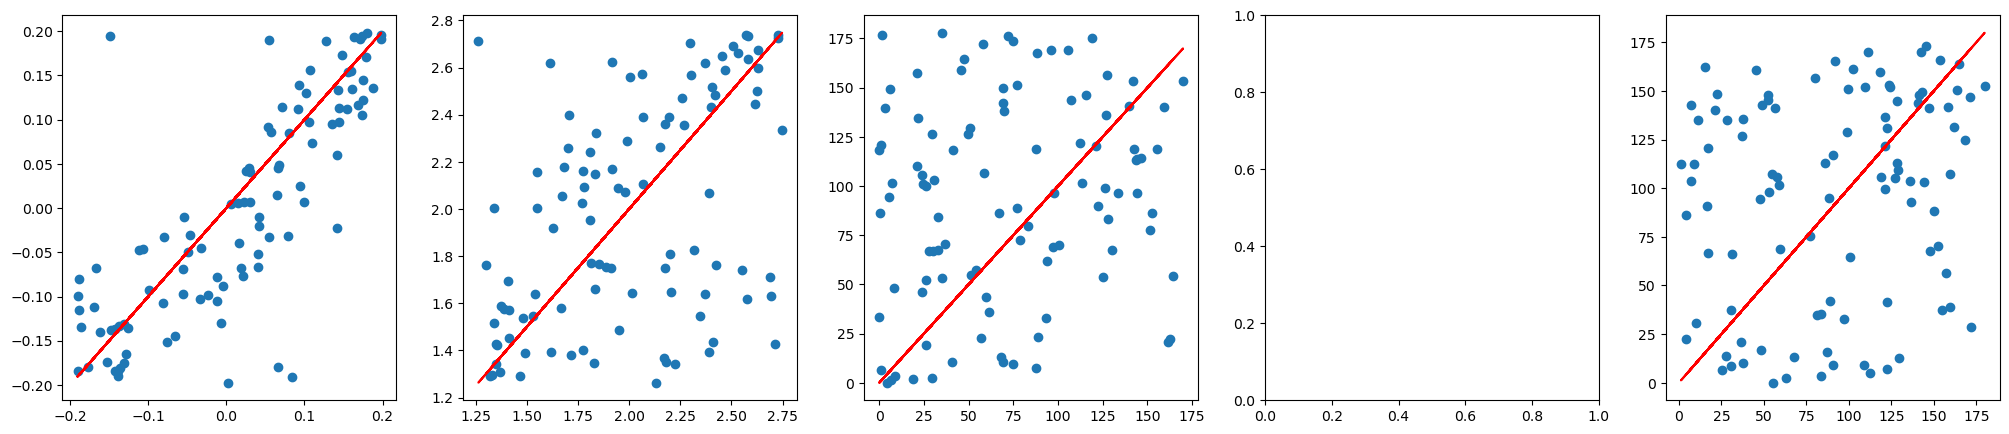

tensor(0.3670, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.7809, -0.5701,  0.5937, -0.0742,  0.0067],
       grad_fn=<SelectBackward0>)


 64%|██████▍   | 64/100 [13:03<07:10, 11.97s/it]

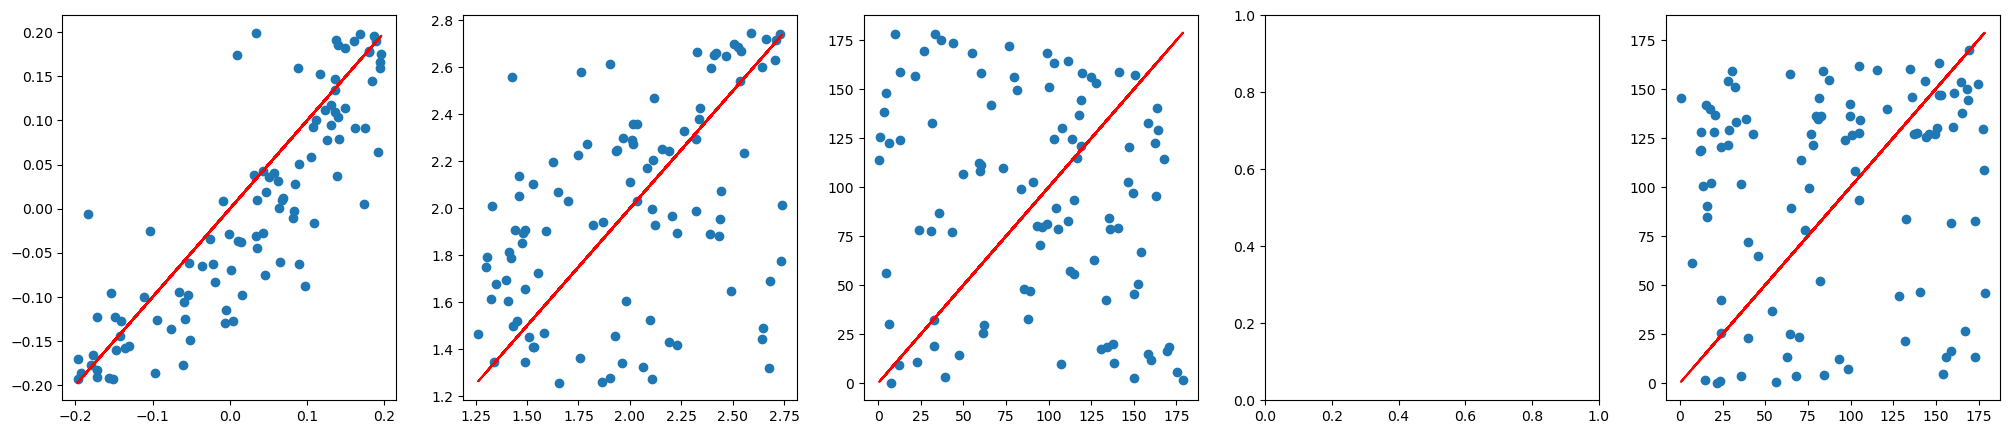

tensor(0.4430, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.6369, -0.7353, -0.5247, -0.4978, -0.0944],
       grad_fn=<SelectBackward0>)


 65%|██████▌   | 65/100 [13:15<06:58, 11.96s/it]

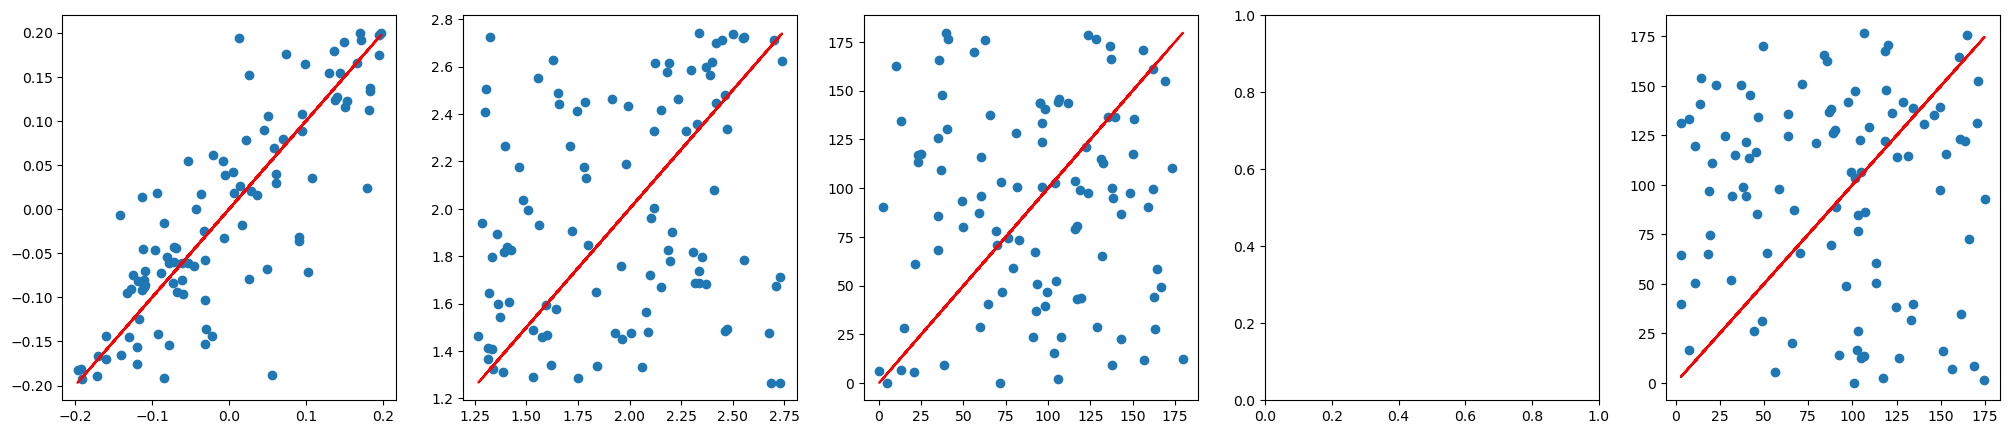

tensor(0.4068, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([0.9863, 0.7230, 0.9903, 0.9939, 0.9649], grad_fn=<SelectBackward0>)


 66%|██████▌   | 66/100 [13:27<06:44, 11.90s/it]

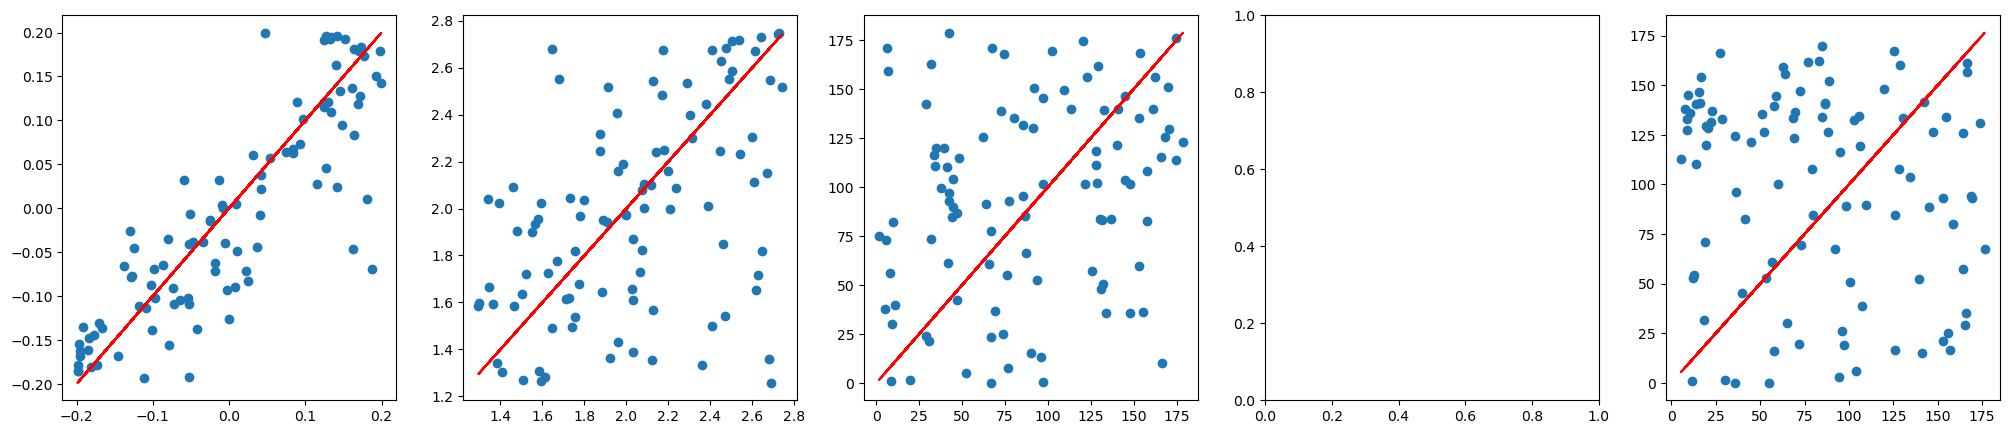

tensor(0.3631, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.3092,  0.3905,  0.3240,  0.4392,  0.5342],
       grad_fn=<SelectBackward0>)


 67%|██████▋   | 67/100 [13:39<06:33, 11.92s/it]

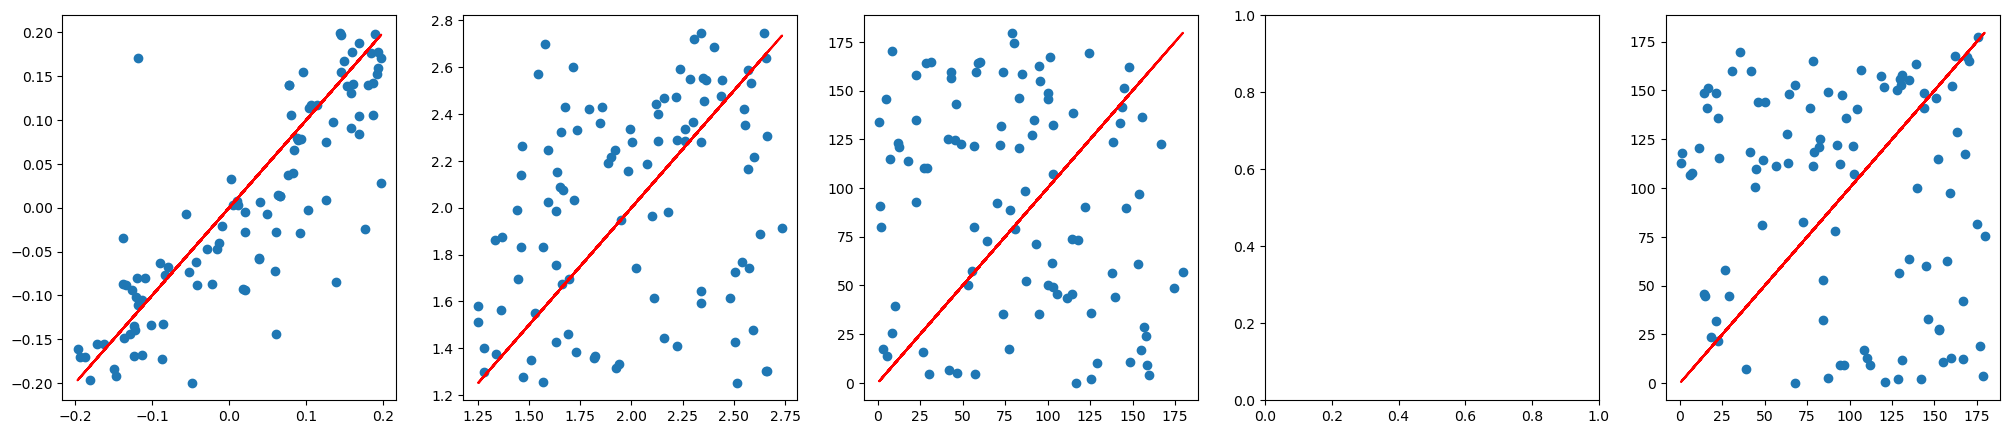

tensor(0.4729, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.3668,  0.1672, -0.0450,  0.0327,  0.2561],
       grad_fn=<SelectBackward0>)


 68%|██████▊   | 68/100 [13:50<06:17, 11.80s/it]

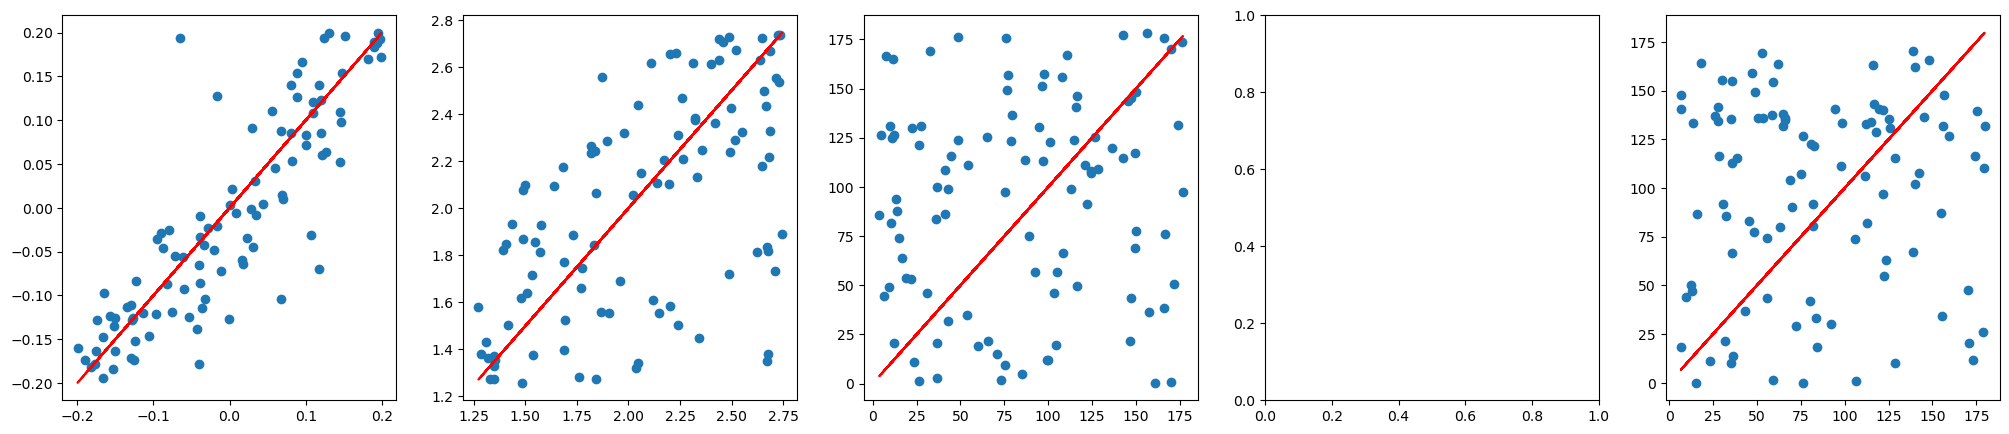

tensor(0.3712, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.0307,  0.4809,  0.4303,  0.6115,  0.6618],
       grad_fn=<SelectBackward0>)


 69%|██████▉   | 69/100 [14:02<06:05, 11.81s/it]

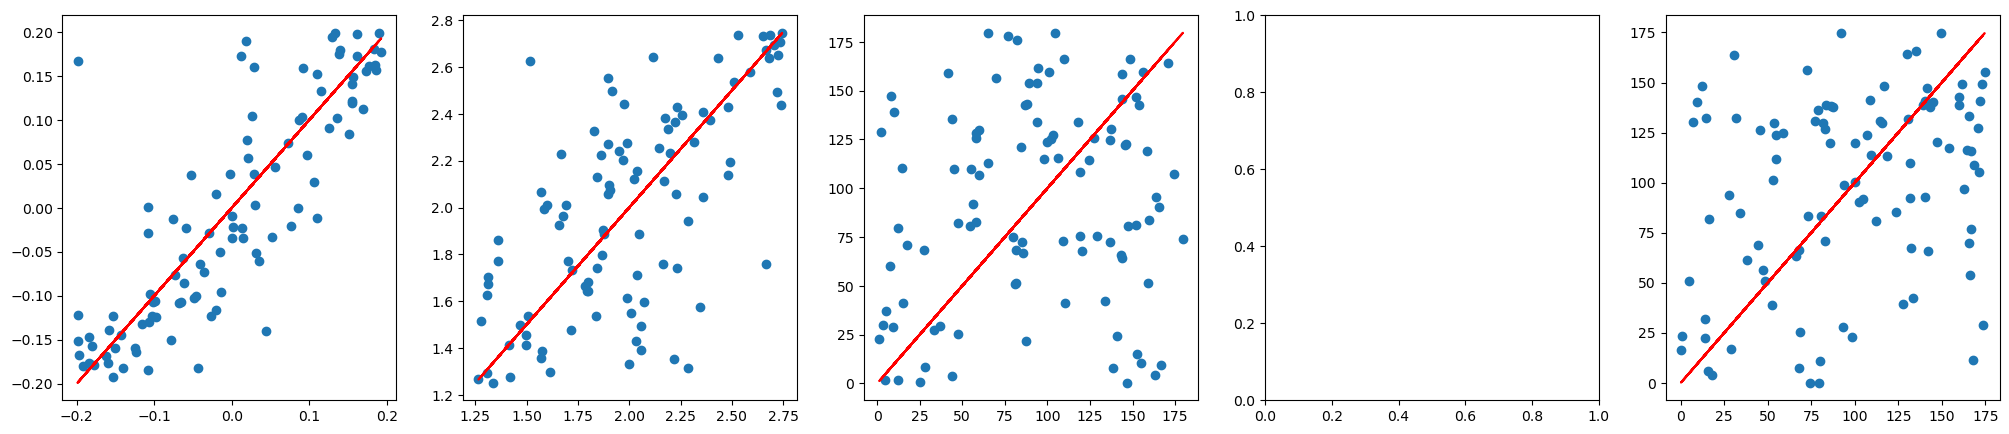

tensor(0.2978, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.1909, -0.4139, -0.7836, -0.1663, -0.0759],
       grad_fn=<SelectBackward0>)


 70%|███████   | 70/100 [14:15<05:58, 11.95s/it]

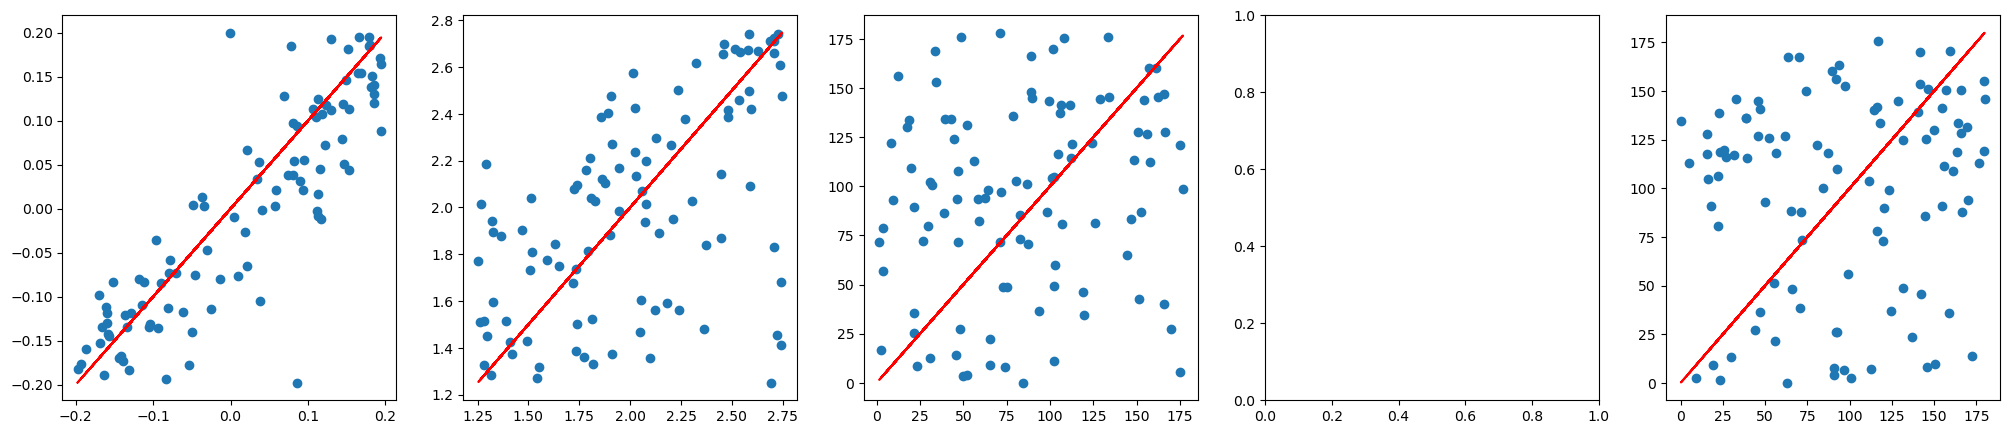

tensor(0.3381, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.5622, -0.9907, -0.9549, -0.1890,  0.2897],
       grad_fn=<SelectBackward0>)


 71%|███████   | 71/100 [14:26<05:46, 11.94s/it]

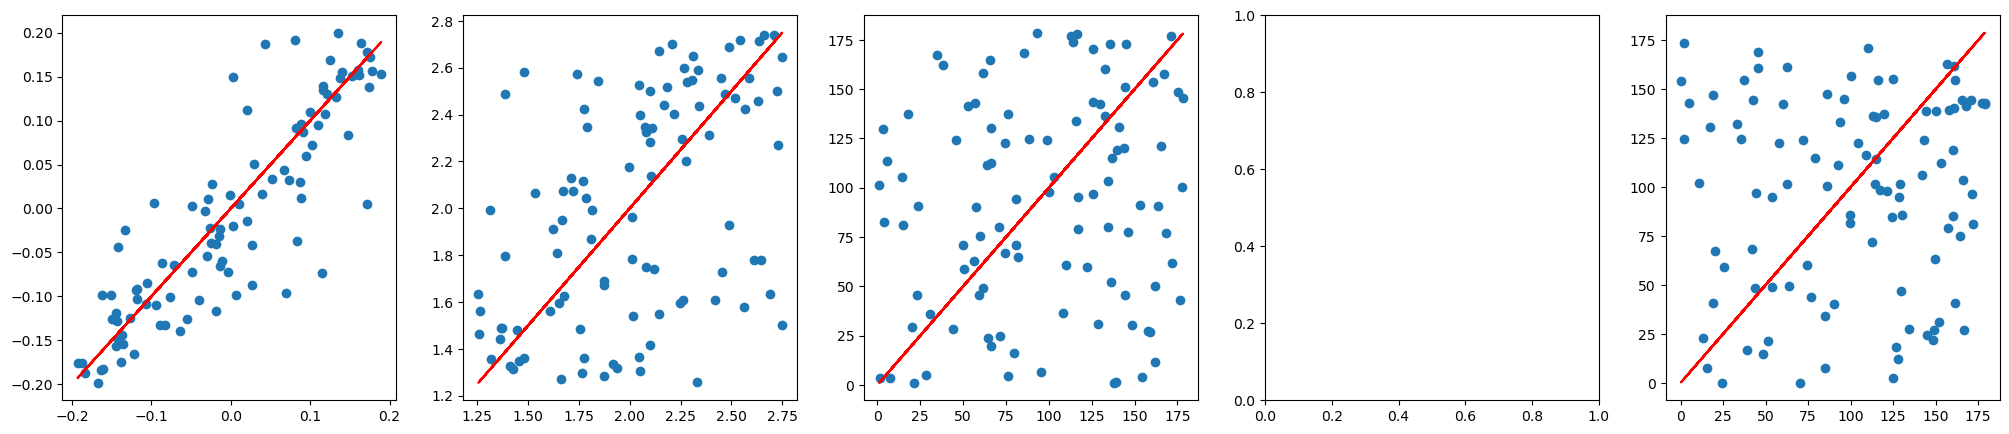

tensor(0.3594, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.4938, -0.3655, -0.5223, -0.5951, -0.7432],
       grad_fn=<SelectBackward0>)


 72%|███████▏  | 72/100 [14:38<05:30, 11.82s/it]

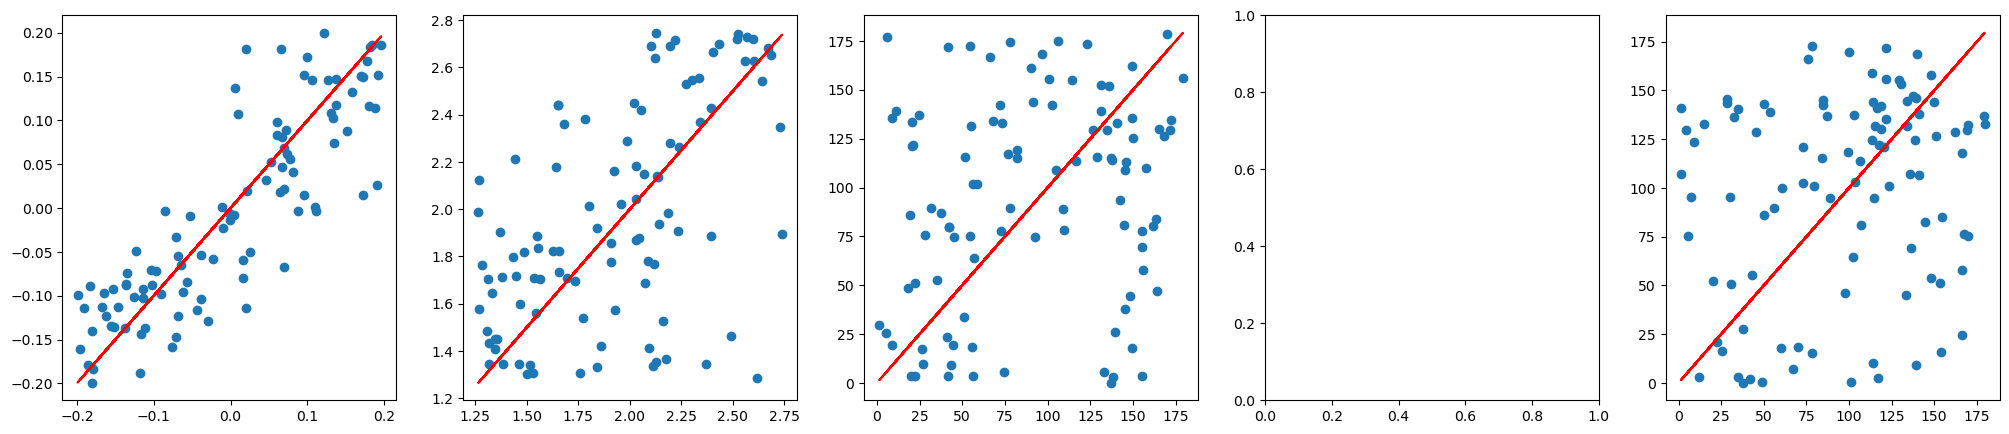

tensor(0.3250, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.6856,  0.8916,  0.8378,  0.4367,  0.4280],
       grad_fn=<SelectBackward0>)


 73%|███████▎  | 73/100 [14:50<05:17, 11.76s/it]

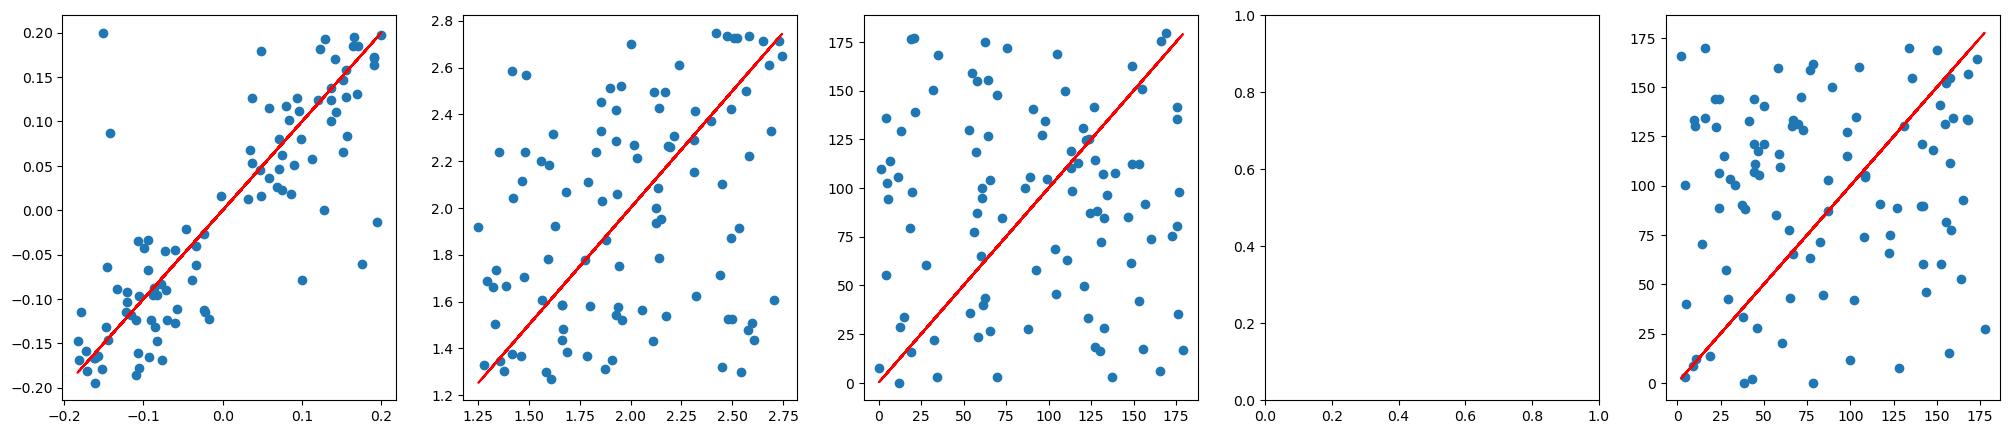

tensor(0.3857, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.5102, -0.3617,  0.1116,  0.0870,  0.1404],
       grad_fn=<SelectBackward0>)


 74%|███████▍  | 74/100 [15:02<05:08, 11.85s/it]

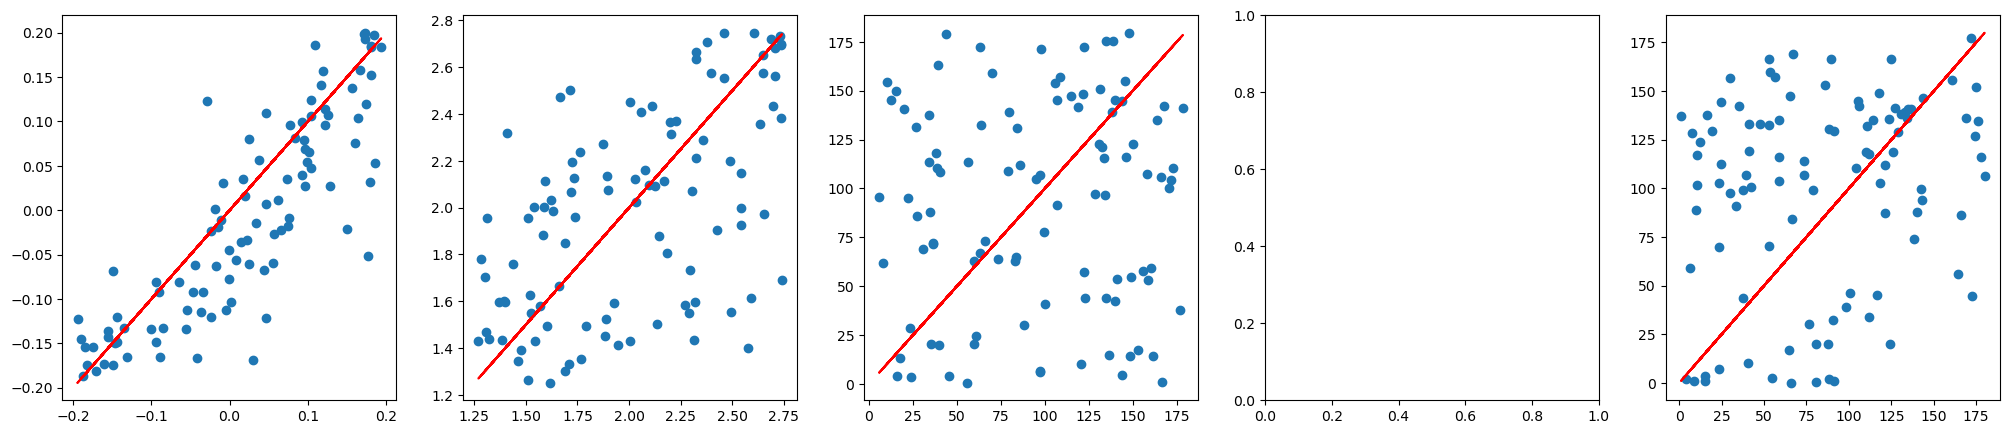

tensor(0.3741, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.6003,  0.1681, -0.5413,  0.0741, -0.0626],
       grad_fn=<SelectBackward0>)


 75%|███████▌  | 75/100 [15:14<05:03, 12.13s/it]

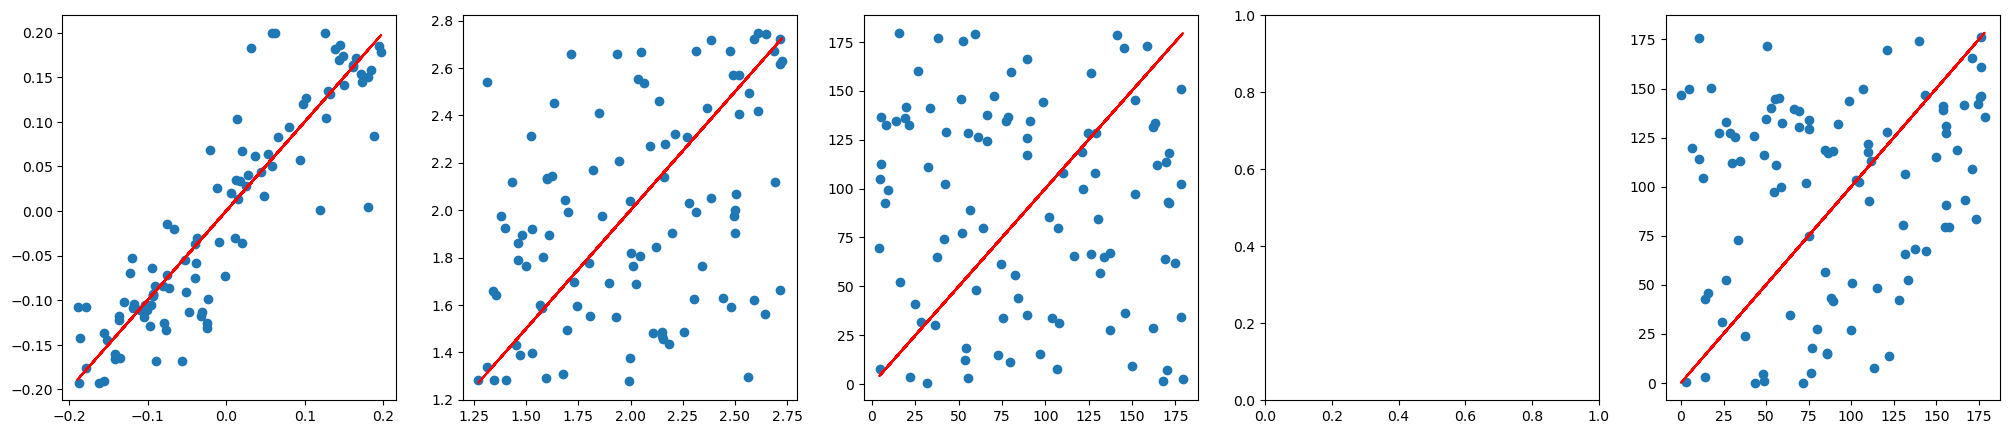

tensor(0.3819, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.8225,  0.9406,  0.6009, -0.1148, -0.1157],
       grad_fn=<SelectBackward0>)


 76%|███████▌  | 76/100 [15:26<04:46, 11.96s/it]

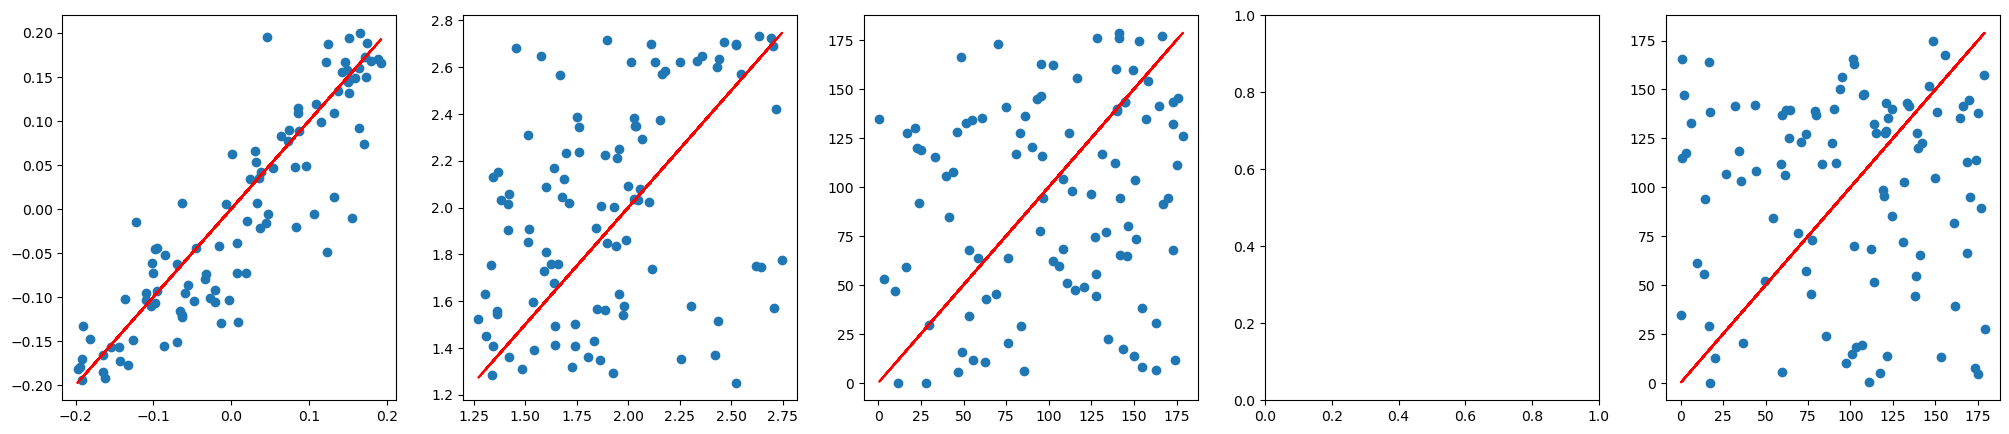

tensor(0.3689, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.3877,  0.3049, -0.6073,  0.2341,  0.2634],
       grad_fn=<SelectBackward0>)


 77%|███████▋  | 77/100 [15:39<04:39, 12.13s/it]

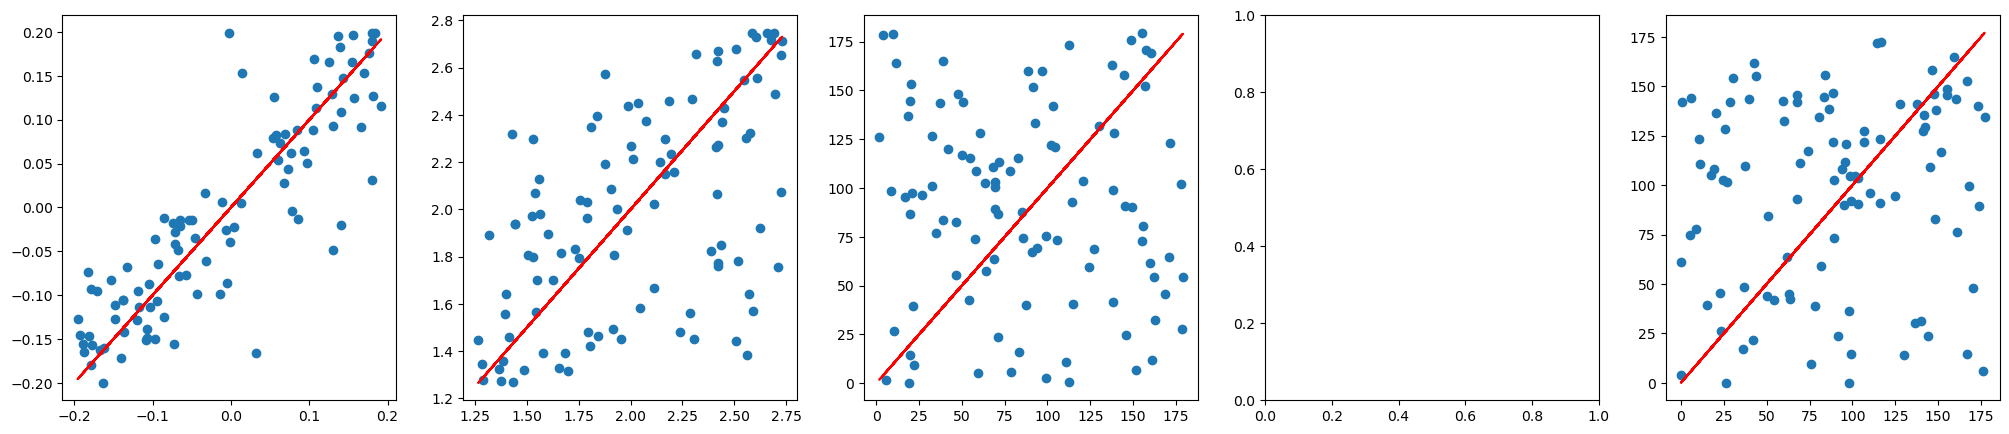

tensor(0.3570, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.8437, -0.4877,  0.3616, -0.0691,  0.1614],
       grad_fn=<SelectBackward0>)


 78%|███████▊  | 78/100 [15:51<04:25, 12.08s/it]

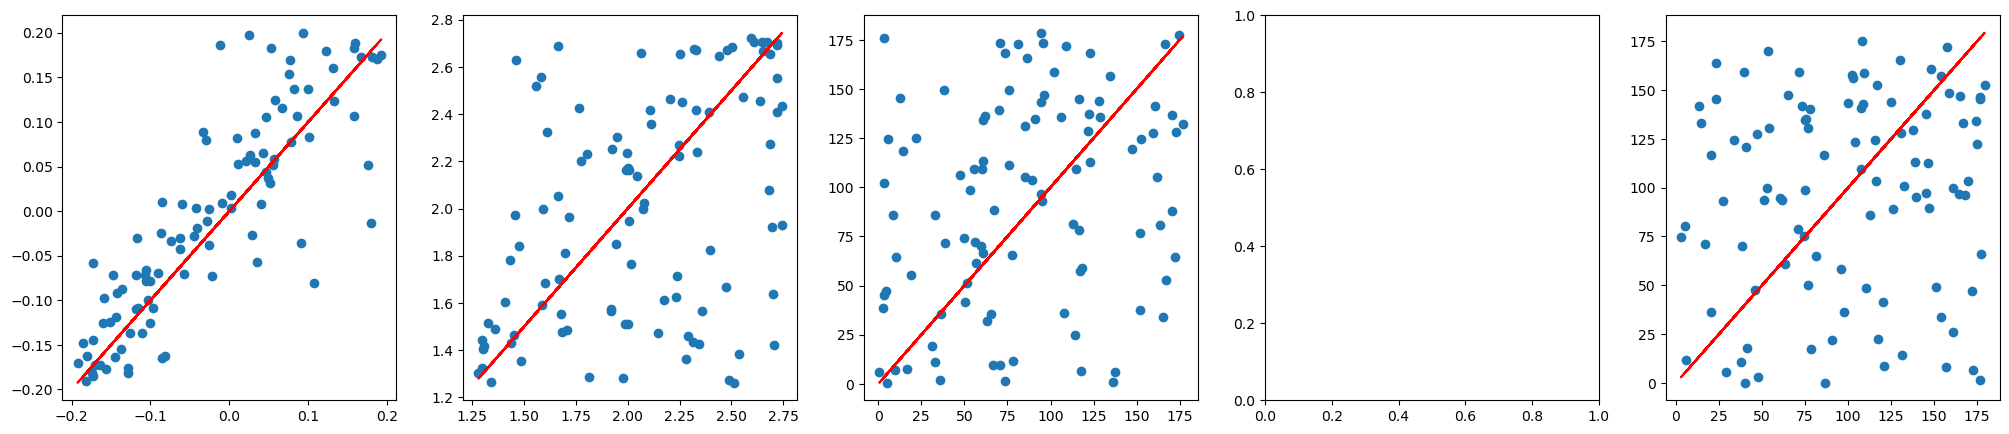

tensor(0.3628, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.3445, -0.6111, -0.4809, -0.5823,  0.0420],
       grad_fn=<SelectBackward0>)


 79%|███████▉  | 79/100 [16:03<04:13, 12.09s/it]

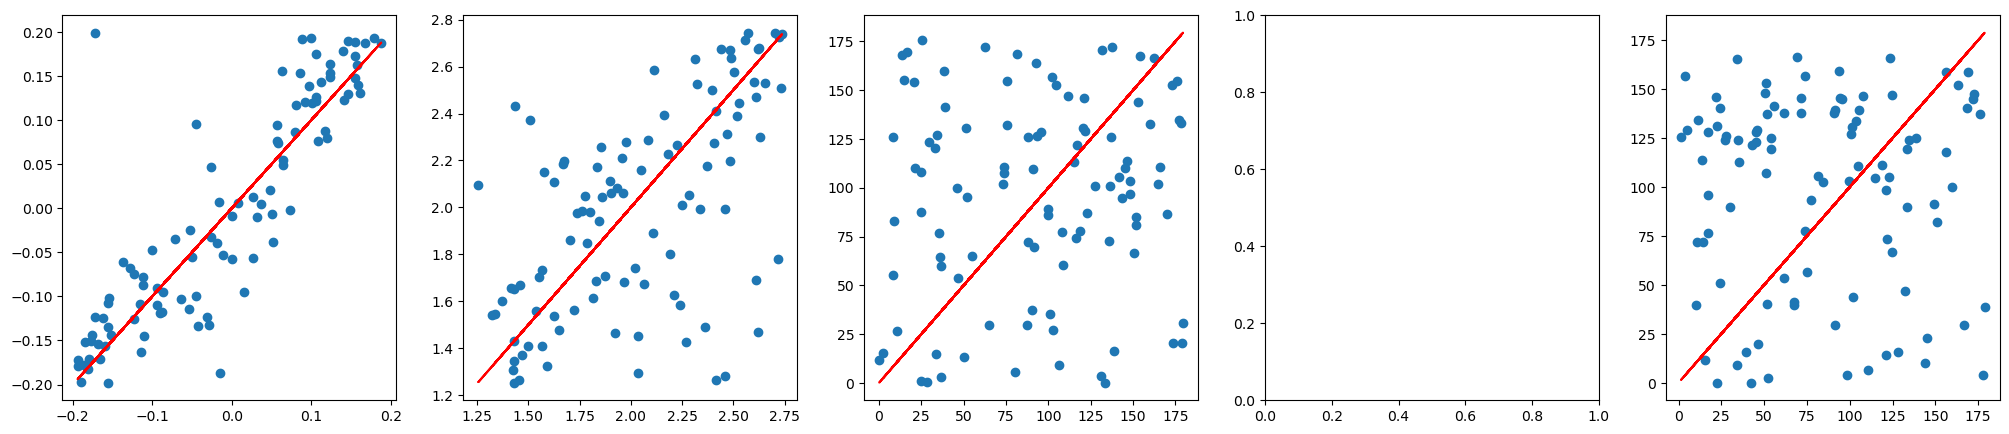

tensor(0.3598, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.8197, -0.0873,  0.7029,  0.5730,  0.4504],
       grad_fn=<SelectBackward0>)


 80%|████████  | 80/100 [16:15<04:03, 12.19s/it]

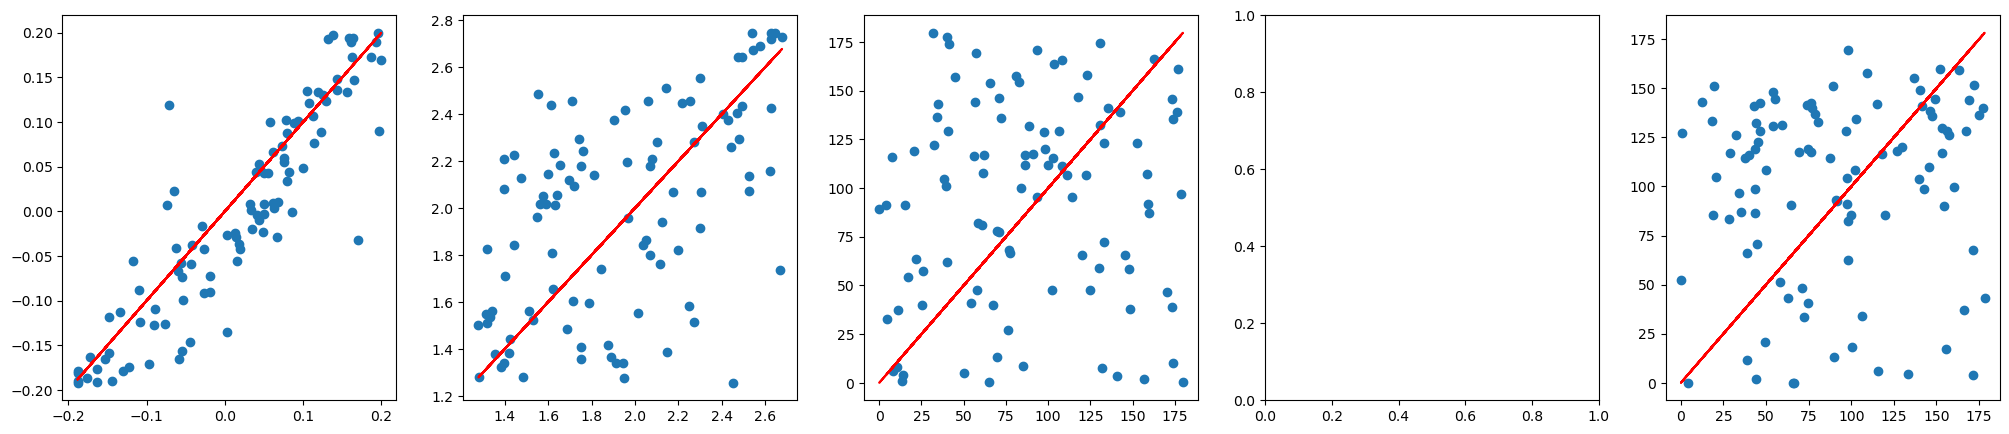

tensor(0.3370, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.2801, -0.6456, -0.2092, -0.3963,  0.2027],
       grad_fn=<SelectBackward0>)


 81%|████████  | 81/100 [16:27<03:48, 12.03s/it]

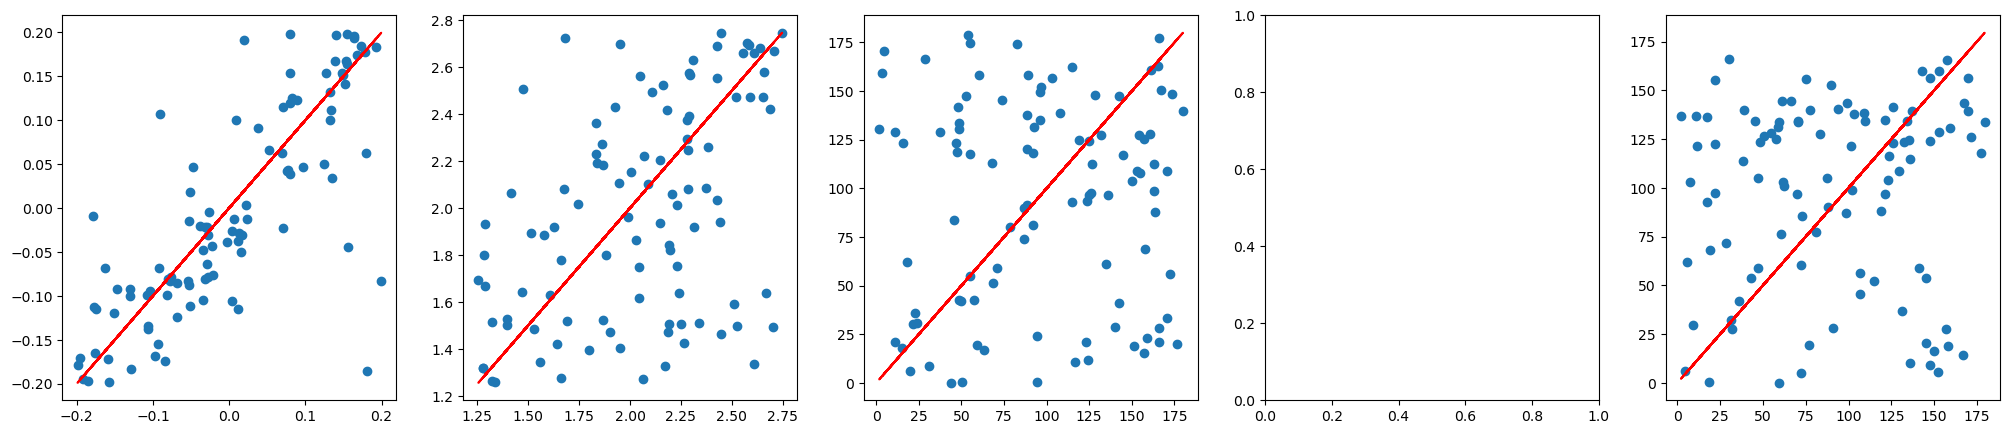

tensor(0.3731, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.4613, -0.6571, -0.6667, -0.7836, -0.4177],
       grad_fn=<SelectBackward0>)


 82%|████████▏ | 82/100 [16:39<03:37, 12.09s/it]

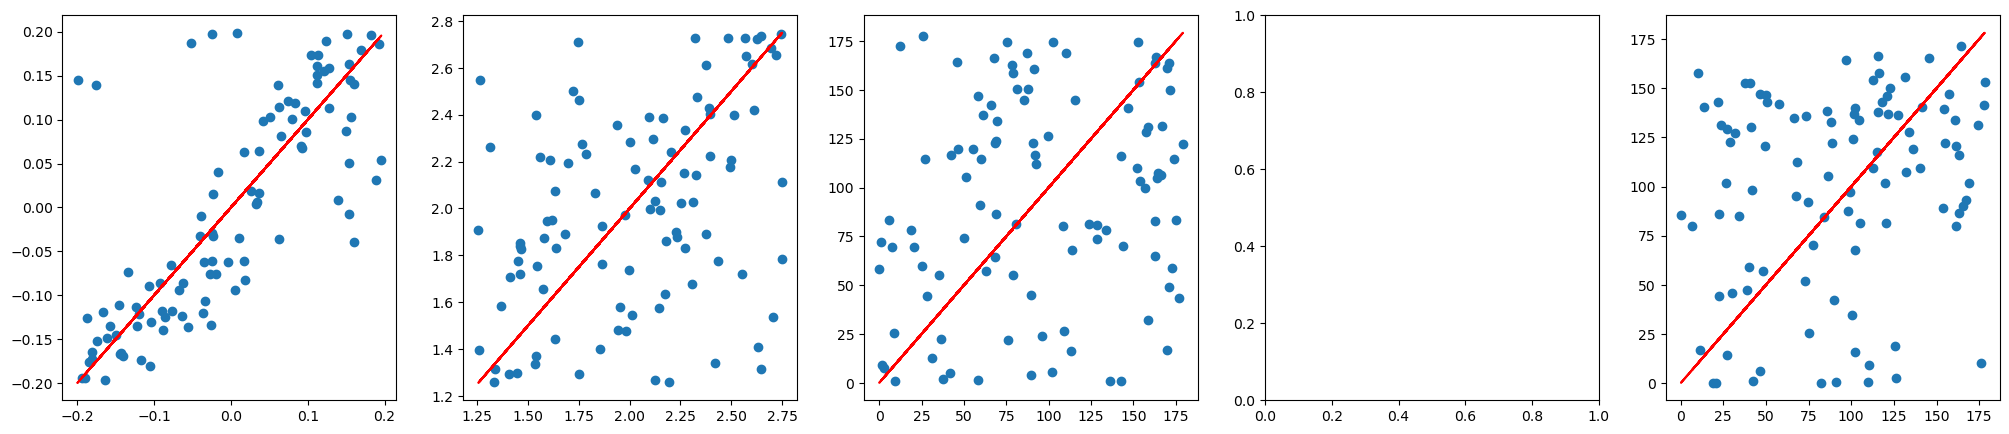

tensor(0.3701, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.8158, -0.9364, -0.9889, -0.8613, -0.0419],
       grad_fn=<SelectBackward0>)


 83%|████████▎ | 83/100 [16:51<03:25, 12.07s/it]

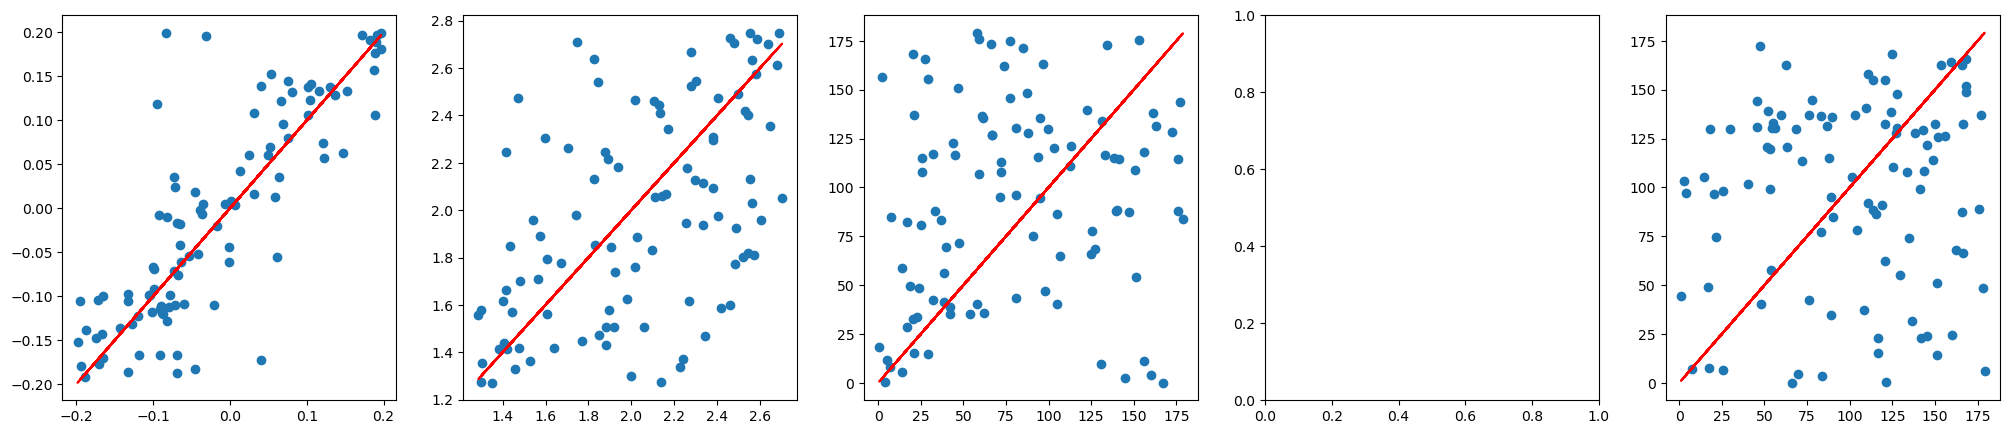

tensor(0.3330, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.8645,  0.9991,  0.9988,  0.5186, -0.9974],
       grad_fn=<SelectBackward0>)


 84%|████████▍ | 84/100 [17:03<03:12, 12.05s/it]

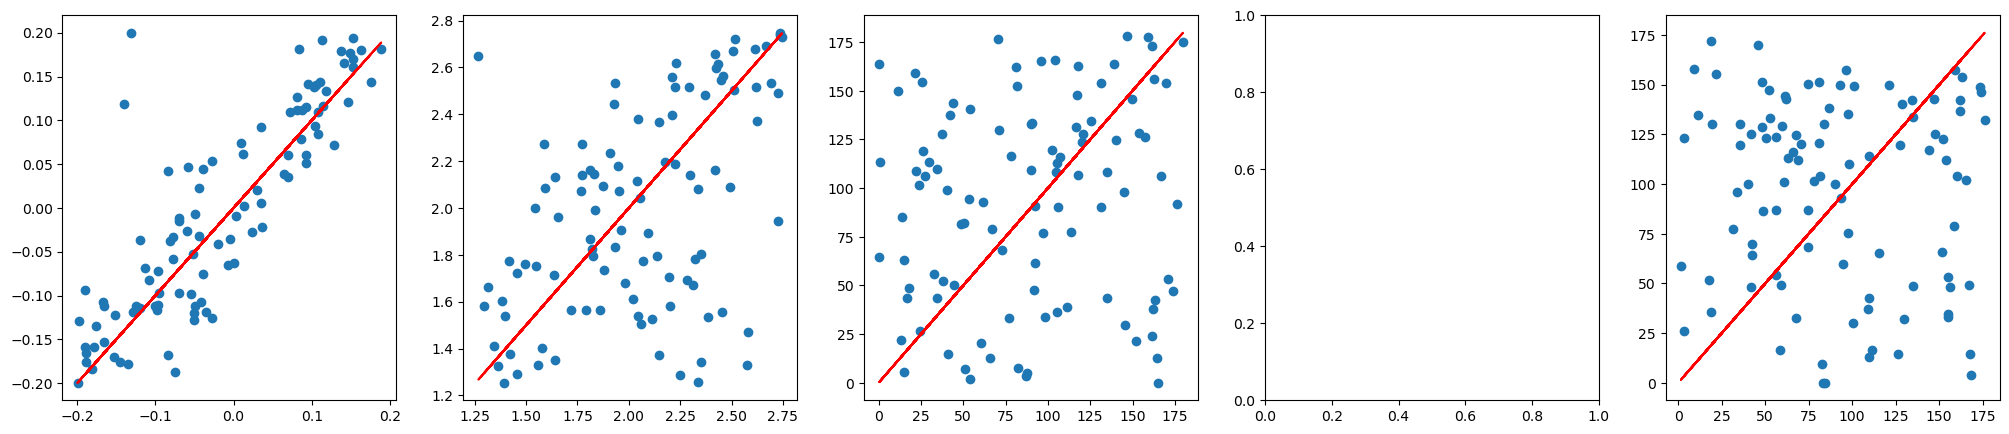

tensor(0.3723, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.7007, -0.9648, -0.9928, -0.9384, -0.0319],
       grad_fn=<SelectBackward0>)


 85%|████████▌ | 85/100 [17:15<03:01, 12.08s/it]

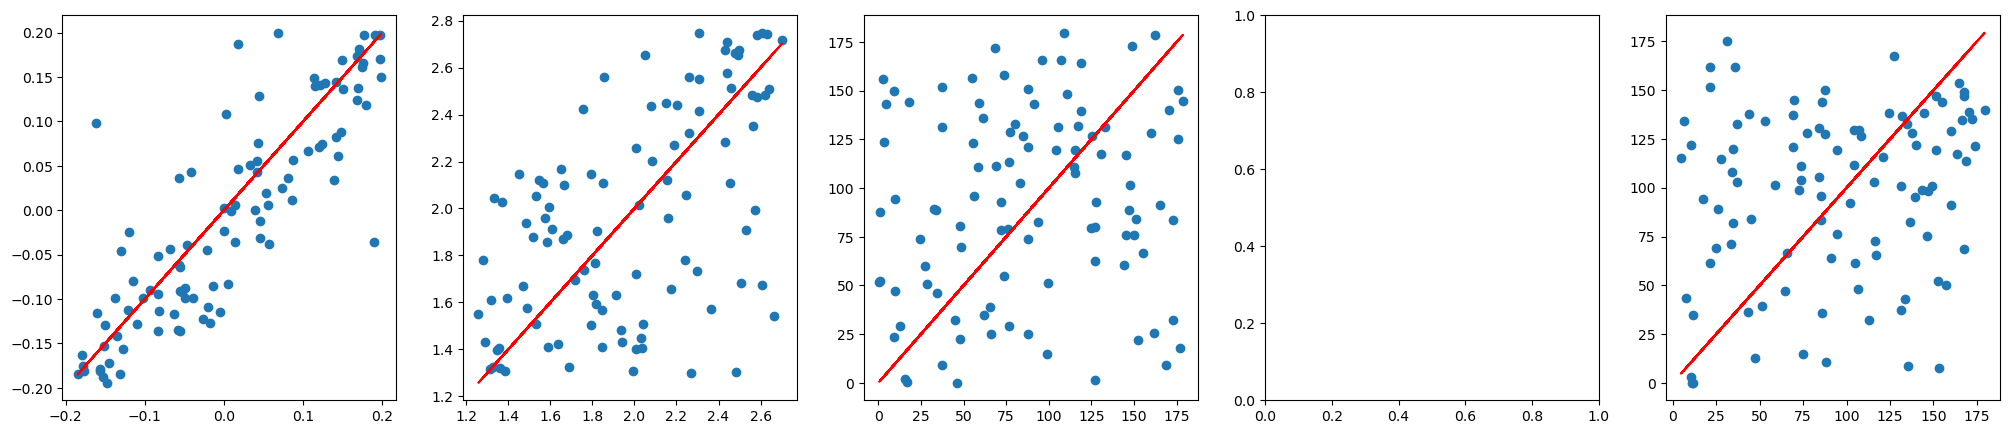

tensor(0.3130, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([0.3758, 0.3404, 0.0713, 0.6895, 0.6343], grad_fn=<SelectBackward0>)


 86%|████████▌ | 86/100 [17:27<02:47, 11.98s/it]

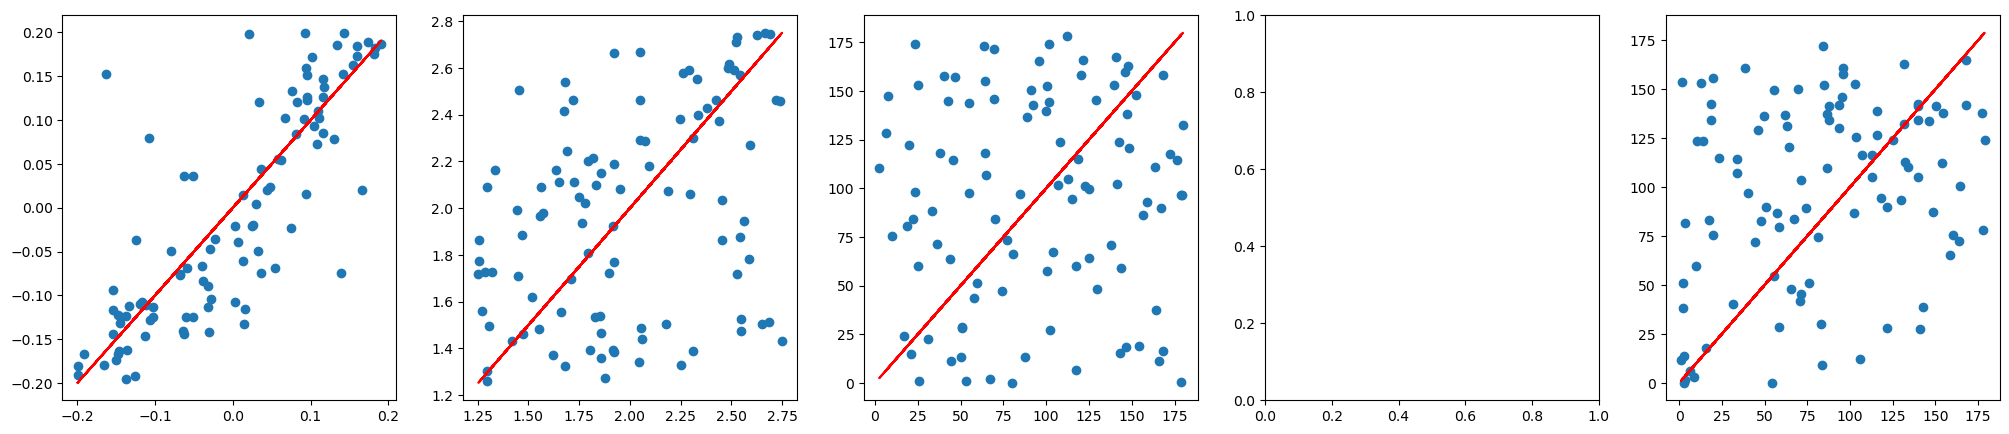

tensor(0.3630, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.4683, -0.2634, -0.7089, -0.2530, -0.1706],
       grad_fn=<SelectBackward0>)


 87%|████████▋ | 87/100 [17:39<02:37, 12.09s/it]

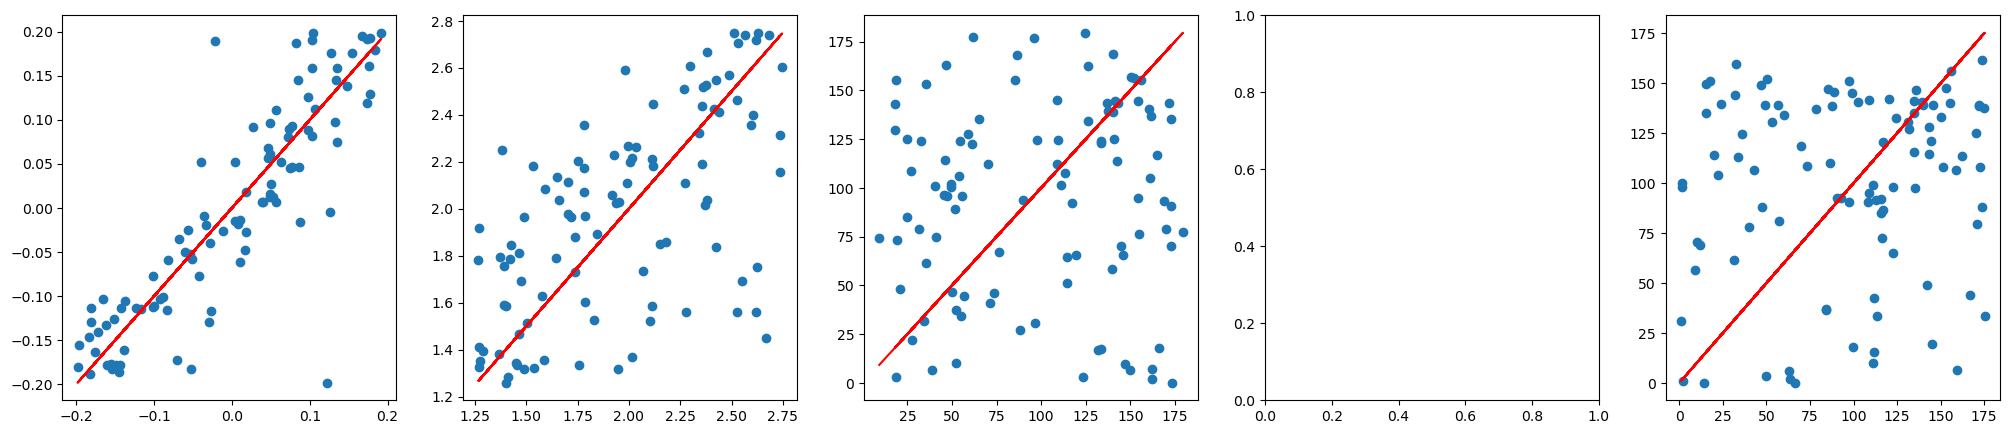

tensor(0.3243, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.5673, -0.1818, -0.3513, -0.1745, -0.0389],
       grad_fn=<SelectBackward0>)


 88%|████████▊ | 88/100 [17:51<02:23, 11.96s/it]

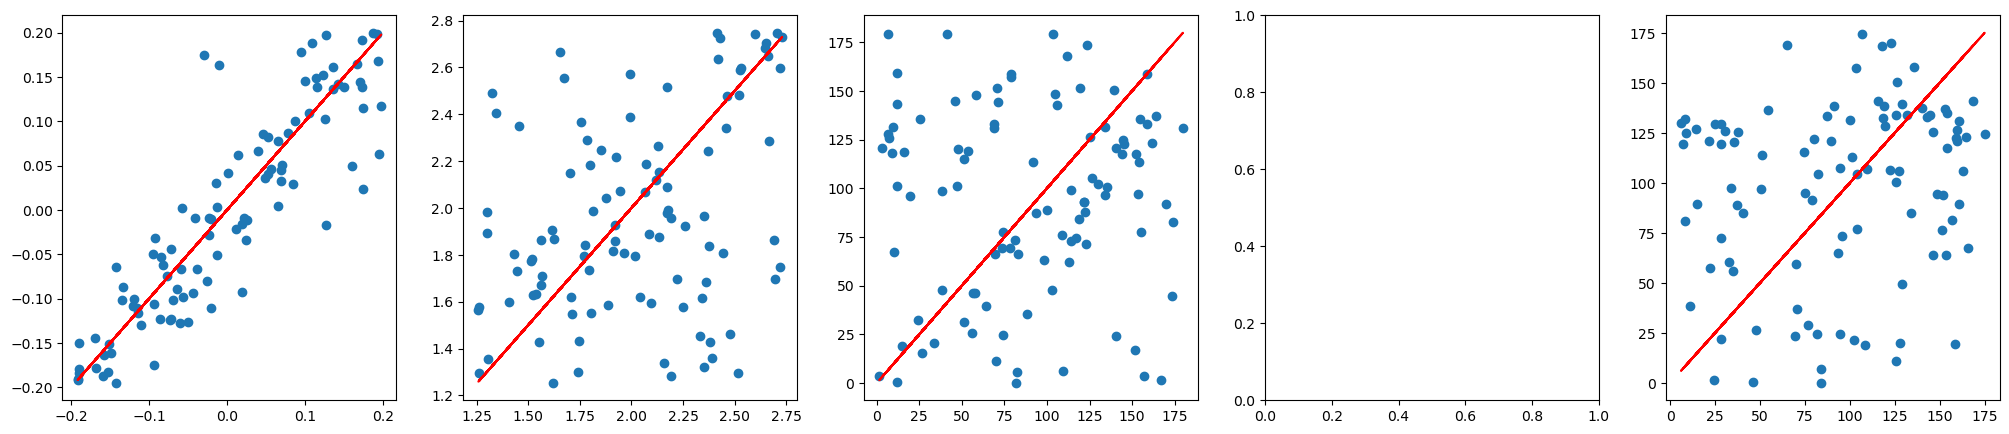

tensor(0.3286, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([0.9920, 0.7114, 0.9924, 0.9890, 0.8866], grad_fn=<SelectBackward0>)


 89%|████████▉ | 89/100 [18:03<02:13, 12.12s/it]

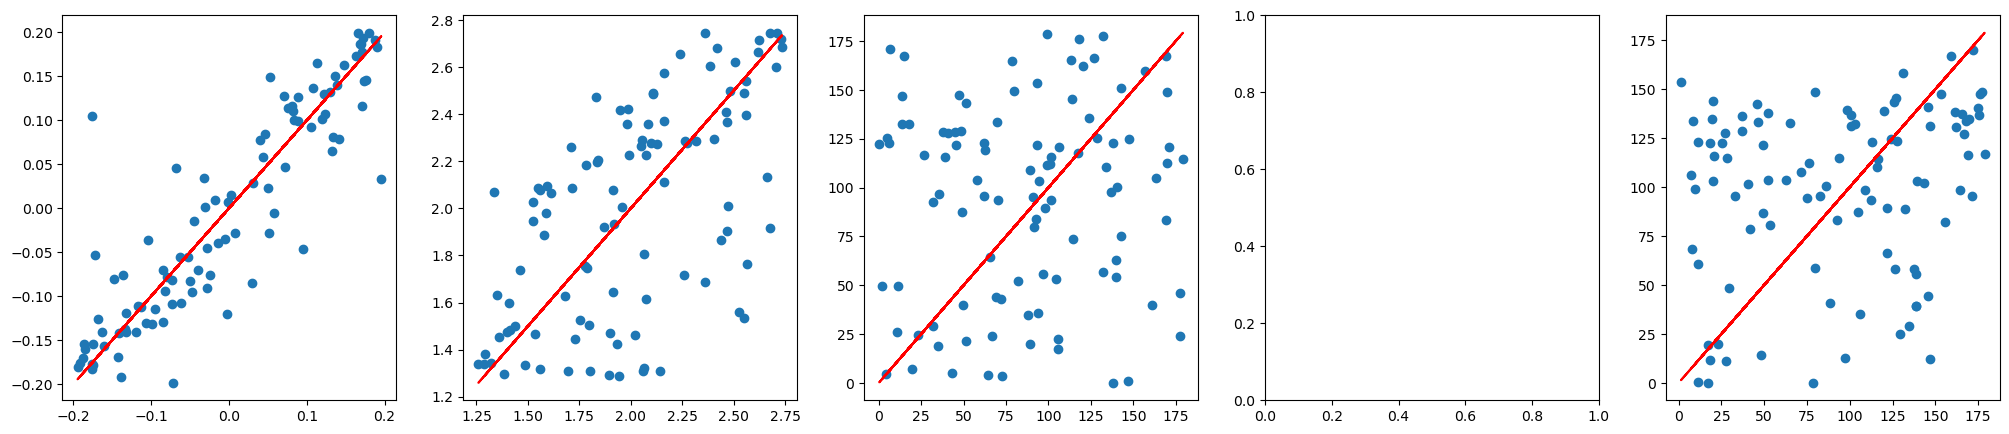

tensor(0.3210, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.0377, -0.1815,  0.0053,  0.3635,  0.4849],
       grad_fn=<SelectBackward0>)


 90%|█████████ | 90/100 [18:16<02:02, 12.22s/it]

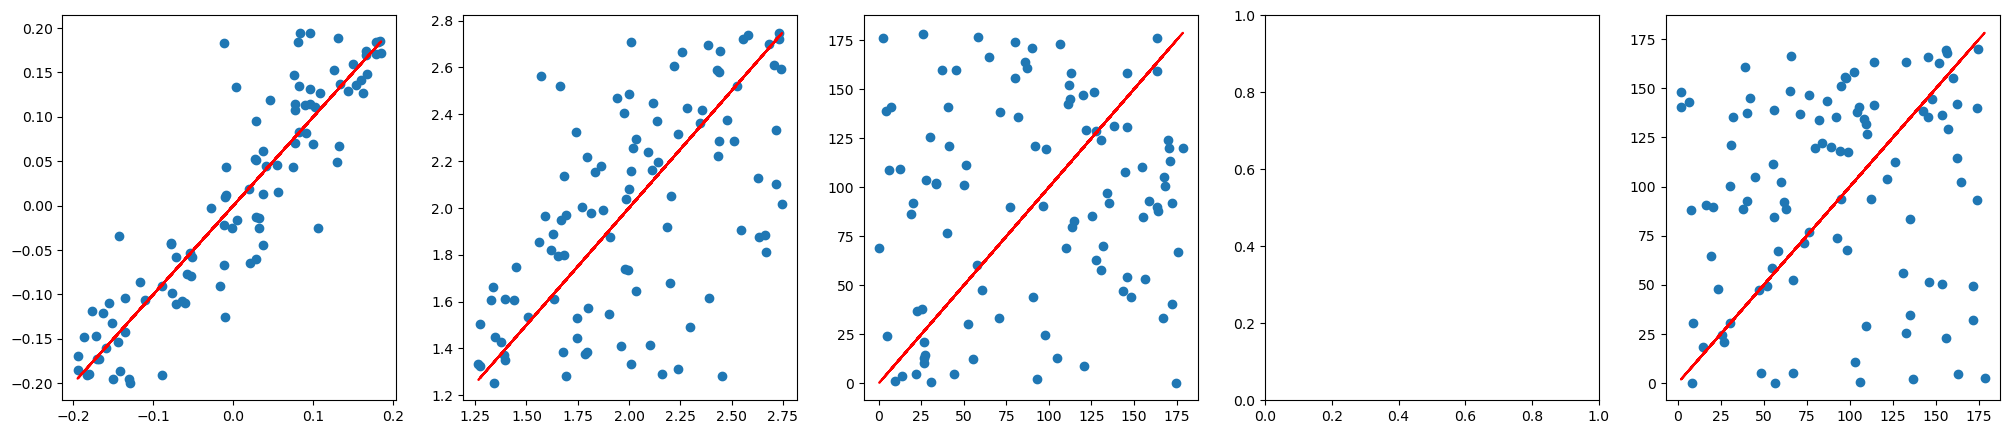

tensor(0.3483, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.6050, -0.1164, -0.2715, -0.4796, -0.7674],
       grad_fn=<SelectBackward0>)


 91%|█████████ | 91/100 [18:28<01:48, 12.11s/it]

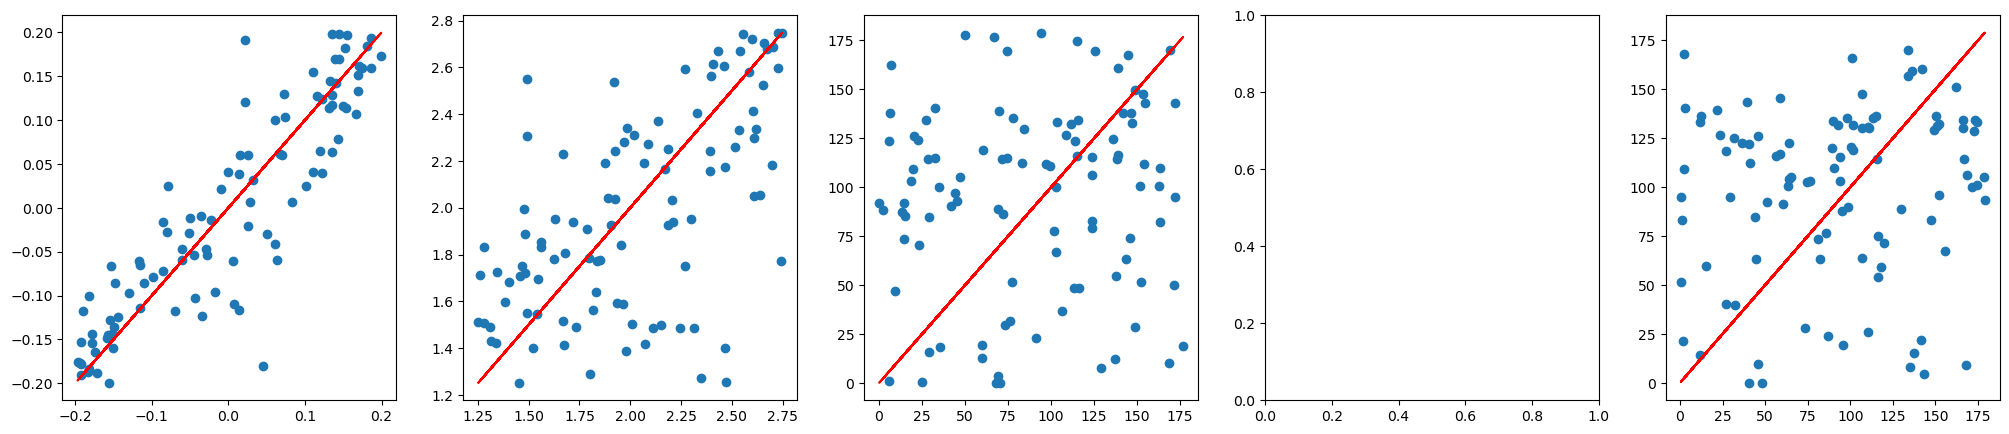

tensor(0.3186, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.3295,  0.7286, -0.2255,  0.0207,  0.1814],
       grad_fn=<SelectBackward0>)


 92%|█████████▏| 92/100 [18:40<01:36, 12.04s/it]

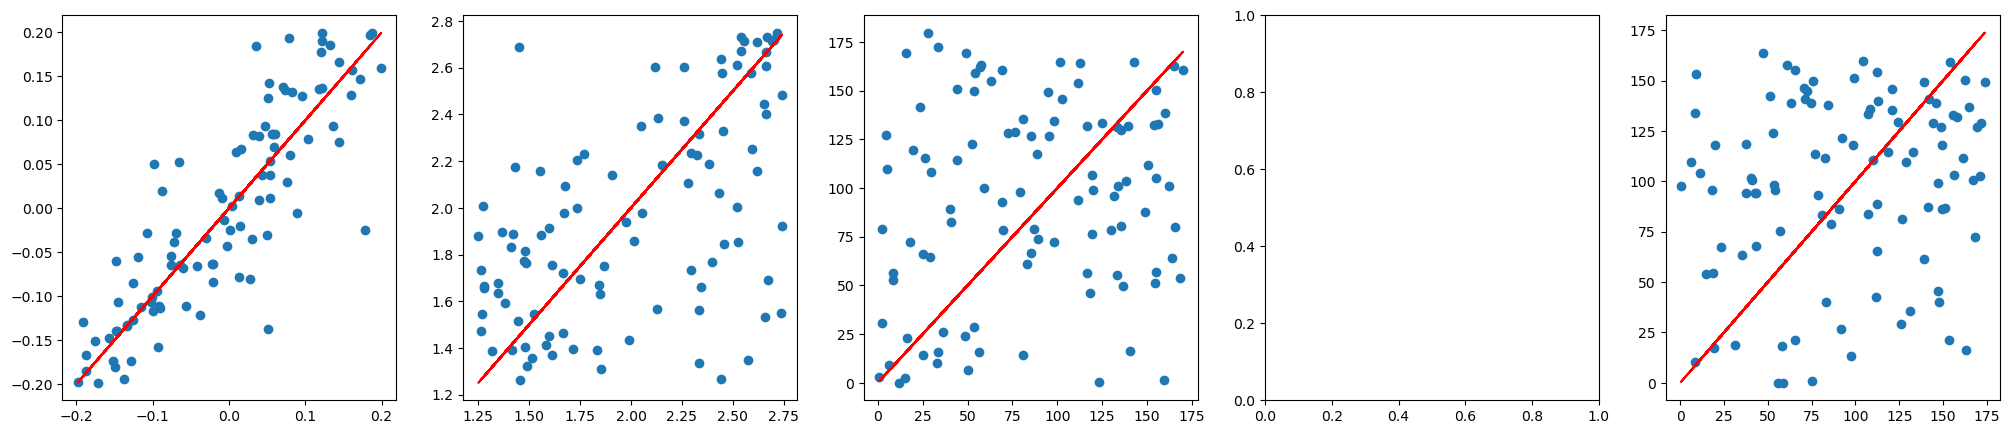

tensor(0.3207, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.6627, -0.5516,  0.1395, -0.1240, -0.0158],
       grad_fn=<SelectBackward0>)


 93%|█████████▎| 93/100 [18:51<01:23, 11.91s/it]

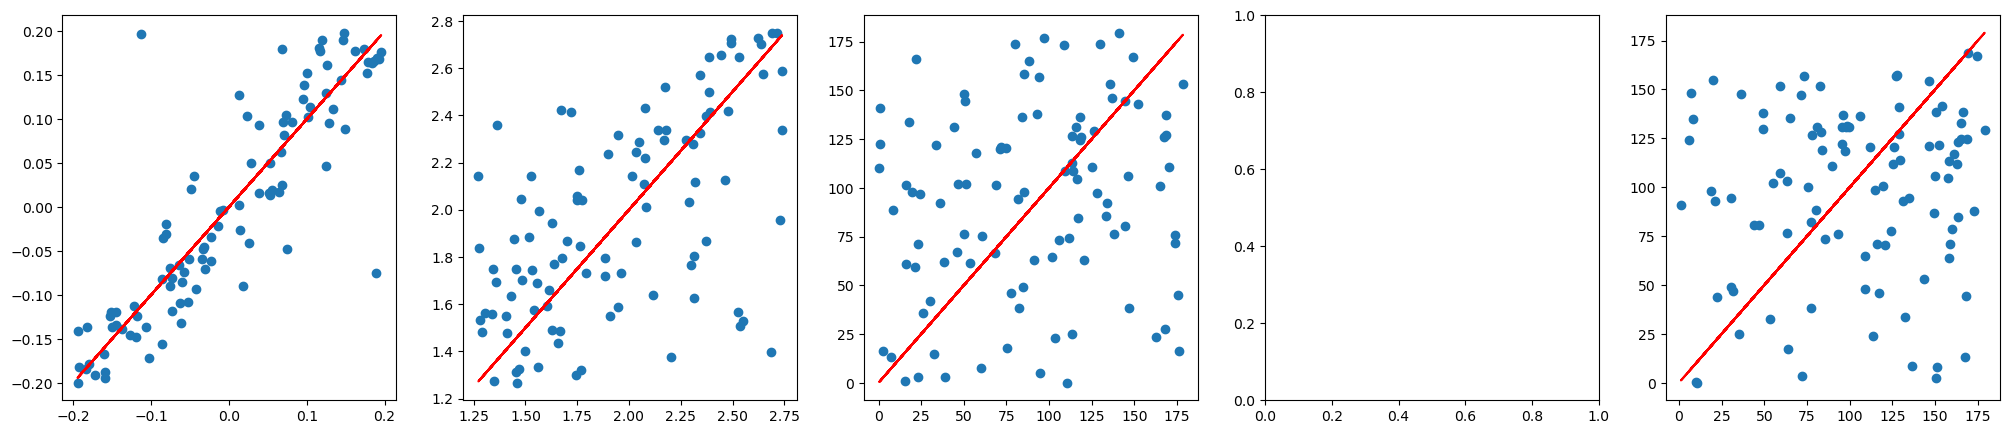

tensor(0.2905, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([0.5213, 0.0292, 0.1561, 0.2309, 0.3212], grad_fn=<SelectBackward0>)


 94%|█████████▍| 94/100 [19:03<01:11, 11.99s/it]

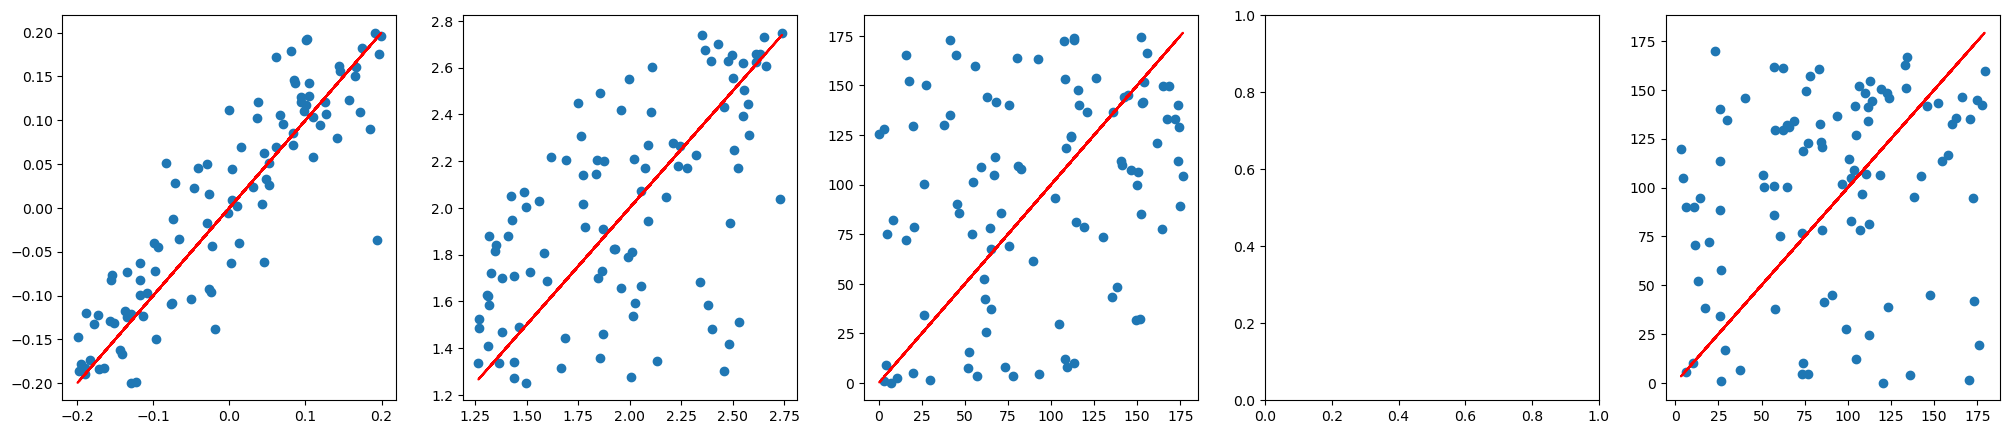

tensor(0.2911, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([0.6405, 0.4697, 0.2660, 0.8370, 0.7898], grad_fn=<SelectBackward0>)


 95%|█████████▌| 95/100 [19:16<01:00, 12.09s/it]

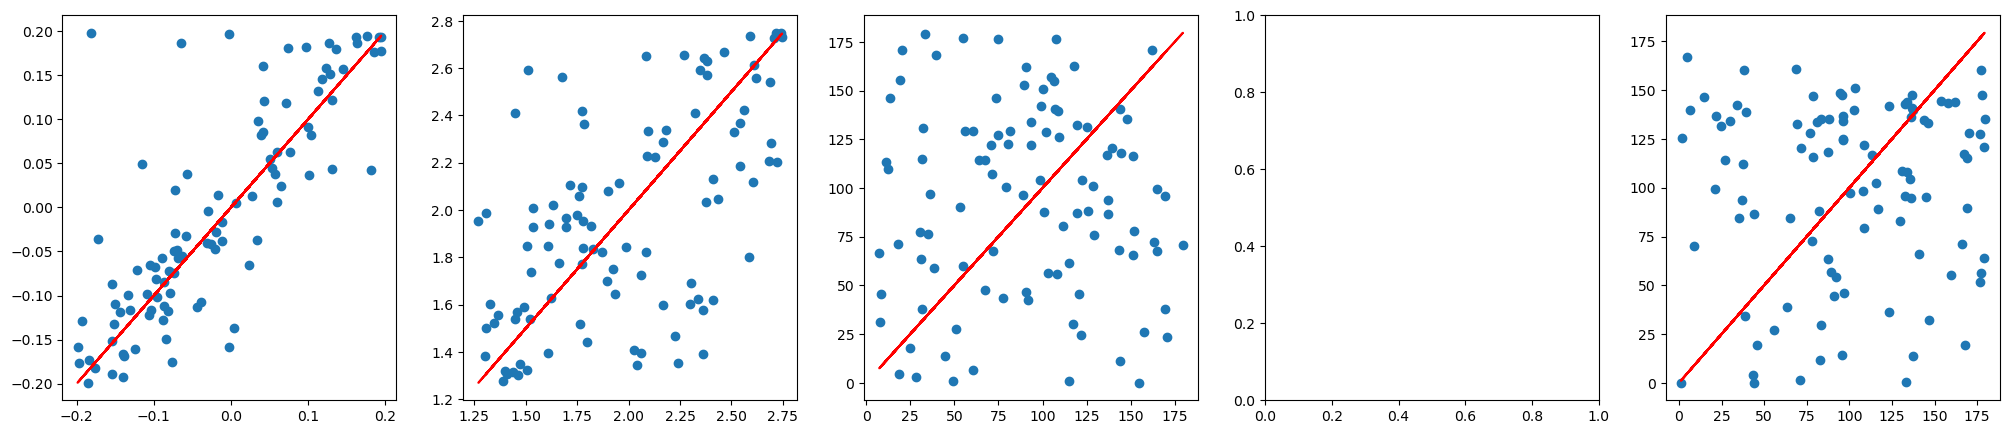

tensor(0.3305, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([0.5938, 0.3147, 0.0814, 0.6255, 0.6405], grad_fn=<SelectBackward0>)


 96%|█████████▌| 96/100 [19:28<00:48, 12.08s/it]

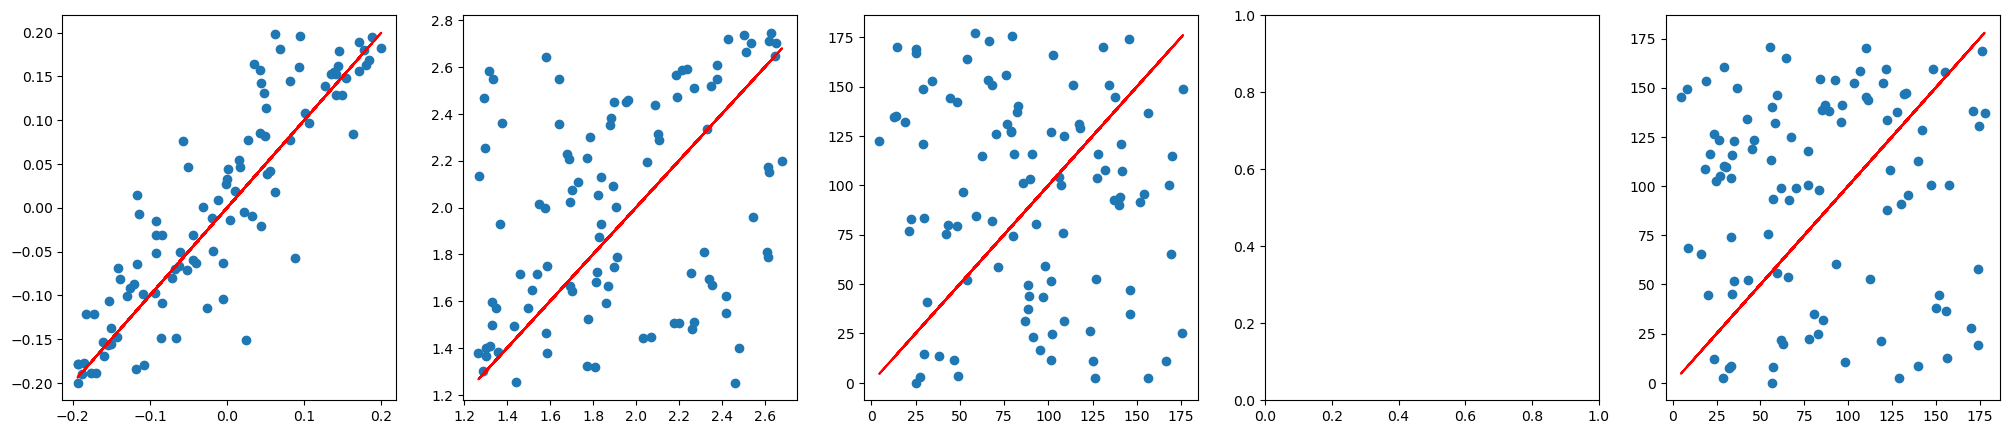

tensor(0.3855, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.4222,  0.3221, -0.0017,  0.7310,  0.7074],
       grad_fn=<SelectBackward0>)


 97%|█████████▋| 97/100 [19:39<00:35, 11.94s/it]

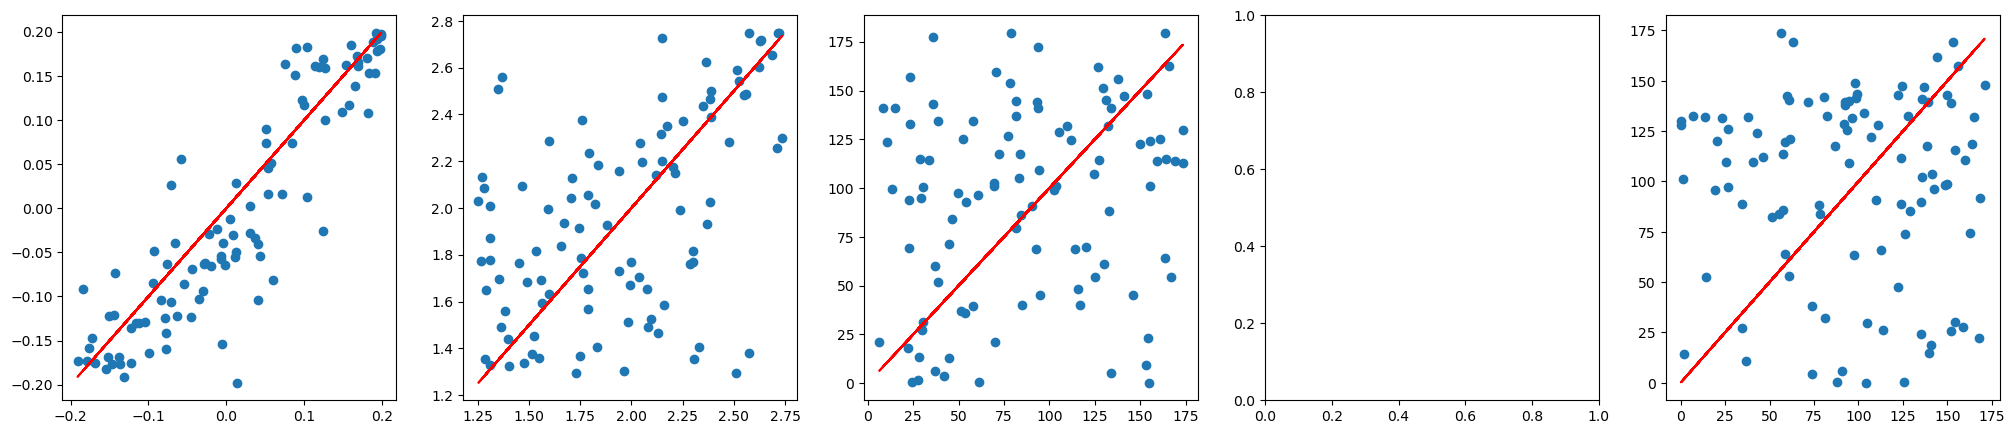

tensor(0.3241, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.2436,  0.2744, -0.4602,  0.1662,  0.3301],
       grad_fn=<SelectBackward0>)


 98%|█████████▊| 98/100 [19:51<00:23, 11.97s/it]

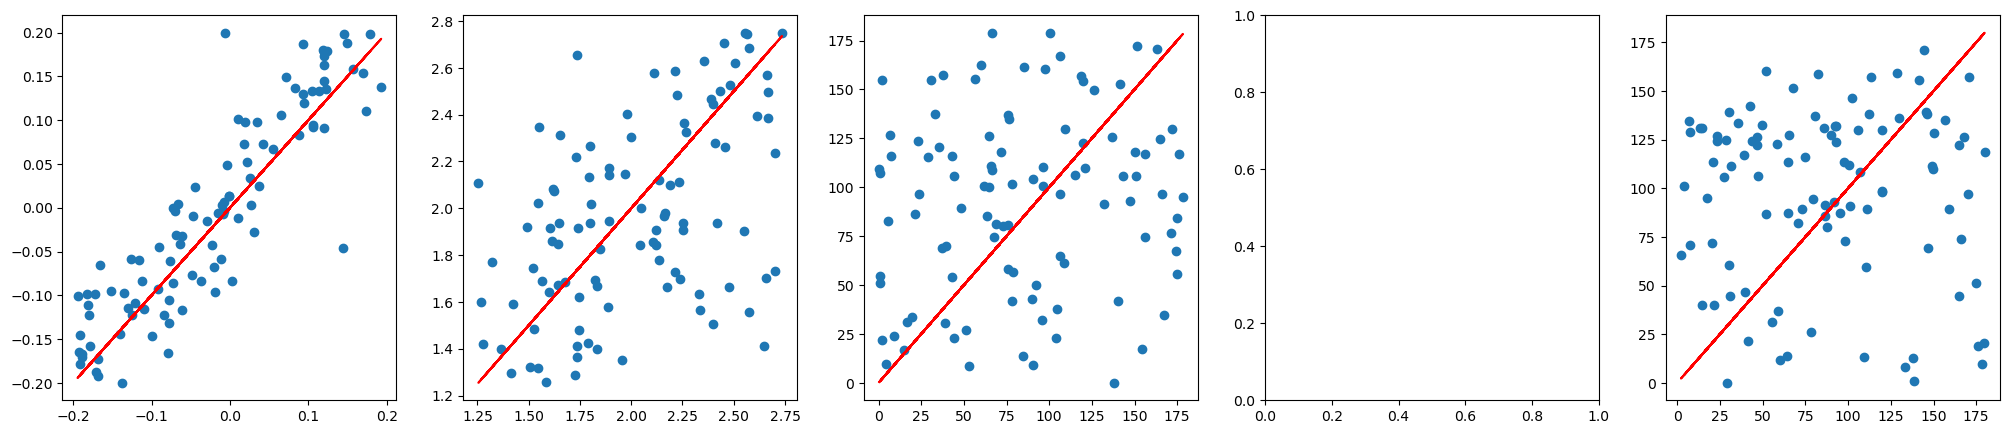

tensor(0.3220, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([-0.6591,  0.8464,  0.4172,  0.2160,  0.4060],
       grad_fn=<SelectBackward0>)


 99%|█████████▉| 99/100 [20:04<00:12, 12.05s/it]

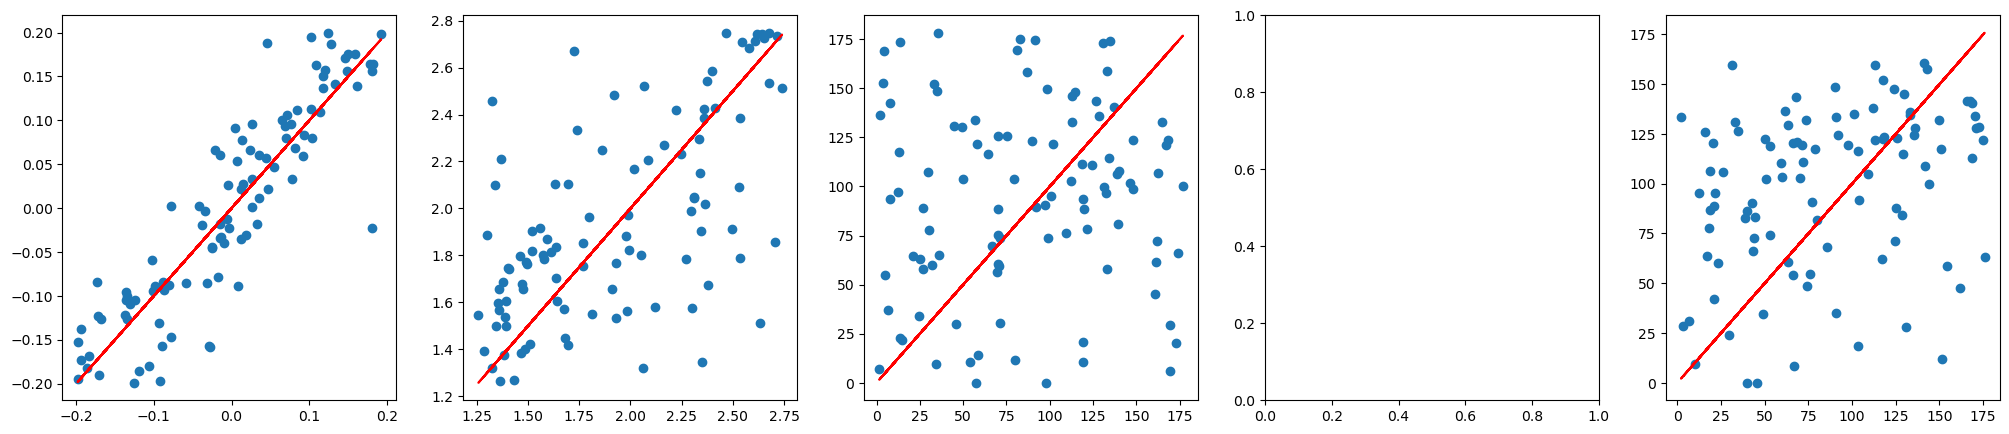

tensor(0.2796, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor([ 0.4771,  0.4200, -0.1308,  0.4854,  0.4840],
       grad_fn=<SelectBackward0>)


100%|██████████| 100/100 [20:16<00:00, 12.16s/it]


In [425]:
train(model5d,2000)

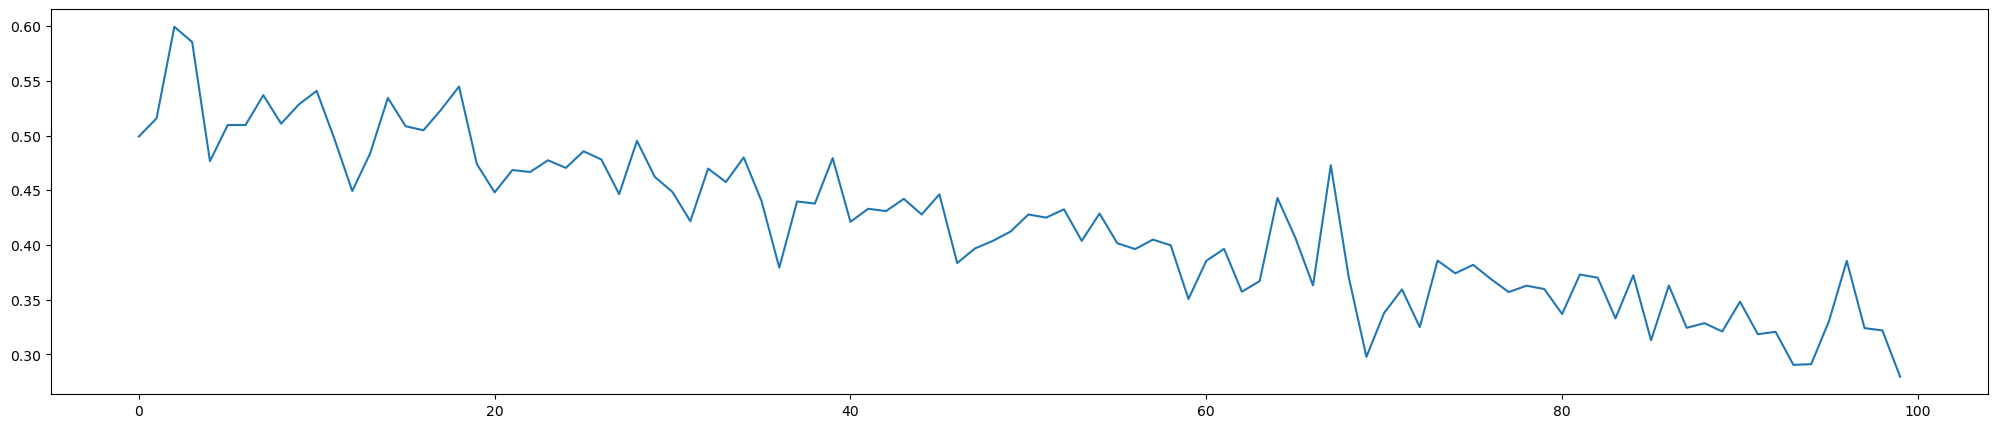

In [426]:
plt.plot(loss_record)

In [368]:
torch.save(model2d.state_dict(), "model2d.pth")
torch.save(backbone.state_dict(), "backbone.pth")
torch.save(model3d.state_dict(), "model3d.pth")
torch.save(backbone2.state_dict(), "backbone2.pth")